# Q1 - Skip Gram

In [ ]:
!wget http://mattmahoney.net/dc/text8.zip

--2025-04-02 14:24:17--  http://mattmahoney.net/dc/text8.zip
Resolving mattmahoney.net (mattmahoney.net)... 34.198.1.81
Connecting to mattmahoney.net (mattmahoney.net)|34.198.1.81|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31344016 (30M) [application/zip]
Saving to: ‘text8.zip’

text8.zip           100%[===================>]  29.89M  8.62MB/s    in 3.5s    

2025-04-02 14:24:21 (8.62 MB/s) - ‘text8.zip’ saved [31344016/31344016]



In [ ]:
!unzip 'text8.zip'

Archive:  text8.zip
  inflating: text8                   


#### Load dataset

In [ ]:
with open("text8") as f:
    text = f.read()

In [ ]:
import re
from collections import Counter
from torch import nn, optim
import torch.nn.functional as F

In [ ]:
import random
import numpy as np
import torch

seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

#### Preprocess

In [ ]:
text = text.lower()
text = re.sub(r'[^\w\s]', '', text) # remove symbols
words = text.split()

In [ ]:
word_counts = Counter(words)
trimmed_words = [word for word in words if word_counts[word] > 5] # Remove words with frequency less than 5

In [ ]:
word_counts = Counter(trimmed_words)
sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)} # mapping
vocab_to_int = {word: ii for ii, word in int_to_vocab.items()} # reverse-mapping
int_words = [vocab_to_int[word] for word in trimmed_words]

In [ ]:
freq = Counter(int_words)
threshold = 1e-5
p_drop = {word: 1 - np.sqrt(threshold / (freq[word]) / len(int_words)) for word in freq}
train_words = [word for word in int_words if p_drop[word] < (1 - random.random())] # Drop words with highest occurance

In [ ]:
# batch split
def get_batches(words, batch_size, window_size=5): # for gpu
    for i in range(0, len(words), batch_size):
        curr = words[i:i + batch_size]
        batch_x, batch_y = [], []
        for j in range(len(curr)):
            r = random.randint(1, window_size)
            start = max(0, j - r)
            end = min(j + r, len(curr) - 1)
            targets = curr[start:j] + curr[j+1:end+1]
            batch_x.extend([curr[j]] * len(targets))
            batch_y.extend(targets)
        yield batch_x, batch_y

#### Generate negative vectors

In [ ]:
def generate_negative_vectors(negative_embedding, negative_distribution, vocab_size, batch_sz, num_samples):
    device = negative_embedding.device
    if negative_distribution is None:
        negative_distribution = torch.ones(vocab_size, device=device) / vocab_size # Equal probability
    else:
        negative_distribution = negative_distribution / negative_distribution.sum()

    cumulative_distribution = torch.cumsum(negative_distribution, dim=0)
    uniform_samples = torch.rand(batch_sz * num_samples, device=device)
    # Find the indices corresponding to the random numbers.
    sample_indices = torch.searchsorted(cumulative_distribution, uniform_samples)
    negative_vectors = negative_embedding[sample_indices].view(batch_sz, num_samples, negative_embedding.shape[1])

    return negative_vectors

#### Loss function

In [ ]:
def loss_fn(input_vectors, target_vectors, negative_vectors):
    batch_size, embed_size = input_vectors.shape
    input_vectors = input_vectors.view(batch_size, embed_size, 1)    # (batch_size, embed_size, 1)
    target_vectors = target_vectors.view(batch_size, 1, embed_size)  # (batch_size, 1, embed_size)

    # Compute dot products between each target and center vectors
    out_loss = torch.bmm(target_vectors, input_vectors).sigmoid().log().squeeze()

    # Compute dot products between negative samples and center vectors
    negative_loss = torch.bmm(-negative_vectors, input_vectors).sigmoid().log()
    negative_loss = negative_loss.squeeze().sum(1)
    # Return the mean loss over the batch.
    return -(out_loss + negative_loss).mean()

In [ ]:
def cosine_similarity(embedding_matrix, num_validation_words=16, window_range=100):
    norms = embedding_matrix.pow(2).sum(dim=1).sqrt().unsqueeze(0)

    half_num = num_validation_words // 2
    common_idx = random.sample(range(window_range), half_num) # Pick a frequent word
    rare_idx = random.sample(range(1000, 1000 + window_range), half_num) # Pick a rare word
    selected_indices = common_idx + rare_idx
    embed_device = embedding_matrix.device
    validation_indices = torch.tensor(selected_indices, dtype=torch.long, device=embed_device)

    selected_embeddings = embedding_matrix[validation_indices]
    # matrix multiplication - dot product to generate similarity
    cosine_similarities = torch.mm(selected_embeddings, embedding_matrix.t()) / norms
    return validation_indices, cosine_similarities

### Embedding Dimension = 300, Window Size = 5, Negative Sample = 5

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_vocab = len(vocab_to_int)
embedding_dim = 300

# Embedding Input Layer
in_embed = nn.Parameter(torch.empty(n_vocab, embedding_dim))
# Output Layer
out_embed = nn.Parameter(torch.empty(n_vocab, embedding_dim))

nn.init.uniform_(in_embed, -1, 1)
nn.init.uniform_(out_embed, -1, 1)

in_embed.data = in_embed.data.to(device)
out_embed.data = out_embed.data.to(device)

freq_ratio = {word: count / len(vocab_to_int) for word, count in freq.items()}
freq_ratio = np.array(sorted(freq_ratio.values(), reverse=True))
unigram_dist = freq_ratio / freq_ratio.sum()
neg_dist = torch.from_numpy(unigram_dist**0.75 / np.sum(unigram_dist**0.75)).to(device) # Avg Probability Distribution with value ** 0.75

optimizer = optim.Adam([in_embed, out_embed], lr=0.003)

In [ ]:
from tqdm import tqdm

def train_skipgram(center_embed, context_embed, neg_distribution, indexed_words,
                   num_negative_samples=5, batch_sz=512,
                   num_epochs=5, word_to_index=None, index_to_word=None, window_sz = 5):

    device = center_embed.device
    total_batches = len(indexed_words) // batch_sz + 1

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        progress_bar = tqdm(get_batches(indexed_words, batch_sz, window_sz), total=total_batches, desc=f"Epoch {epoch+1}/{num_epochs}") # To show remaining time
        for batch_inputs, batch_targets in progress_bar:
            # offload input to gpu
            batch_inputs = torch.LongTensor(batch_inputs).to(device)
            batch_targets = torch.LongTensor(batch_targets).to(device)

            center_vectors = center_embed[batch_inputs] # center word
            context_vectors = context_embed[batch_targets] # context words

            # get neg vectors
            negative_vectors = generate_negative_vectors(context_embed, neg_distribution,
                                                         len(word_to_index),
                                                         batch_inputs.shape[0],
                                                         num_negative_samples)

            # compute loss
            loss_val = loss_fn(center_vectors, context_vectors, negative_vectors)

            optimizer.zero_grad()
            loss_val.backward() # backprop
            optimizer.step()

            epoch_loss += loss_val.item()
            progress_bar.set_postfix(loss=f"{loss_val.item():.4f}")

        avg_epoch_loss = epoch_loss / total_batches
        print(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {avg_epoch_loss:.4f}")


    # similarity top 5 of last batch words for inference
    valid_indices, cos_sim = cosine_similarity(center_embed)
    _, nearest_indices = cos_sim.topk(6)
    valid_indices, nearest_indices = valid_indices.to('cpu'), nearest_indices.to('cpu')

    for i, valid_idx in enumerate(valid_indices):
        sim_words = [index_to_word[j.item()] for j in nearest_indices[i]][1:]
        print(f"{index_to_word[valid_idx.item()]} | " + ", ".join(sim_words))

In [ ]:
train_skipgram(in_embed, out_embed, neg_dist, int_words,
               num_negative_samples=5, batch_sz=512, num_epochs=5,
               word_to_index=vocab_to_int, index_to_word=int_to_vocab)

Epoch 1/5: 100%|██████████| 32580/32580 [10:08<00:00, 53.55it/s, loss=2.3752]


Epoch 1/5 - Average Loss: 2.8196


Epoch 2/5: 100%|██████████| 32580/32580 [10:06<00:00, 53.73it/s, loss=2.3064]


Epoch 2/5 - Average Loss: 2.3626


Epoch 3/5: 100%|██████████| 32580/32580 [10:08<00:00, 53.55it/s, loss=2.3064]


Epoch 3/5 - Average Loss: 2.3184


Epoch 4/5: 100%|██████████| 32580/32580 [10:08<00:00, 53.58it/s, loss=2.2840]


Epoch 4/5 - Average Loss: 2.3003


Epoch 5/5: 100%|██████████| 32580/32580 [10:08<00:00, 53.52it/s, loss=2.2414]


Epoch 5/5 - Average Loss: 2.2896
some | many, these, several, other, such
from | in, and, of, into, when
these | some, many, several, other, those
between | with, across, distinction, over, through
than | more, less, rather, much, or
three | two, four, five, six, eight
by | and, s, who, as, with
years | months, year, weeks, days, decades
question | questions, debate, problem, what, answer
magazine | magazines, news, newspaper, monthly, interview
versions | version, os, operating, features, unix
file | files, format, formats, document, specification
proposed | suggested, developed, theory, theories, discovered
older | younger, old, newer, more, brother
gold | silver, copper, coins, diamonds, jewelry
square | downtown, palace, garden, town, street


In [ ]:
def similar_words(query_word, embedding, vocab_to_int, int_to_vocab, topk=6):
    query_index = vocab_to_int[query_word]
    query_vector = embedding[query_index]

    # Find cosine similarity
    magnitudes = embedding.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    similarities = torch.mm(query_vector.unsqueeze(0), embedding.t()) / magnitudes
    sim_values, sim_indices = similarities.topk(topk + 1)
    # Get Top 6

    result = []
    for idx in sim_indices[0]:
        if idx.item() == query_index: # Skip center word
            continue
        result.append(int_to_vocab[idx.item()])
        if len(result) >= topk:
            break
    return result

def get_analogy(word_a, word_b, word_c, embedding, vocab_to_int, int_to_vocab, topk=6):
    vec_a = embedding[vocab_to_int[word_a]]
    vec_b = embedding[vocab_to_int[word_b]]
    vec_c = embedding[vocab_to_int[word_c]]

    analogy_vector = vec_a - vec_b + vec_c # Perform King - Man + Women

    # Runs cosine Similarity
    magnitudes = embedding.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    similarities = torch.mm(analogy_vector.unsqueeze(0), embedding.t()) / magnitudes
    sim_values, sim_indices = similarities.topk(topk + 1)

    # Get top 6

    result = []
    for idx in sim_indices[0]:
        candidate = int_to_vocab[idx.item()]
        if candidate in (word_a, word_b, word_c): # Skip input words
            continue
        result.append(candidate)
        if len(result) >= topk:
            break
    return result

In [ ]:
print("Words similar to 'king':", ", ".join(similar_words("king", in_embed, vocab_to_int, int_to_vocab)))

print("Analogy 'king' - 'man' + 'woman':", ", ".join(get_analogy("king", "man", "woman", in_embed, vocab_to_int, int_to_vocab)))

Words similar to 'king': son, iii, kings, henry, wife, vi
Analogy 'king' - 'man' + 'woman': son, wife, marriage, mary, children


In [ ]:
print("Words similar to 'king':", ", ".join(similar_words("king", in_embed, vocab_to_int, int_to_vocab)))
print("Words similar to 'queen':", ", ".join(similar_words("queen", in_embed, vocab_to_int, int_to_vocab)))
print("Words similar to 'computer':", ", ".join(similar_words("computer", in_embed, vocab_to_int, int_to_vocab)))
print("Words similar to 'happy':", ", ".join(similar_words("happy", in_embed, vocab_to_int, int_to_vocab)))
print("Words similar to 'government':", ", ".join(similar_words("government", in_embed, vocab_to_int, int_to_vocab)))
print()
print("Analogy 'king' - 'man' + 'woman':", ", ".join(get_analogy("king", "man", "woman", in_embed, vocab_to_int, int_to_vocab)))
print("Analogy 'paris' - 'france' + 'italy':", ", ".join(get_analogy("paris", "france", "italy", in_embed, vocab_to_int, int_to_vocab)))
print("Analogy 'big' - 'small' + 'tiny':", ", ".join(get_analogy("big", "small", "tiny", in_embed, vocab_to_int, int_to_vocab)))
print("Analogy 'walking' - 'walk' + 'swimming':", ", ".join(get_analogy("walking", "walk", "swimming", in_embed, vocab_to_int, int_to_vocab)))
print("Analogy 'man' - 'boy' + 'girl':", ", ".join(get_analogy("man", "boy", "girl", in_embed, vocab_to_int, int_to_vocab)))

Words similar to 'king': son, iii, kings, henry, wife, vi
Words similar to 'queen': elizabeth, mary, lady, princess, consort, wife
Words similar to 'computer': hardware, computers, graphics, software, computing, video
Words similar to 'happy': sing, wonderful, kids, grease, tonight, hey
Words similar to 'government': parliament, governments, policy, army, federal, minister

Analogy 'king' - 'man' + 'woman': son, wife, marriage, mary, children
Analogy 'paris' - 'france' + 'italy': rome, venice, bologna, cairo, milan
Analogy 'big' - 'small' + 'tiny': muddy, owl, drummer, curse, megadeth
Analogy 'walking' - 'walk' + 'swimming': gym, macrophages, skiing, rowing, surfing
Analogy 'man' - 'boy' + 'girl': woman, women, novel, tale, song


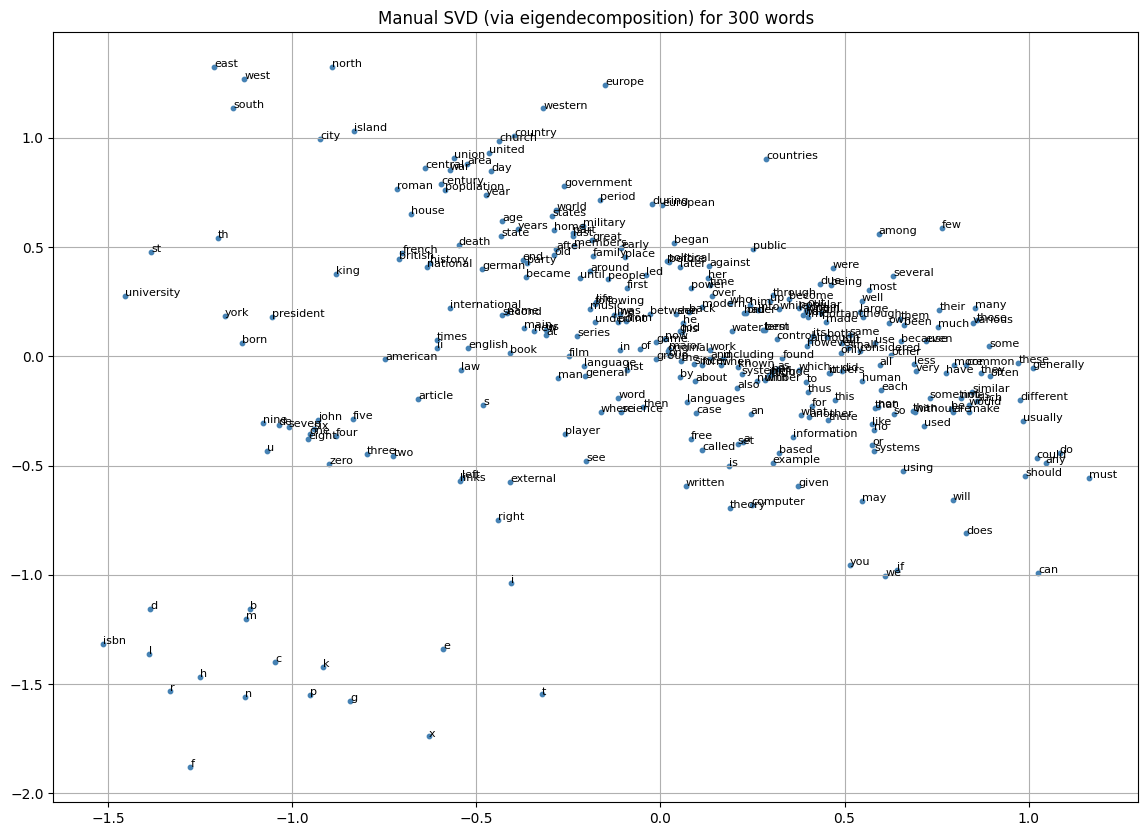

In [ ]:
import matplotlib.pyplot as plt

def manual_svd(W_in, index2word, num_words=300): # Compute Singular Value Decomposition using Eigen Values
  x = W_in.data[:num_words].detach().cpu().numpy()
  x_mean = np.mean(x, axis =0)
  x_centred = x- x_mean
  cov = np.dot(x_centred.T, x_centred) / x_centred.shape[0] # Dot product (Cosine Sim)
  eigval, eigvec = np.linalg.eigh(cov)
  idx = np.argsort(eigval)[::-1] # Sort eigenvalues in descending order to get the indices of the top components.
  top2 = eigvec[:,idx[:2]]
  x_2d = np.dot(x_centred, top2) # Project points to 2d space
  plt.figure(figsize=(14, 10))
  for i in range(num_words):
      x, y = x_2d[i, 0], x_2d[i, 1]
      plt.scatter(x, y, color='steelblue', s=10)
      plt.text(x, y, index2word[i], fontsize=8)
  plt.title(f"Manual SVD (via eigendecomposition) for {num_words} words")
  plt.grid(True)
  plt.show()

manual_svd(in_embed, int_to_vocab)

### Embedding Dimension = 150, Window Size = 2, Negative Sample = 5

In [ ]:
embedding_dim = 150
window_sizes = 2
num_negative_samples = 5
n_vocab = len(vocab_to_int)

# Embedding Layer
in_embed = nn.Parameter(torch.empty(n_vocab, embedding_dim))
out_embed = nn.Parameter(torch.empty(n_vocab, embedding_dim))

# Weigh initialization
nn.init.uniform_(in_embed, -1, 1)
nn.init.uniform_(out_embed, -1, 1)

in_embed.data = in_embed.data.to(device)
out_embed.data = out_embed.data.to(device)

freq_ratio = {word: count / len(vocab_to_int) for word, count in freq.items()}
freq_ratio = np.array(sorted(freq_ratio.values(), reverse=True))
unigram_dist = freq_ratio / freq_ratio.sum()
neg_dist = torch.from_numpy(unigram_dist**0.75 / np.sum(unigram_dist**0.75)).to(device)

optimizer = optim.Adam([in_embed, out_embed], lr=0.003)

# Training
train_skipgram(in_embed, out_embed, neg_dist, int_words,
            num_negative_samples=num_negative_samples, batch_sz=512, num_epochs=5,
            word_to_index=vocab_to_int, index_to_word=int_to_vocab, window_sz = window_sizes)

Epoch 1/5: 100%|██████████| 32580/32580 [06:01<00:00, 90.11it/s, loss=2.1091]


Epoch 1/5 - Average Loss: 2.5510


Epoch 2/5: 100%|██████████| 32580/32580 [06:00<00:00, 90.32it/s, loss=2.0728]


Epoch 2/5 - Average Loss: 2.1908


Epoch 3/5: 100%|██████████| 32580/32580 [06:00<00:00, 90.48it/s, loss=2.0874]


Epoch 3/5 - Average Loss: 2.1628


Epoch 4/5: 100%|██████████| 32580/32580 [06:00<00:00, 90.42it/s, loss=2.0603]


Epoch 4/5 - Average Loss: 2.1403


Epoch 5/5: 100%|██████████| 32580/32580 [06:00<00:00, 90.34it/s, loss=2.0099]

Epoch 5/5 - Average Loss: 2.1247
often | sometimes, generally, usually, commonly, typically
six | four, eight, five, seven, three
have | had, has, are, be, include
will | would, must, could, should, can
is | was, has, are, makes, contains
may | can, would, might, could, should
united | states, senate, us, kingdom, joined
system | systems, network, unit, device, mode
san | francisco, california, antonio, diego, santiago
test | tests, testing, match, nuclear, cricket
egypt | syria, persia, ethiopia, iraq, greece
event | extinction, events, explosion, phenomenon, insurrection
resources | resource, applications, information, libraries, web
notes | note, curly, songs, articles, paper
applied | used, referred, attributed, referring, transferred
assembly | legislative, council, committee, legislature, unicameral


In [ ]:
print("Words similar to 'king':", ", ".join(similar_words("king", in_embed, vocab_to_int, int_to_vocab)))
print("Words similar to 'queen':", ", ".join(similar_words("queen", in_embed, vocab_to_int, int_to_vocab)))
print("Words similar to 'computer':", ", ".join(similar_words("computer", in_embed, vocab_to_int, int_to_vocab)))
print("Words similar to 'happy':", ", ".join(similar_words("happy", in_embed, vocab_to_int, int_to_vocab)))
print("Words similar to 'government':", ", ".join(similar_words("government", in_embed, vocab_to_int, int_to_vocab)))
print()
print("Analogy 'king' - 'man' + 'woman':", ", ".join(get_analogy("king", "man", "woman", in_embed, vocab_to_int, int_to_vocab)))
print("Analogy 'paris' - 'france' + 'italy':", ", ".join(get_analogy("paris", "france", "italy", in_embed, vocab_to_int, int_to_vocab)))
print("Analogy 'big' - 'small' + 'tiny':", ", ".join(get_analogy("big", "small", "tiny", in_embed, vocab_to_int, int_to_vocab)))
print("Analogy 'walking' - 'walk' + 'swimming':", ", ".join(get_analogy("walking", "walk", "swimming", in_embed, vocab_to_int, int_to_vocab)))
print("Analogy 'man' - 'boy' + 'girl':", ", ".join(get_analogy("man", "boy", "girl", in_embed, vocab_to_int, int_to_vocab)))

Words similar to 'king': prince, son, queen, iii, kings, emperor
Words similar to 'queen': elizabeth, king, consort, mary, prince, duke
Words similar to 'computer': computers, pc, computing, technology, software, graphics
Words similar to 'happy': silent, comfortable, funny, dear, glorious, loved
Words similar to 'government': governments, parliament, regime, administration, cabinet, federal

Analogy 'king' - 'man' + 'woman': queen, son, prince, daughter, wife
Analogy 'paris' - 'france' + 'italy': rome, venice, vienna, berlin, bologna
Analogy 'big' - 'small' + 'tiny': kid, hilton, liz, floyd, byrne
Analogy 'walking' - 'walk' + 'swimming': freestyle, sport, outdoor, cycling, skiing
Analogy 'man' - 'boy' + 'girl': woman, baby, drink, corpses, gal


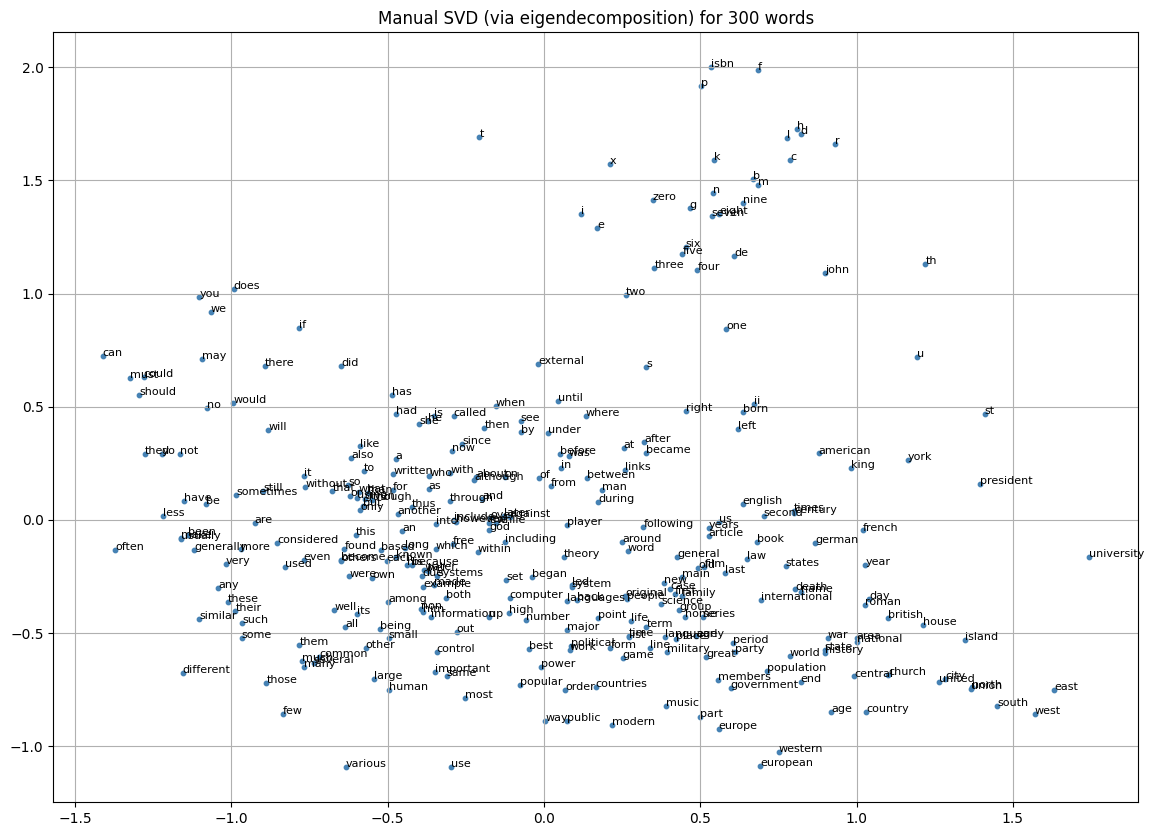

In [ ]:
# plot
manual_svd(in_embed, int_to_vocab)

### Embedding Dimension = 150, Window Size = 5, Negative Sample = 5

In [ ]:
window_sizes = 5
num_negative_samples = 5
embedding_dim = 150
n_vocab = len(vocab_to_int)

# Embedding Layer
in_embed = nn.Parameter(torch.empty(n_vocab, embedding_dim))
out_embed = nn.Parameter(torch.empty(n_vocab, embedding_dim))

# Weight Initialization
nn.init.uniform_(in_embed, -1, 1)
nn.init.uniform_(out_embed, -1, 1)

in_embed.data = in_embed.data.to(device)
out_embed.data = out_embed.data.to(device)

freq_ratio = {word: count / len(vocab_to_int) for word, count in freq.items()}
freq_ratio = np.array(sorted(freq_ratio.values(), reverse=True))
unigram_dist = freq_ratio / freq_ratio.sum()
neg_dist = torch.from_numpy(unigram_dist**0.75 / np.sum(unigram_dist**0.75)).to(device)

optimizer = optim.Adam([in_embed, out_embed], lr=0.003)

# Training
train_skipgram(in_embed, out_embed, neg_dist, int_words,
            num_negative_samples=num_negative_samples, batch_sz=512, num_epochs=5,
            word_to_index=vocab_to_int, index_to_word=int_to_vocab, window_sz = window_sizes)

Epoch 1/5: 100%|██████████| 32580/32580 [06:27<00:00, 84.17it/s, loss=2.2822]


Epoch 1/5 - Average Loss: 2.6066


Epoch 2/5: 100%|██████████| 32580/32580 [06:26<00:00, 84.35it/s, loss=2.2809]


Epoch 2/5 - Average Loss: 2.3390


Epoch 3/5: 100%|██████████| 32580/32580 [06:27<00:00, 84.16it/s, loss=2.2818]


Epoch 3/5 - Average Loss: 2.3143


Epoch 4/5: 100%|██████████| 32580/32580 [06:28<00:00, 83.84it/s, loss=2.2521]


Epoch 4/5 - Average Loss: 2.3053


Epoch 5/5: 100%|██████████| 32580/32580 [06:25<00:00, 84.50it/s, loss=2.2145]

Epoch 5/5 - Average Loss: 2.3043
up | out, off, down, back, together
where | then, which, when, also, if
most | particularly, many, more, among, some
more | less, than, rather, most, very
many | some, several, various, these, other
nine | eight, seven, one, six, five
eight | six, seven, four, nine, five
such | well, other, include, some, many
accepted | rejected, recognized, recognised, regarded, acknowledged
road | railway, roads, rail, ferry, routes
proposed | devised, suggested, introduced, adopted, postulated
stage | broadway, screen, performer, theatre, improvisational
test | testing, tests, match, tested, cricket
magazine | magazines, weekly, interview, news, fan
engine | engines, piston, turbine, jet, combustion
troops | forces, army, armies, soldiers, invasion


In [ ]:
print("Words similar to 'king':", ", ".join(similar_words("king", in_embed, vocab_to_int, int_to_vocab)))
print("Words similar to 'queen':", ", ".join(similar_words("queen", in_embed, vocab_to_int, int_to_vocab)))
print("Words similar to 'computer':", ", ".join(similar_words("computer", in_embed, vocab_to_int, int_to_vocab)))
print("Words similar to 'happy':", ", ".join(similar_words("happy", in_embed, vocab_to_int, int_to_vocab)))
print("Words similar to 'government':", ", ".join(similar_words("government", in_embed, vocab_to_int, int_to_vocab)))
print()
print("Analogy 'king' - 'man' + 'woman':", ", ".join(get_analogy("king", "man", "woman", in_embed, vocab_to_int, int_to_vocab)))
print("Analogy 'paris' - 'france' + 'italy':", ", ".join(get_analogy("paris", "france", "italy", in_embed, vocab_to_int, int_to_vocab)))
print("Analogy 'big' - 'small' + 'tiny':", ", ".join(get_analogy("big", "small", "tiny", in_embed, vocab_to_int, int_to_vocab)))
print("Analogy 'walking' - 'walk' + 'swimming':", ", ".join(get_analogy("walking", "walk", "swimming", in_embed, vocab_to_int, int_to_vocab)))
print("Analogy 'man' - 'boy' + 'girl':", ", ".join(get_analogy("man", "boy", "girl", in_embed, vocab_to_int, int_to_vocab)))

Words similar to 'king': son, iii, prince, kings, queen, father
Words similar to 'queen': elizabeth, mary, princess, lady, consort, scotland
Words similar to 'computer': computers, software, pc, hardware, technology, computing
Words similar to 'happy': merry, sunny, incredibly, frightening, want, sing
Words similar to 'government': governments, federal, administration, regime, parliament, party

Analogy 'king' - 'man' + 'woman': wife, husband, son, queen, daughter
Analogy 'paris' - 'france' + 'italy': venice, bologna, rome, milan, munich
Analogy 'big' - 'small' + 'tiny': monkey, frog, tiger, whale, jaws
Analogy 'walking' - 'walk' + 'swimming': skiing, outdoor, skating, climbing, biking
Analogy 'man' - 'boy' + 'girl': woman, love, drunks, men, flesh


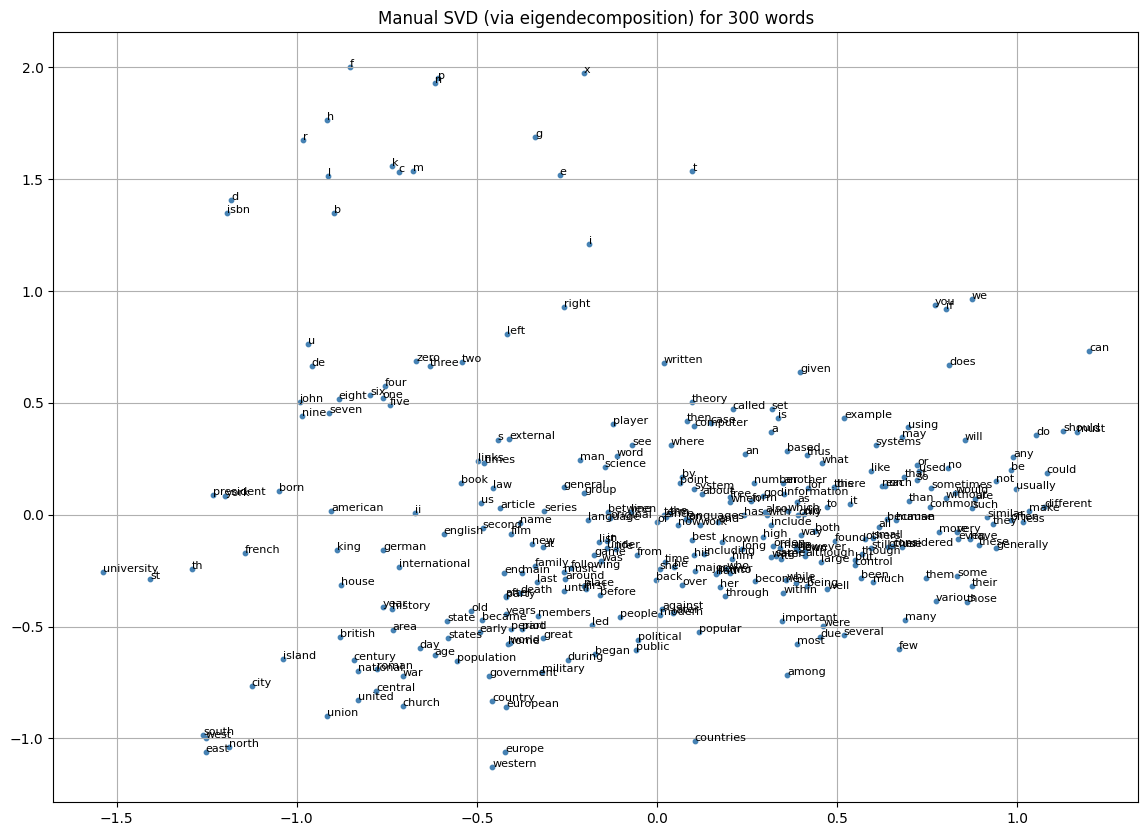

In [ ]:
# Plot
manual_svd(in_embed, int_to_vocab)

### Embedding Dimension = 150, Window Size = 2, Negative Sample = 10

In [ ]:
embedding_dim = 150
window_sizes = 2
num_negative_samples = 10
n_vocab = len(vocab_to_int)

# Embedding Layer
in_embed = nn.Parameter(torch.empty(n_vocab, embedding_dim))
out_embed = nn.Parameter(torch.empty(n_vocab, embedding_dim))

# Weight Initialization
nn.init.uniform_(in_embed, -1, 1)
nn.init.uniform_(out_embed, -1, 1)

in_embed.data = in_embed.data.to(device)
out_embed.data = out_embed.data.to(device)

freq_ratio = {word: count / len(vocab_to_int) for word, count in freq.items()}
freq_ratio = np.array(sorted(freq_ratio.values(), reverse=True))
unigram_dist = freq_ratio / freq_ratio.sum()
neg_dist = torch.from_numpy(unigram_dist**0.75 / np.sum(unigram_dist**0.75)).to(device)

optimizer = optim.Adam([in_embed, out_embed], lr=0.003)

# Train
train_skipgram(in_embed, out_embed, neg_dist, int_words,
            num_negative_samples=num_negative_samples, batch_sz=512, num_epochs=5,
            word_to_index=vocab_to_int, index_to_word=int_to_vocab, window_sz = window_sizes)

Epoch 1/5: 100%|██████████| 32580/32580 [06:04<00:00, 89.33it/s, loss=2.6460]


Epoch 1/5 - Average Loss: 3.2623


Epoch 2/5: 100%|██████████| 32580/32580 [06:03<00:00, 89.52it/s, loss=2.6514]


Epoch 2/5 - Average Loss: 2.7734


Epoch 3/5: 100%|██████████| 32580/32580 [06:04<00:00, 89.47it/s, loss=2.6327]


Epoch 3/5 - Average Loss: 2.7382


Epoch 4/5: 100%|██████████| 32580/32580 [06:03<00:00, 89.57it/s, loss=2.6565]


Epoch 4/5 - Average Loss: 2.7290


Epoch 5/5: 100%|██████████| 32580/32580 [06:05<00:00, 89.20it/s, loss=2.7335]

Epoch 5/5 - Average Loss: 2.7285
all | many, both, various, some, these
first | last, second, third, next, earliest
which | that, also, where, this, what
system | systems, process, program, hfs, scheme
its | their, his, the, her, your
see | external, references, list, include, refer
such | well, these, many, other, including
as | like, including, became, also, such
defense | defence, justice, security, conscription, secretariat
mathematics | mathematical, geometry, linguistics, philosophy, physics
marriage | marriages, homosexual, divorce, bisexuality, polygamy
gold | silver, nickel, leather, platinum, copper
hit | hits, struck, shot, success, blow
universe | phenomenon, comics, galaxy, reality, multiverse
brother | son, father, wife, sister, uncle
smith | lee, williams, nelson, richardson, clark


In [ ]:
print("Words similar to 'king':", ", ".join(similar_words("king", in_embed, vocab_to_int, int_to_vocab)))
print("Words similar to 'queen':", ", ".join(similar_words("queen", in_embed, vocab_to_int, int_to_vocab)))
print("Words similar to 'computer':", ", ".join(similar_words("computer", in_embed, vocab_to_int, int_to_vocab)))
print("Words similar to 'happy':", ", ".join(similar_words("happy", in_embed, vocab_to_int, int_to_vocab)))
print("Words similar to 'government':", ", ".join(similar_words("government", in_embed, vocab_to_int, int_to_vocab)))
print()
print("Analogy 'king' - 'man' + 'woman':", ", ".join(get_analogy("king", "man", "woman", in_embed, vocab_to_int, int_to_vocab)))
print("Analogy 'paris' - 'france' + 'italy':", ", ".join(get_analogy("paris", "france", "italy", in_embed, vocab_to_int, int_to_vocab)))
print("Analogy 'big' - 'small' + 'tiny':", ", ".join(get_analogy("big", "small", "tiny", in_embed, vocab_to_int, int_to_vocab)))
print("Analogy 'walking' - 'walk' + 'swimming':", ", ".join(get_analogy("walking", "walk", "swimming", in_embed, vocab_to_int, int_to_vocab)))
print("Analogy 'man' - 'boy' + 'girl':", ", ".join(get_analogy("man", "boy", "girl", in_embed, vocab_to_int, int_to_vocab)))

Words similar to 'king': son, prince, queen, father, vi, duke
Words similar to 'queen': princess, elizabeth, consort, mary, king, duke
Words similar to 'computer': computers, software, digital, pc, video, console
Words similar to 'happy': dear, confused, unhappy, angry, fun, sorry
Words similar to 'government': governments, parliament, regime, administration, authorities, constitution

Analogy 'king' - 'man' + 'woman': son, queen, children, eldest, mother
Analogy 'paris' - 'france' + 'italy': venice, rome, bologna, milan, zurich
Analogy 'big' - 'small' + 'tiny': monkey, smash, sampler, casey, great
Analogy 'walking' - 'walk' + 'swimming': rowing, bike, camping, freestyle, climbing
Analogy 'man' - 'boy' + 'girl': woman, men, person, dog, persons


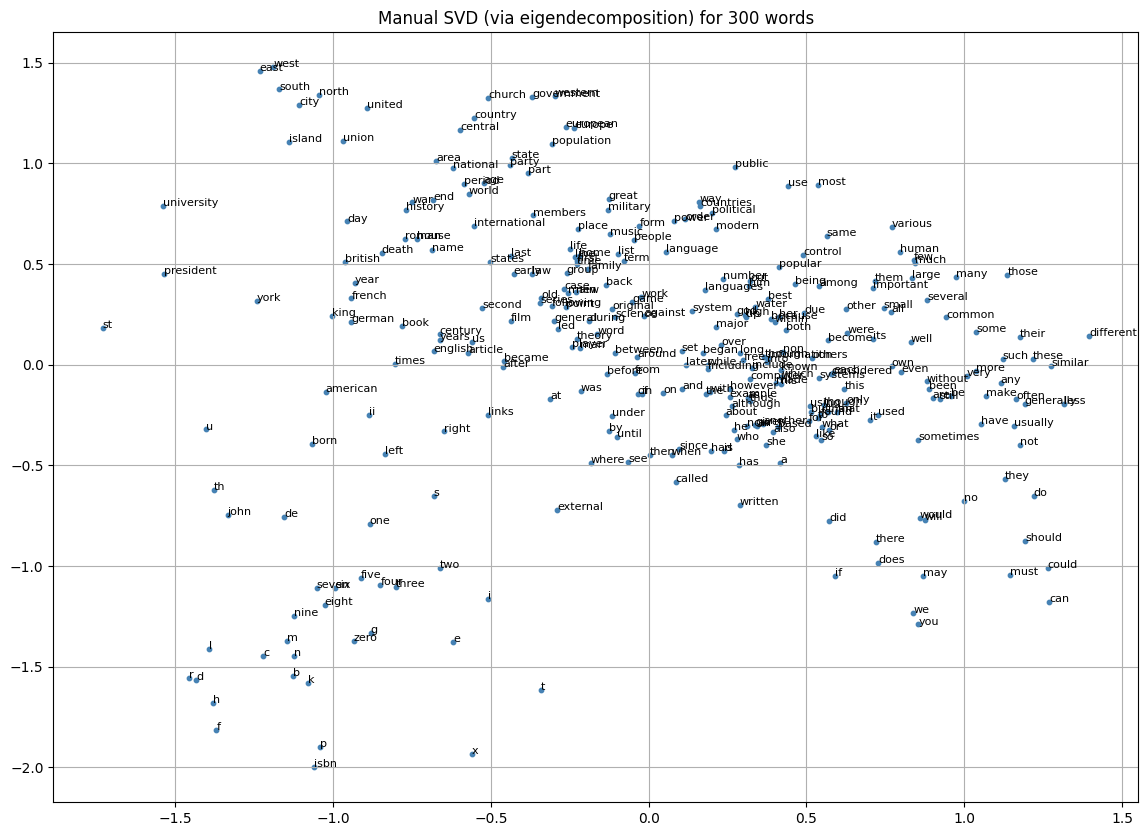

In [ ]:
# Plot
manual_svd(in_embed, int_to_vocab)

### Embedding Dimension = 150, Window Size = 5, Negative Sample = 10

In [ ]:
embedding_dim = 150
window_sizes = 5
num_negative_samples = 10
n_vocab = len(vocab_to_int)

# Embedding Layer
in_embed = nn.Parameter(torch.empty(n_vocab, embedding_dim))
out_embed = nn.Parameter(torch.empty(n_vocab, embedding_dim))

# Weight Initialization
nn.init.uniform_(in_embed, -1, 1)
nn.init.uniform_(out_embed, -1, 1)
in_embed.data = in_embed.data.to(device)
out_embed.data = out_embed.data.to(device)

freq_ratio = {word: count / len(vocab_to_int) for word, count in freq.items()}
freq_ratio = np.array(sorted(freq_ratio.values(), reverse=True))
unigram_dist = freq_ratio / freq_ratio.sum()
neg_dist = torch.from_numpy(unigram_dist**0.75 / np.sum(unigram_dist**0.75)).to(device)

optimizer = optim.Adam([in_embed, out_embed], lr=0.003)

# Training
train_skipgram(in_embed, out_embed, neg_dist, int_words,
            num_negative_samples=num_negative_samples, batch_sz=512, num_epochs=5,
            word_to_index=vocab_to_int, index_to_word=int_to_vocab, window_sz = window_sizes)

Epoch 1/5: 100%|██████████| 32580/32580 [06:37<00:00, 81.87it/s, loss=2.9199]


Epoch 1/5 - Average Loss: 3.3343


Epoch 2/5: 100%|██████████| 32580/32580 [06:37<00:00, 82.06it/s, loss=2.8830]


Epoch 2/5 - Average Loss: 2.9549


Epoch 3/5: 100%|██████████| 32580/32580 [06:39<00:00, 81.61it/s, loss=2.8789]


Epoch 3/5 - Average Loss: 2.9420


Epoch 4/5: 100%|██████████| 32580/32580 [06:38<00:00, 81.77it/s, loss=2.9048]


Epoch 4/5 - Average Loss: 2.9272


Epoch 5/5: 100%|██████████| 32580/32580 [06:38<00:00, 81.78it/s, loss=2.7950]

Epoch 5/5 - Average Loss: 2.9174
than | more, less, slightly, rather, much
there | no, longer, but, however, exists
this | another, it, that, however, which
see | external, links, list, references, uses
most | many, some, more, particularly, among
over | around, about, out, across, during
after | before, shortly, during, until, following
time | period, moment, during, decade, same
ocean | atlantic, pacific, sea, oceans, indian
issue | question, situation, option, dispute, case
defense | defence, israeli, security, force, forces
engine | engines, piston, turbine, steam, powered
test | testing, tests, nuclear, match, bomb
existence | nature, reality, universe, concept, proof
derived | derives, derive, borrowed, comes, stems
operations | operation, missions, functions, tasks, personnel


In [ ]:
print("Words similar to 'king':", ", ".join(similar_words("king", in_embed, vocab_to_int, int_to_vocab)))
print("Words similar to 'queen':", ", ".join(similar_words("queen", in_embed, vocab_to_int, int_to_vocab)))
print("Words similar to 'computer':", ", ".join(similar_words("computer", in_embed, vocab_to_int, int_to_vocab)))
print("Words similar to 'happy':", ", ".join(similar_words("happy", in_embed, vocab_to_int, int_to_vocab)))
print("Words similar to 'government':", ", ".join(similar_words("government", in_embed, vocab_to_int, int_to_vocab)))
print()
print("Analogy 'king' - 'man' + 'woman':", ", ".join(get_analogy("king", "man", "woman", in_embed, vocab_to_int, int_to_vocab)))
print("Analogy 'paris' - 'france' + 'italy':", ", ".join(get_analogy("paris", "france", "italy", in_embed, vocab_to_int, int_to_vocab)))
print("Analogy 'big' - 'small' + 'tiny':", ", ".join(get_analogy("big", "small", "tiny", in_embed, vocab_to_int, int_to_vocab)))
print("Analogy 'walking' - 'walk' + 'swimming':", ", ".join(get_analogy("walking", "walk", "swimming", in_embed, vocab_to_int, int_to_vocab)))
print("Analogy 'man' - 'boy' + 'girl':", ", ".join(get_analogy("man", "boy", "girl", in_embed, vocab_to_int, int_to_vocab)))

Words similar to 'king': son, iii, queen, vi, father, vii
Words similar to 'queen': elizabeth, princess, consort, king, mary, lady
Words similar to 'computer': computers, software, graphics, hardware, computing, video
Words similar to 'happy': crazy, sing, quiet, guys, feel, lonesome
Words similar to 'government': governments, parliament, cabinet, administration, regime, minister

Analogy 'king' - 'man' + 'woman': queen, son, daughter, wife, elizabeth
Analogy 'paris' - 'france' + 'italy': rome, bologna, venice, madrid, milan
Analogy 'big' - 'small' + 'tiny': floyd, mighty, spit, bang, frog
Analogy 'walking' - 'walk' + 'swimming': diving, camping, rowing, fishing, recreation
Analogy 'man' - 'boy' + 'girl': woman, lady, men, people, story


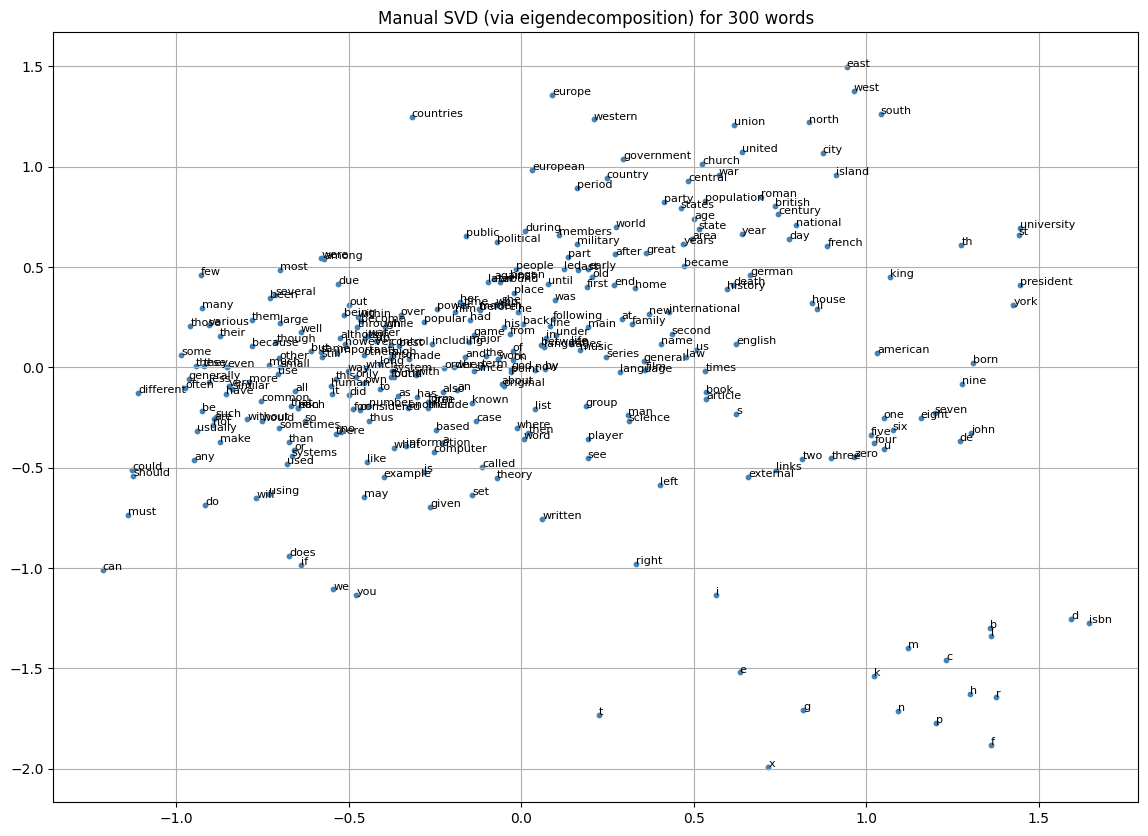

In [ ]:
# plot
manual_svd(in_embed, int_to_vocab)

### Embedding Dimension = 300, Window Size = 5, Negative Sample = 5, Trimmed Word Frequency = 10

In [ ]:
train_skipgram(in_embed, out_embed, neg_dist, int_words,
               num_negative_samples=5, batch_sz=512, num_epochs=5,
               word_to_index=vocab_to_int, index_to_word=int_to_vocab)

Epoch 1/5: 100%|██████████| 32297/32297 [08:17<00:00, 64.86it/s, loss=2.4290]


Epoch 1/5 - Average Loss: 2.7833


Epoch 2/5: 100%|██████████| 32297/32297 [08:19<00:00, 64.62it/s, loss=2.3321]


Epoch 2/5 - Average Loss: 2.3541


Epoch 3/5: 100%|██████████| 32297/32297 [08:20<00:00, 64.47it/s, loss=2.3342]


Epoch 3/5 - Average Loss: 2.3237


Epoch 4/5: 100%|██████████| 32297/32297 [08:23<00:00, 64.19it/s, loss=2.2625]


Epoch 4/5 - Average Loss: 2.3084


Epoch 5/5: 100%|██████████| 32297/32297 [08:22<00:00, 64.27it/s, loss=2.3043]


Epoch 5/5 - Average Loss: 2.3003
three | four, two, five, six, seven
who | whom, while, he, him, that
states | united, kingdom, state, nations, u
or | and, such, either, any, can
seven | six, eight, five, four, nine
a | the, another, this, is, or
such | well, other, these, some, many
state | states, territory, government, legislature, michigan
creation | development, emergence, nature, interactive, founding
placed | put, held, built, shown, laid
older | younger, average, previous, newer, below
square | hotel, cubic, park, trafalgar, cemetery
universe | character, ultimate, characters, existence, cosmological
dr | robert, martin, frank, scott, peter
issue | question, consideration, issued, case, issues
road | railway, rail, traffic, roads, street


In [ ]:
print("Words similar to 'king':", ", ".join(similar_words("king", in_embed, vocab_to_int, int_to_vocab)))
print("Words similar to 'queen':", ", ".join(similar_words("queen", in_embed, vocab_to_int, int_to_vocab)))
print("Words similar to 'computer':", ", ".join(similar_words("computer", in_embed, vocab_to_int, int_to_vocab)))
print("Words similar to 'happy':", ", ".join(similar_words("happy", in_embed, vocab_to_int, int_to_vocab)))
print("Words similar to 'government':", ", ".join(similar_words("government", in_embed, vocab_to_int, int_to_vocab)))
print()
print("Analogy 'king' - 'man' + 'woman':", ", ".join(get_analogy("king", "man", "woman", in_embed, vocab_to_int, int_to_vocab)))
print("Analogy 'paris' - 'france' + 'italy':", ", ".join(get_analogy("paris", "france", "italy", in_embed, vocab_to_int, int_to_vocab)))
print("Analogy 'big' - 'small' + 'tiny':", ", ".join(get_analogy("big", "small", "tiny", in_embed, vocab_to_int, int_to_vocab)))
print("Analogy 'walking' - 'walk' + 'swimming':", ", ".join(get_analogy("walking", "walk", "swimming", in_embed, vocab_to_int, int_to_vocab)))
print("Analogy 'man' - 'boy' + 'girl':", ", ".join(get_analogy("man", "boy", "girl", in_embed, vocab_to_int, int_to_vocab)))

Words similar to 'king': son, queen, henry, reign, vi, iv
Words similar to 'queen': elizabeth, king, mary, consort, lady, scotland
Words similar to 'computer': software, computers, video, computing, ibm, machine
Words similar to 'happy': brady, kids, dear, girls, forever, lampooned
Words similar to 'government': governments, parliament, administration, policy, republic, cabinet

Analogy 'king' - 'man' + 'woman': son, queen, mary, daughter, reign
Analogy 'paris' - 'france' + 'italy': vienna, venice, bologna, exile, milan
Analogy 'big' - 'small' + 'tiny': sock, boss, black, laine, hardcore
Analogy 'walking' - 'walk' + 'swimming': diving, boat, outdoor, skiing, drinking
Analogy 'man' - 'boy' + 'girl': men, characters, deluded, sauce, hoaxes


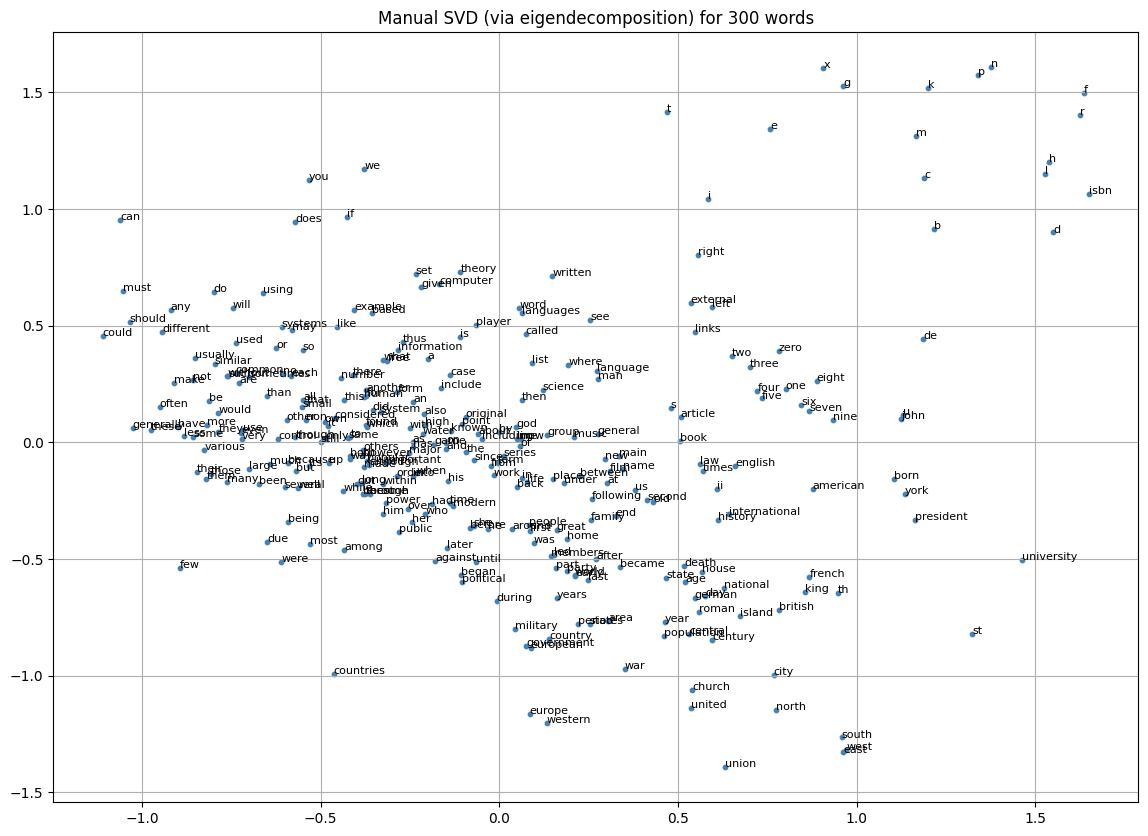

In [ ]:
import matplotlib.pyplot as plt

def manual_svd(W_in, index2word, num_words=300):
  x = W_in.data[:num_words].detach().cpu().numpy()
  x_mean = np.mean(x, axis =0)
  x_centred = x- x_mean
  cov = np.dot(x_centred.T, x_centred) / x_centred.shape[0]
  eigval, eigvec = np.linalg.eigh(cov)
  idx = np.argsort(eigval)[::-1]
  top2 = eigvec[:,idx[:2]]
  x_2d = np.dot(x_centred, top2)
  plt.figure(figsize=(14, 10))
  for i in range(num_words):
      x, y = x_2d[i, 0], x_2d[i, 1]
      plt.scatter(x, y, color='steelblue', s=10)
      plt.text(x, y, index2word[i], fontsize=8)
  plt.title(f"Manual SVD (via eigendecomposition) for {num_words} words")
  plt.grid(True)
  plt.show()

manual_svd(in_embed, int_to_vocab)

### Observations
Tried different configurations modifying embedding dimension, negative sample size and window size. 5 similarity word cases and 5 cases of analogy were tested.

Trimmed words of words of frequency < 5


 1. Embedding dim = 300, window size =5, negative sample = 5 -> loss = 2.2896
   * Similar word:
            * king: son, queen: elizabeth, computer : hardware
    * Analogy words:
            * King - man+ woman didn't give queen as output.
            * Paris - france + italy gave rome as output.

2. Embedding dim = 150, window size =2, negative sample = 5 -> loss = 2.1403
    * Similar word:
             * king: prince, queen elizabeth, computer : computers
    * Analogy words:
            * King-man+ woman gave queen as 1st choice.
            * Paris - france + italy gave rome as 1st choice.
3. Embedding dim = 150, window size =5, negative sample = 5 -> loss = 2.3053
    * Similar word:
            * king: son, queen elizabeth, computer : computers
    * Analogy words:
            * King-man+ woman  gave queen as 4th choice.
            * Paris - france + italy gave rome as 3rd choice.
4. Embedding dim = 150, window size =2, negative sample = 10 -> loss = 2.7290
    * Similar word:
            * king: son, queen: princess, computer : computers
    * Analogy words:
            * King-man+ woman gave queen as 2nd choice.
            * Paris - france + italy gave rome as 2nd choice
5. Embedding dim = 150, window size =5, negative sample = 10 -> loss = 2.9272
    *Similar word:
            * king: son, queen elizabeth, computer : computers
    *Analogy words:
            * King-man+ woman gave queen as 1st choice.
            * Paris - france + italy gave rome as 1st choice
6. Embedding dim = 300, window size =5, negative sample = 5-> loss = 2.3003
Trimmed words of frequency < 10
    * Similar word:
            * king: son, queen elizabeth, computer : software
    * Analogy words:
            * King-man+ woman  gave queen as 2nd option.
            * Paris - france + italy didn't give rome as output.

* Observed better performance with an embedding dimension of 150. Increasing to 300 didn't bring much significant improvement.
* Window size of 5 gave better result than size 2. As more context words are included, learned representations performed better.
* When negative sample size was 10 it gave better results than with 5. Increasing the number of negative samples for gradient updation improved the learning process of embeddings.
* When words of frequency less than 10 were removed performance dropped drastically. Setting this frequency to a number around 5 was optimum.

* Thus the best parameter settings observed are window size =5, embedding sim = 150, negative sample size = 10.









# Q2 - Vision Transformer

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import math
import random
import numpy as np
import cv2

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

### Arch

In [ ]:
# to split image into patches
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=128):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2 # image_size / patch_size * image_size / patch_size
        self.conv = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.conv(x)              # [batch_size, embed_dim, H/patch_size, W/patch_size]
        x = x.flatten(2)              # [batch_size, embed_dim, num_patches]
        x = x.transpose(1, 2)
        # [batch_size, num_patches, embed_dim]
        return x

In [ ]:
class CustomMultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1, bias=False):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads # Embedding dimension must be divisible by number of heads


        self.W_q = nn.Linear(embed_dim, embed_dim, bias=bias) # query
        self.W_k = nn.Linear(embed_dim, embed_dim, bias=bias) # key
        self.W_v = nn.Linear(embed_dim, embed_dim, bias=bias) # value
        self.W_o = nn.Linear(embed_dim, embed_dim, bias=bias)

        self.dropout = nn.Dropout(dropout) # for regularisation

    def forward(self, x):
        B, N, C = x.shape

        q = self.W_q(x)  # [batch_size, N, embed_dim]
        k = self.W_k(x)
        v = self.W_v(x)

        # quick rearrange to [batch_size, num_heads, N, head_dim]
        q = q.view(B, N, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        k = k.view(B, N, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v = v.view(B, N, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        # attention = softmax(Q.K/sqrt(head_dim))V
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights) # regularization
        attn_output = torch.matmul(attn_weights, v)

        # revert re-arrangement
        attn_output = attn_output.permute(0, 2, 1, 3).contiguous().view(B, N, C)

        output = self.W_o(attn_output)
        return output, attn_weights

In [ ]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        # mlp_ratio helps to scale the hidden layer
        super().__init__()

        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = CustomMultiHeadSelfAttention(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)

        # GELU - Non Linear Activation - input * percentile inspired from BERT
        # Minimal MLP
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x_norm = self.norm1(x)
        attn_out, attn_weights = self.attn(x_norm)

        # add attention output to x - residual connection
        x = x + attn_out
        # add mlp output to x - residual connection
        x = x + self.mlp(self.norm2(x))
        return x, attn_weights

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, num_classes=10, embed_dim=128, depth=6, num_heads=8, mlp_ratio=4.0, dropout=0.1):
        super().__init__()

        # Embedding Layer
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        # added to patch embedding for the classification task at hand
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        # to learn position of patches + 1 for class
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.dropout = nn.Dropout(dropout)

        self.blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_ratio, dropout) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)

        # Classification Layer
        self.head = nn.Linear(embed_dim, num_classes)

        self._init_weights()

    def _init_weights(self):
        nn.init.trunc_normal_(self.pos_embed, std=0.02) # normal distribution for stability and equal importance
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight) # All linear layers given xavier initialization
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0) # Set bias term as 0

    def forward(self, x):
        B = x.shape[0] # batch size
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1) # adjust shape according to batch size
        x = torch.cat((cls_tokens, x), dim=1) # Input with cls_token and patch embedding
        x = x + self.pos_embed
        x = self.dropout(x)
        attn_weights_all = [] # for visualization
        for block in self.blocks:
            x, attn_weights = block(x)
            attn_weights_all.append(attn_weights)
        x = self.norm(x)
        cls_final = x[:, 0] # Extract the classification token
        logits = self.head(cls_final) # Perform classification - Probability
        return logits, attn_weights_all

In [ ]:
def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss, correct = 0.0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device) # offload to gpu
        optimizer.zero_grad() # init 0 grad
        outputs, _ = model(images) # forward prop
        loss = criterion(outputs, labels) # compute cross entropy loss
        loss.backward() # backprop
        optimizer.step()
        total_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(dim=1) == labels).sum().item()
    return total_loss / len(train_loader.dataset), correct / len(train_loader.dataset)

In [ ]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss, correct = 0.0, 0
    with torch.no_grad(): # Restrict Grad calc
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device) # offload to gpu
            outputs, _ = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(dim=1) == labels).sum().item()
    return total_loss / len(test_loader.dataset), correct / len(test_loader.dataset)

In [ ]:
def overlay_attention_on_image(img, attn_map, patch_size=4, alpha=0.5):
    # Extract attention from [CLS] token to image patches)
    cls_attn = attn_map[0, 1:]  # shape: [num_patches] - ignore cls token
    gz = int(np.sqrt(cls_attn.shape[0]))  # 8 x 8 grid

    attn_grid = cls_attn.reshape(gz, gz)

    upsampled = cv2.resize(attn_grid, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_LINEAR)
    # Normalize to [0,1] ignore zero in denominator
    upsampled = (upsampled - upsampled.min()) / (upsampled.max() - upsampled.min() + 1e-8)
    # Create heatmap and blend with image

    heatmap = cv2.applyColorMap(np.uint8(255 * upsampled), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0

    # blend with heatmap
    overlay = (1 - alpha) * img + alpha * heatmap
    overlay = np.clip(overlay, 0, 1)
    return overlay

In [ ]:
def denormalize(img_tensor):
    img_np = img_tensor.detach().cpu().permute(1, 2, 0).numpy()
    img_np = img_np * 0.5 + 0.5  # Reverse normalization for transform
    return img_np

#### Dataset Loading

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform) # Perform Transform
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 48.2MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Hyperparameter Tuning

In [ ]:
configs = [
    {"patch_size": 4, "depth": 6,  "num_heads": 8, "embed_dim": 128},
    {"patch_size": 2, "depth": 6,  "num_heads": 8, "embed_dim": 128},
    {"patch_size": 4, "depth": 12, "num_heads": 8, "embed_dim": 128},  # More layers
    {"patch_size": 4, "depth": 6,  "num_heads": 4, "embed_dim": 128},  # Fewer heads
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = []

----------------------------------------------------
Config: Patch Size 4, Depth 6, Num Heads 8
Epoch 1: Train Loss 1.6855, Train Acc 0.3787
Epoch 2: Train Loss 1.3440, Train Acc 0.5083
Epoch 3: Train Loss 1.2209, Train Acc 0.5550
Epoch 4: Train Loss 1.1422, Train Acc 0.5866
Epoch 5: Train Loss 1.0828, Train Acc 0.6068
Epoch 6: Train Loss 1.0368, Train Acc 0.6259
Epoch 7: Train Loss 0.9872, Train Acc 0.6440
Epoch 8: Train Loss 0.9435, Train Acc 0.6600
Epoch 9: Train Loss 0.9038, Train Acc 0.6746
Epoch 10: Train Loss 0.8667, Train Acc 0.6896
Config Result -> Test Loss: 1.0116, Test Acc: 0.6403


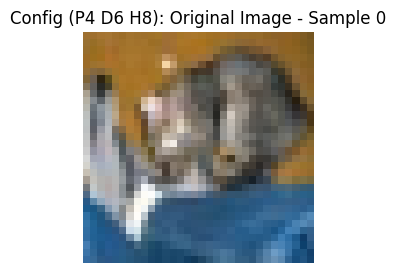

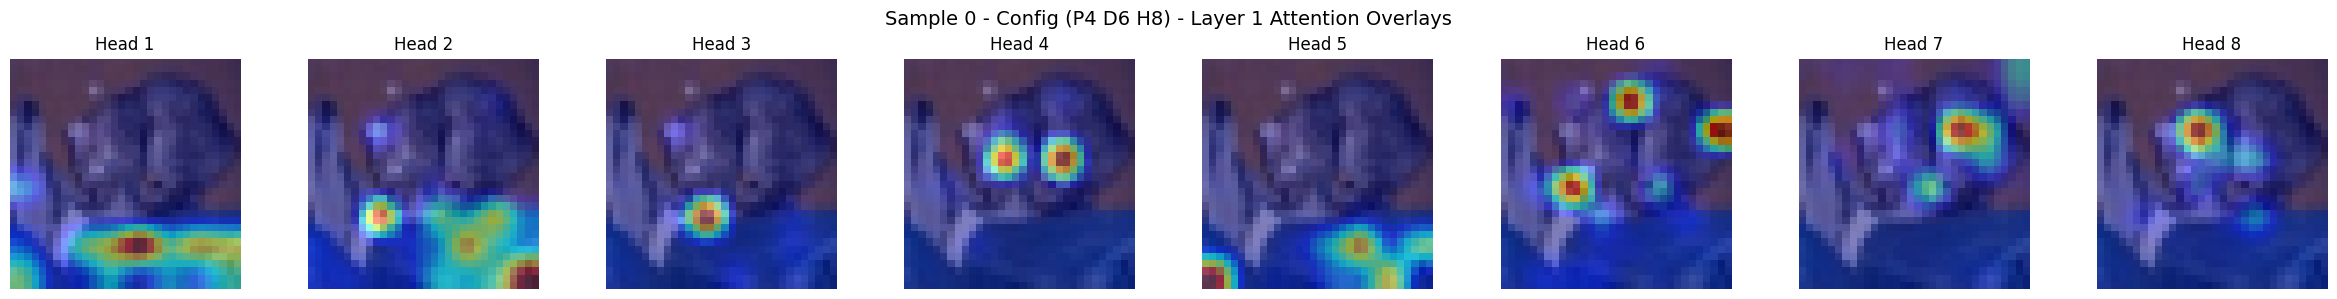

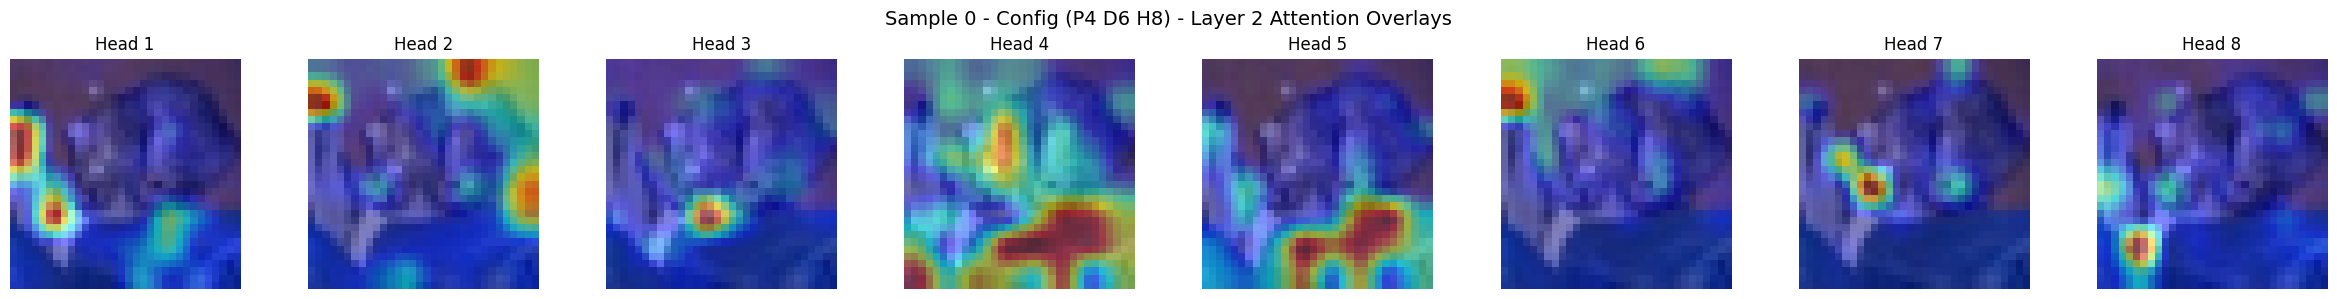

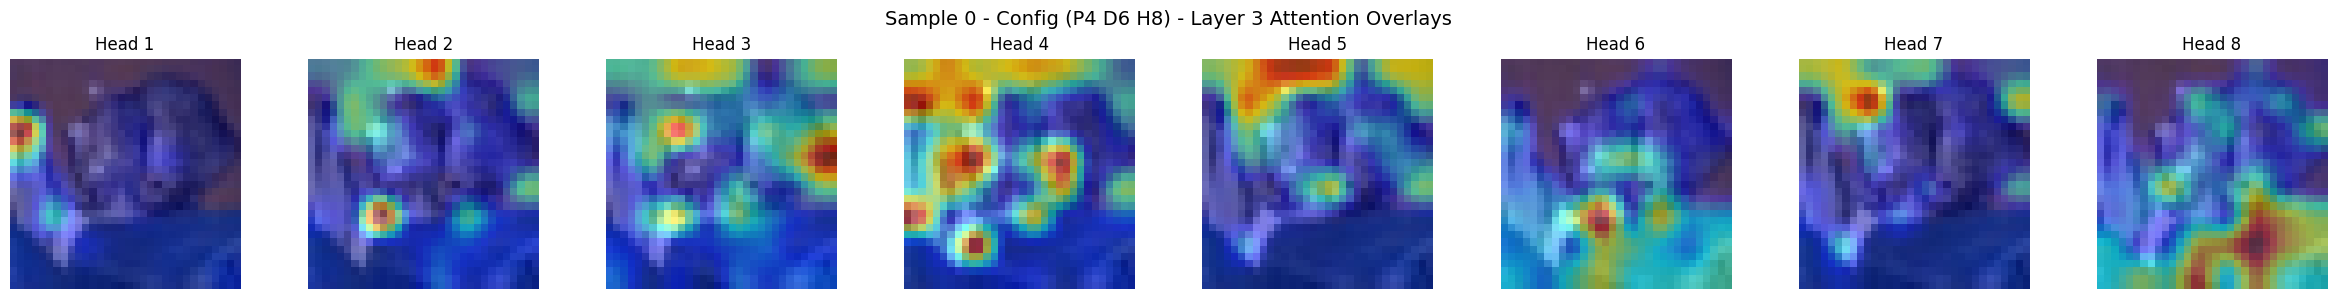

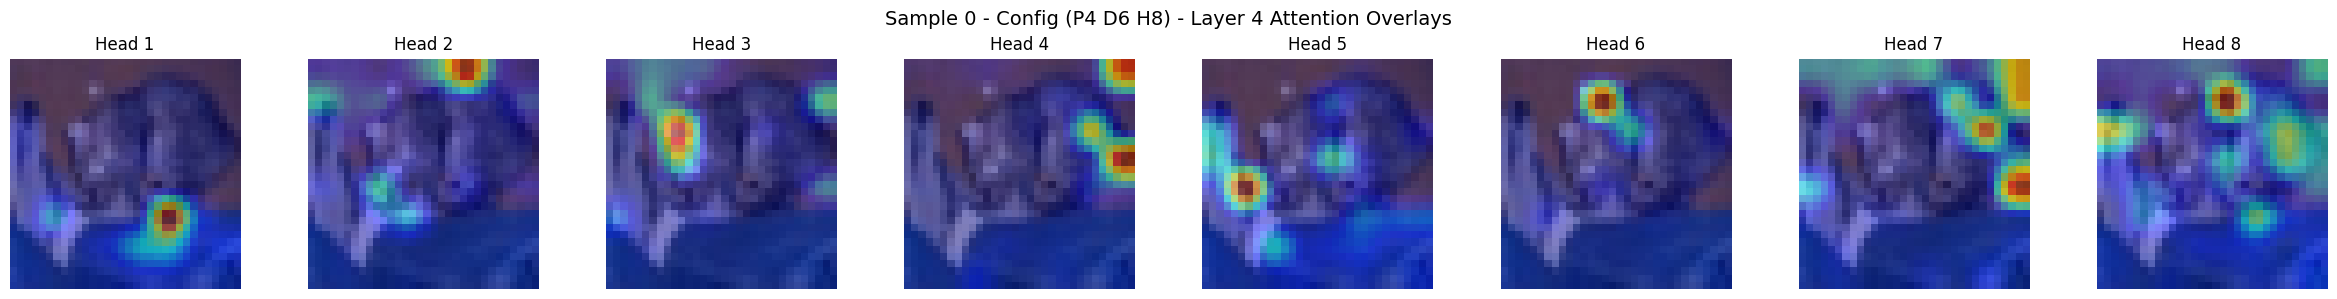

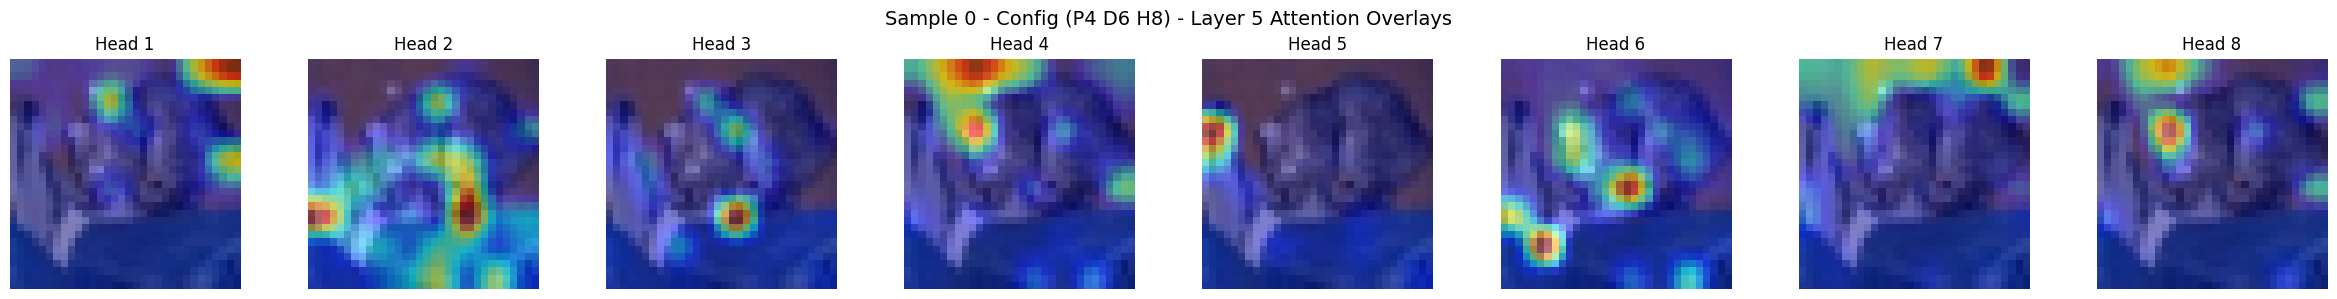

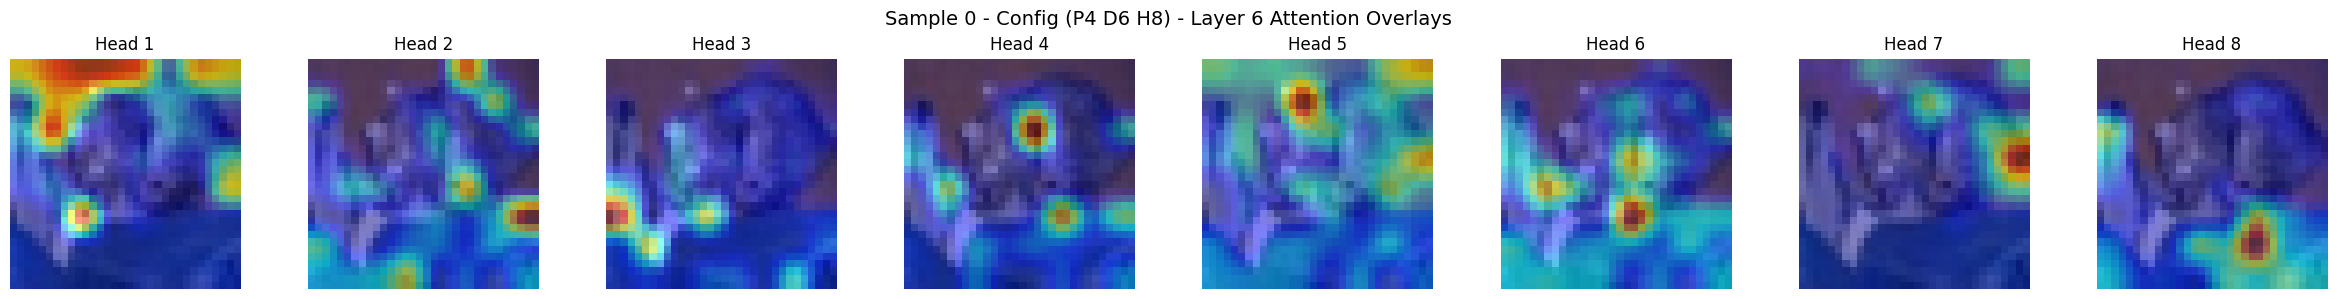

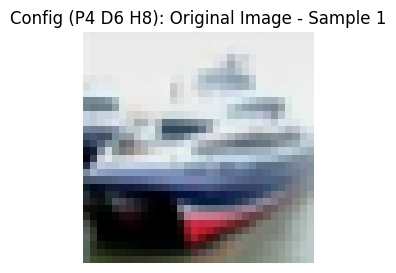

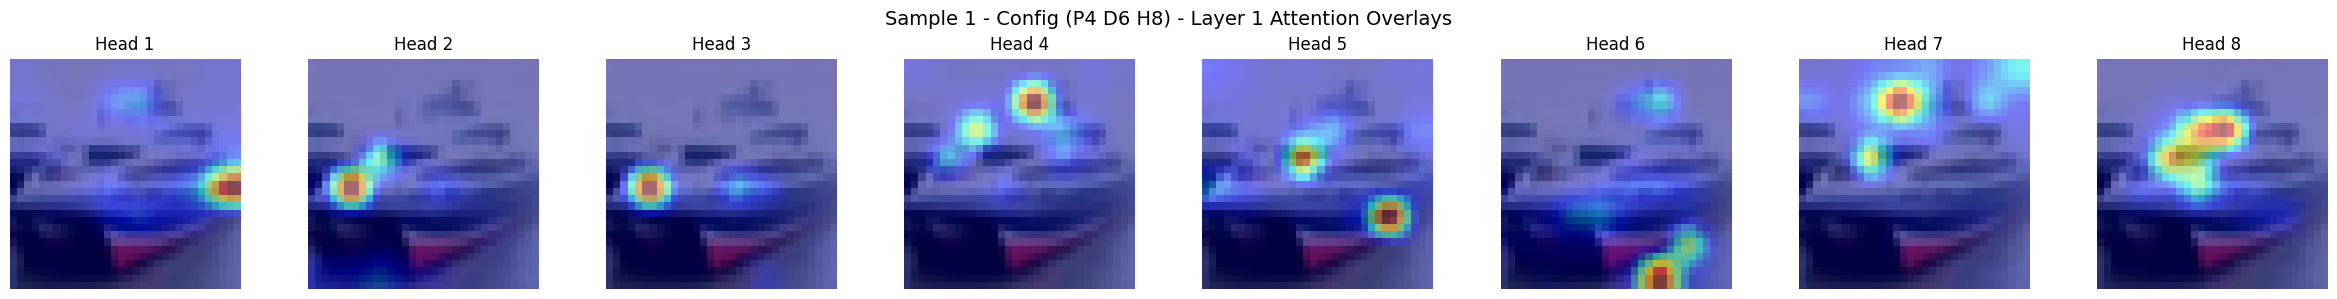

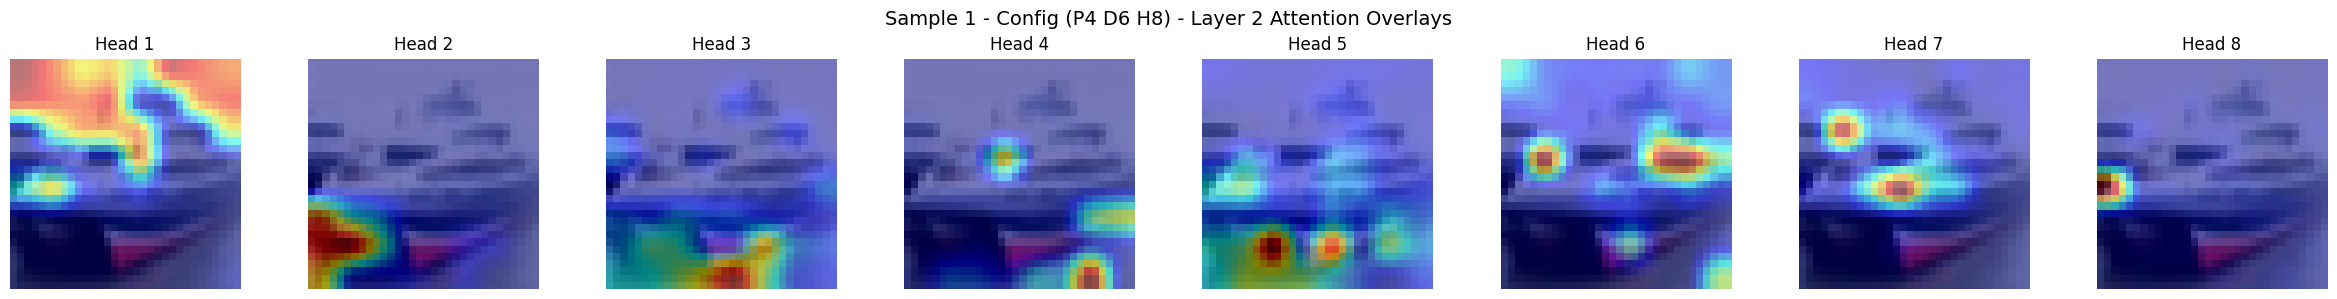

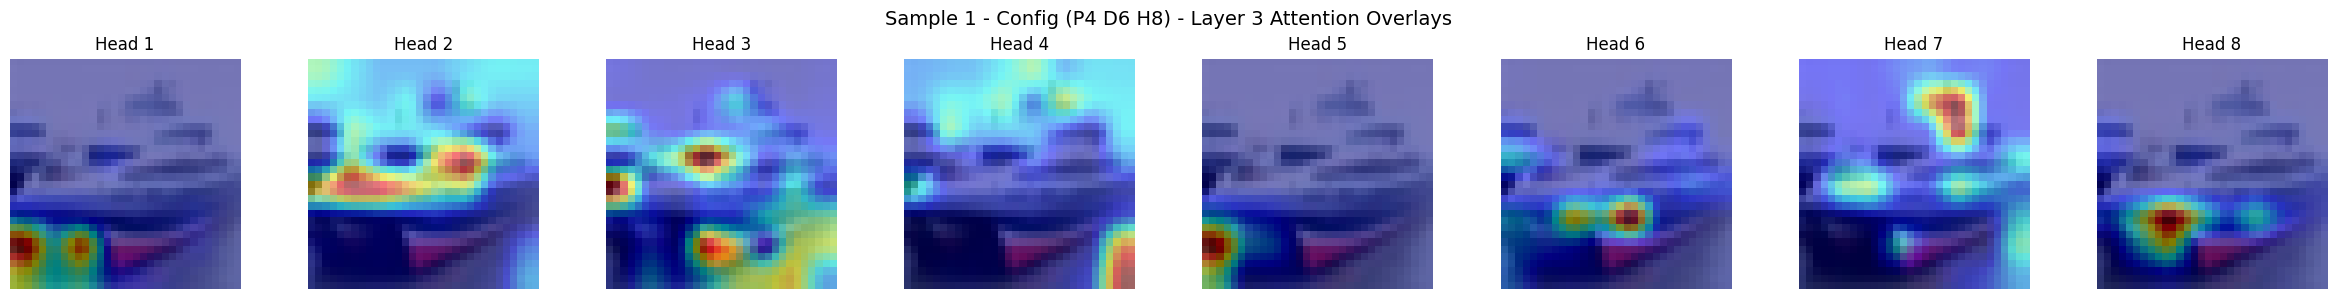

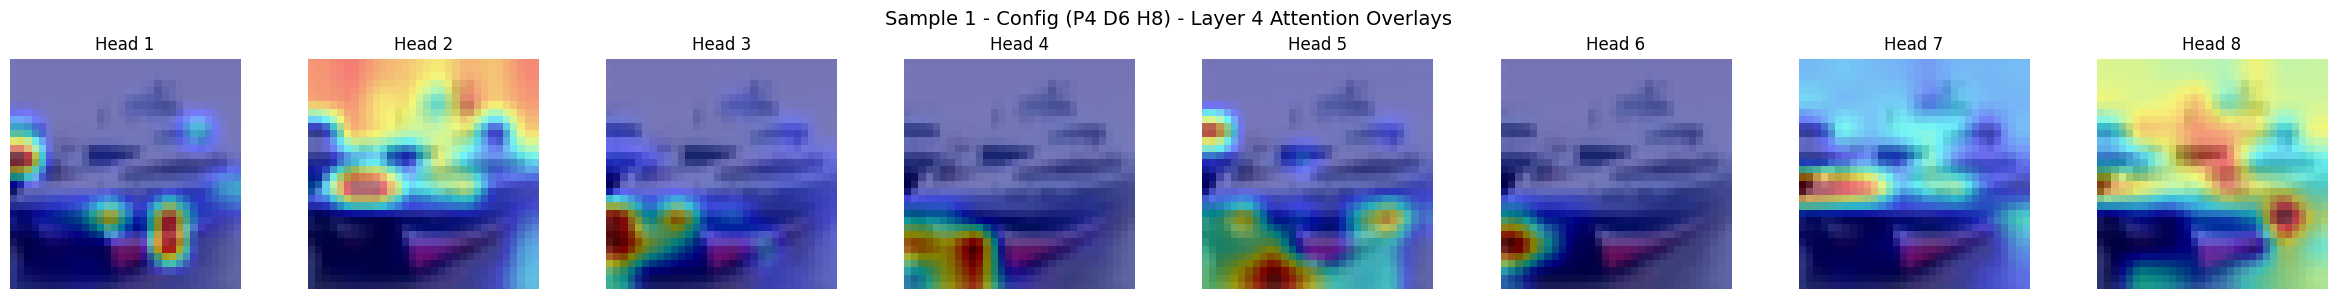

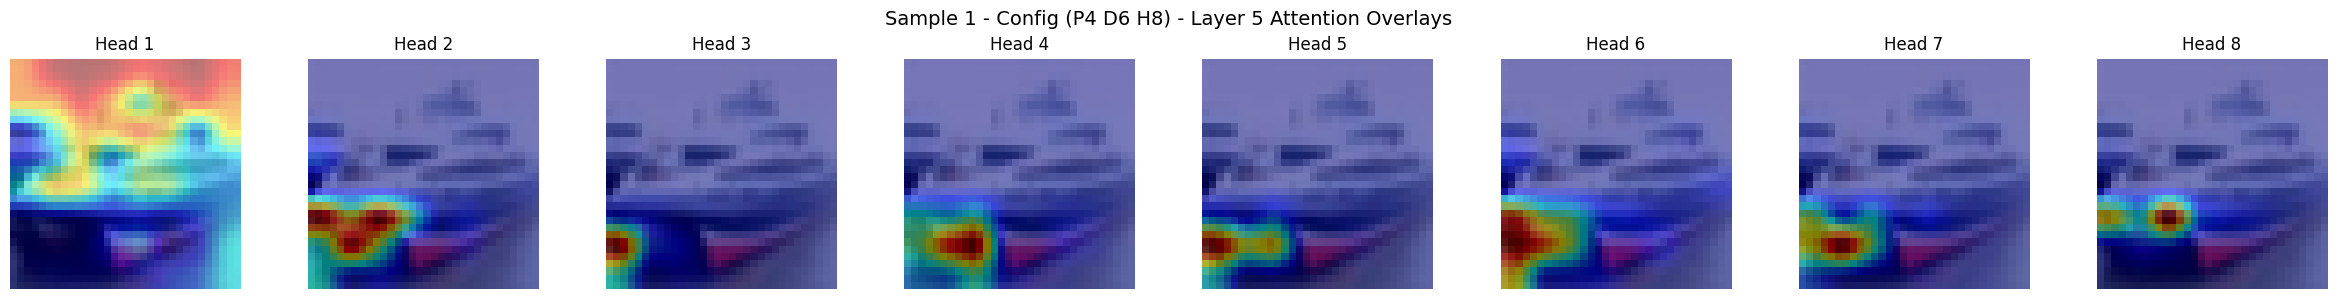

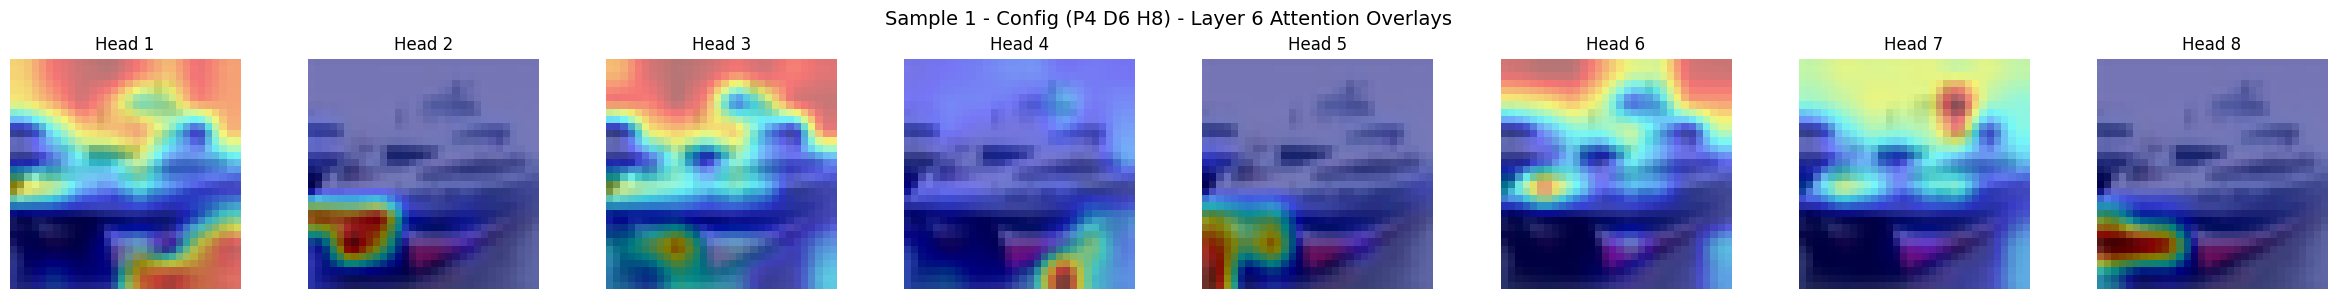

----------------------------------------------------
Config: Patch Size 2, Depth 6, Num Heads 8
Epoch 1: Train Loss 1.7400, Train Acc 0.3535
Epoch 2: Train Loss 1.3809, Train Acc 0.4980
Epoch 3: Train Loss 1.2174, Train Acc 0.5615
Epoch 4: Train Loss 1.1110, Train Acc 0.6013
Epoch 5: Train Loss 1.0307, Train Acc 0.6299
Epoch 6: Train Loss 0.9717, Train Acc 0.6510
Epoch 7: Train Loss 0.9157, Train Acc 0.6695
Epoch 8: Train Loss 0.8686, Train Acc 0.6880
Epoch 9: Train Loss 0.8242, Train Acc 0.7036
Epoch 10: Train Loss 0.7778, Train Acc 0.7198
Config Result -> Test Loss: 0.9571, Test Acc: 0.6710


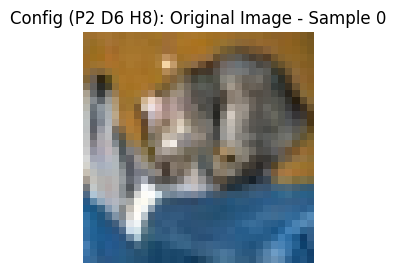

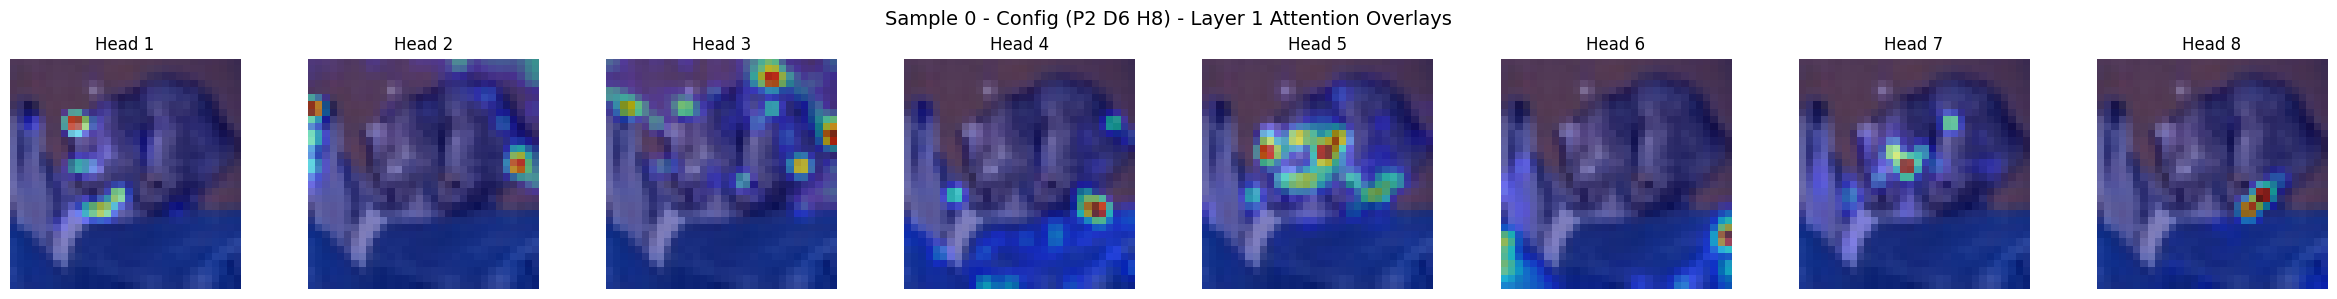

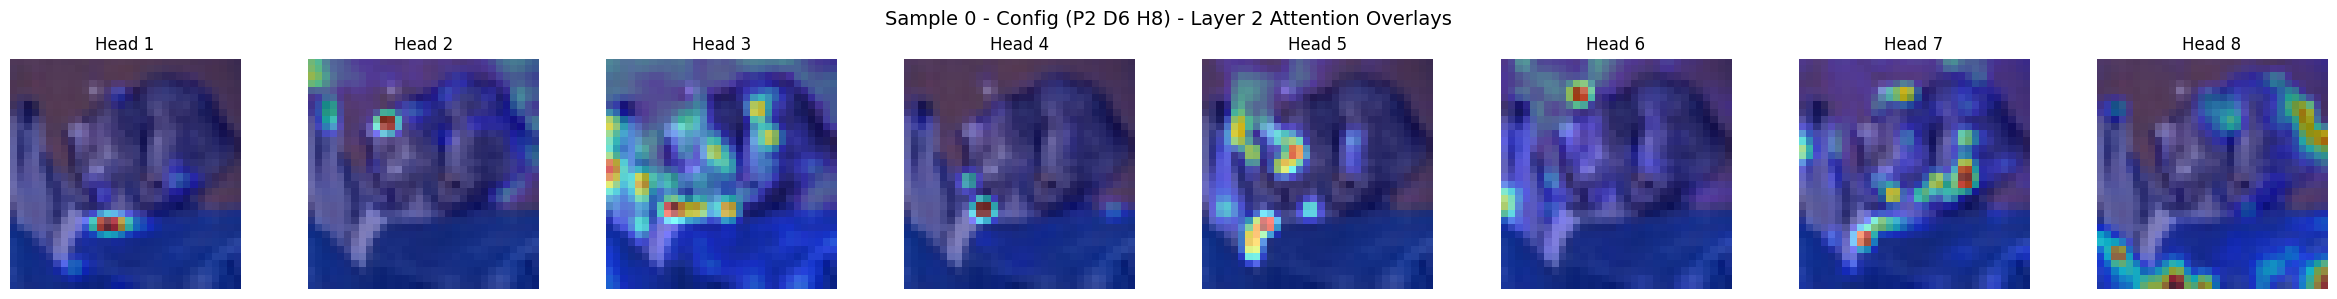

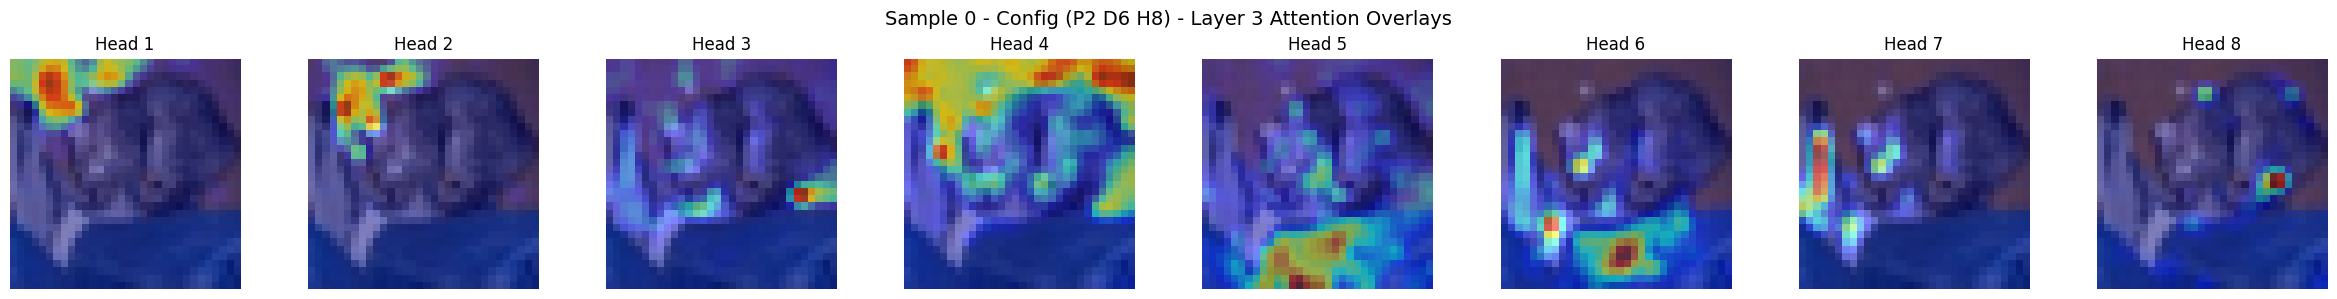

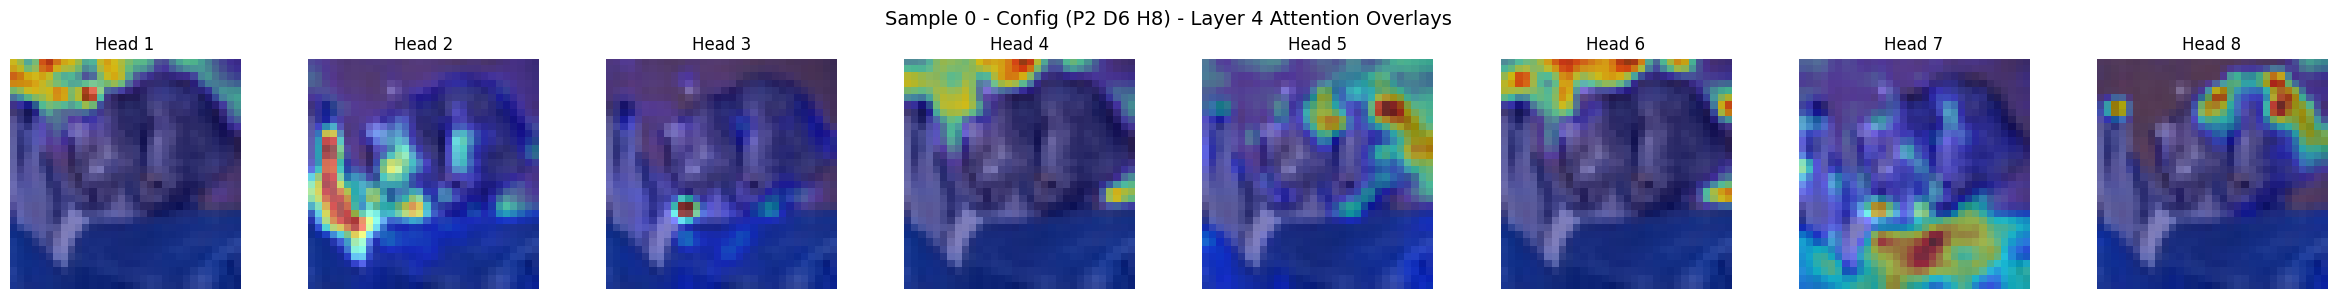

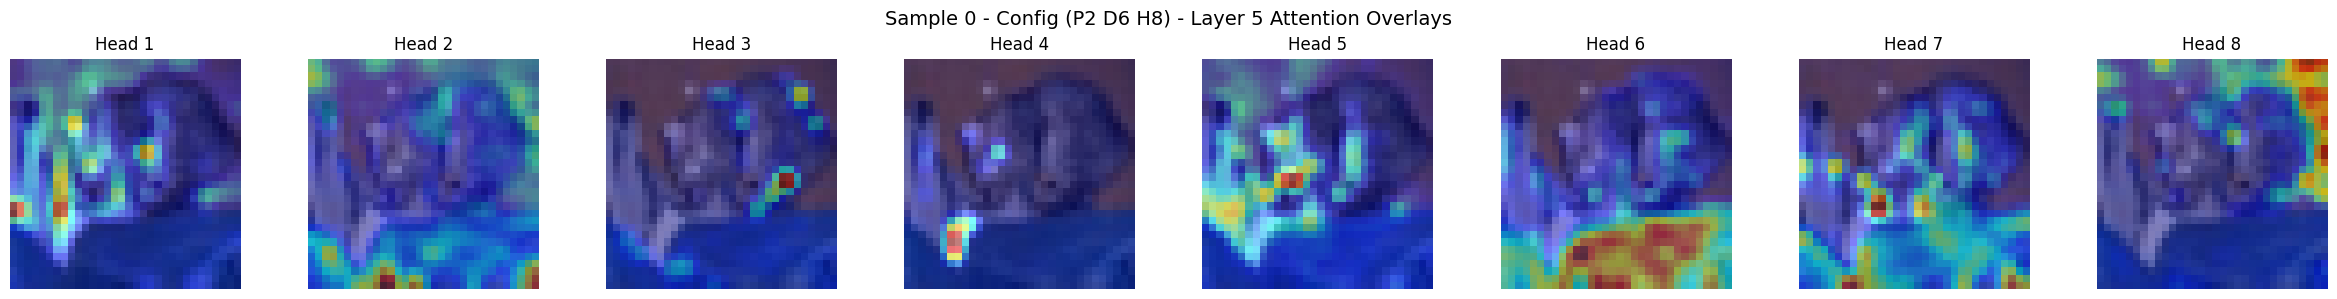

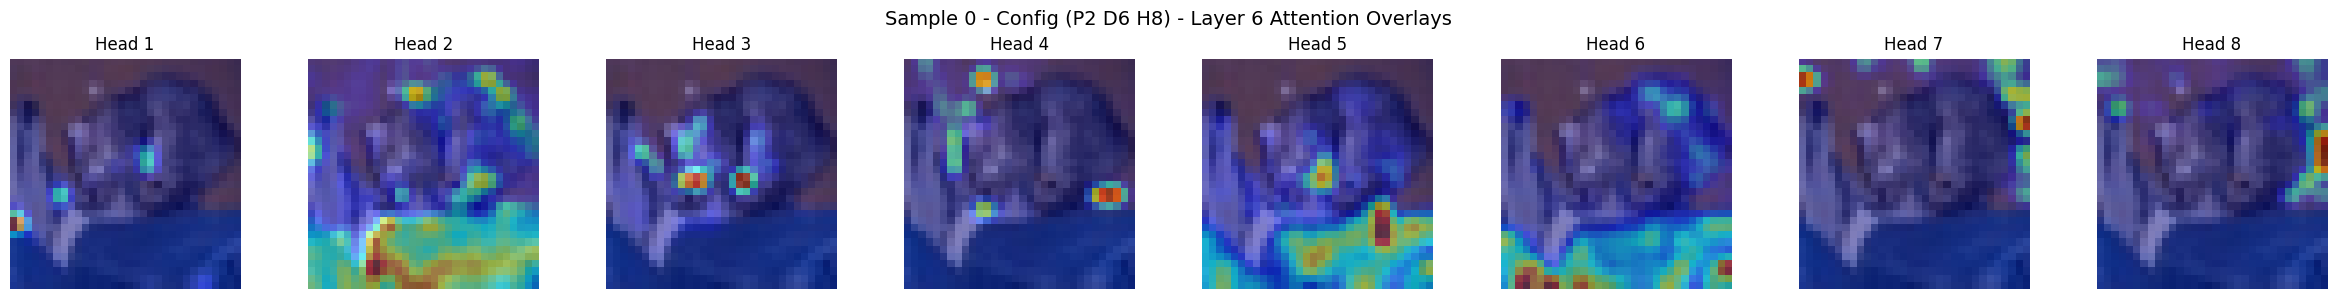

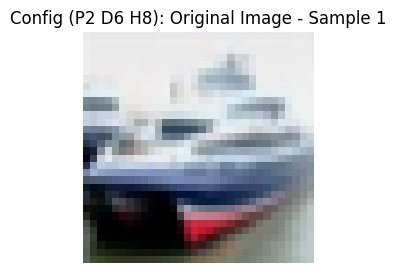

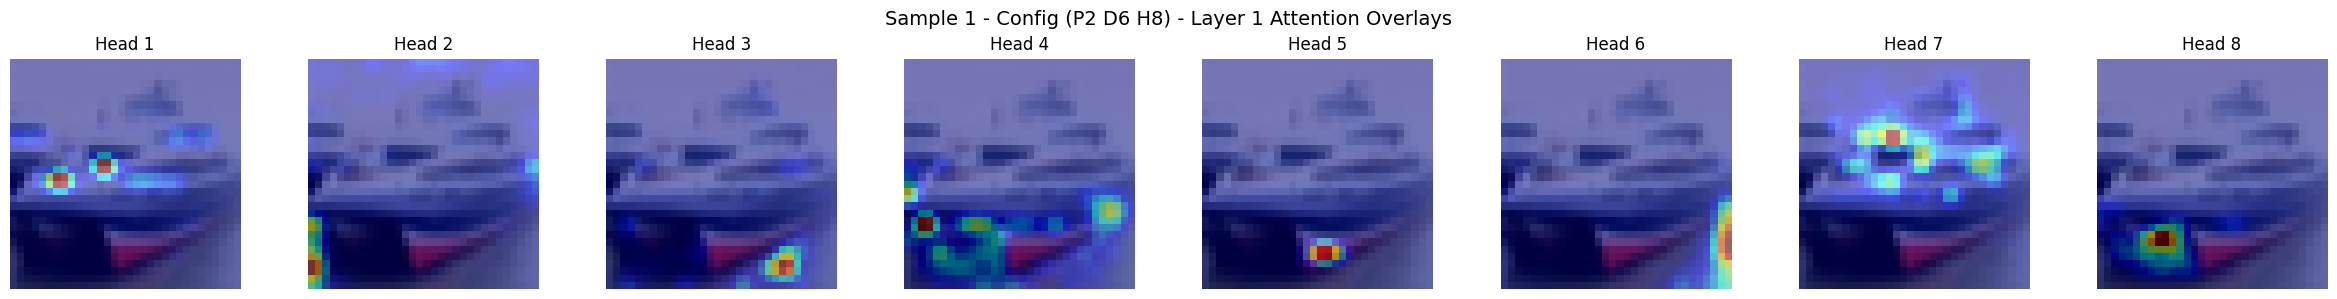

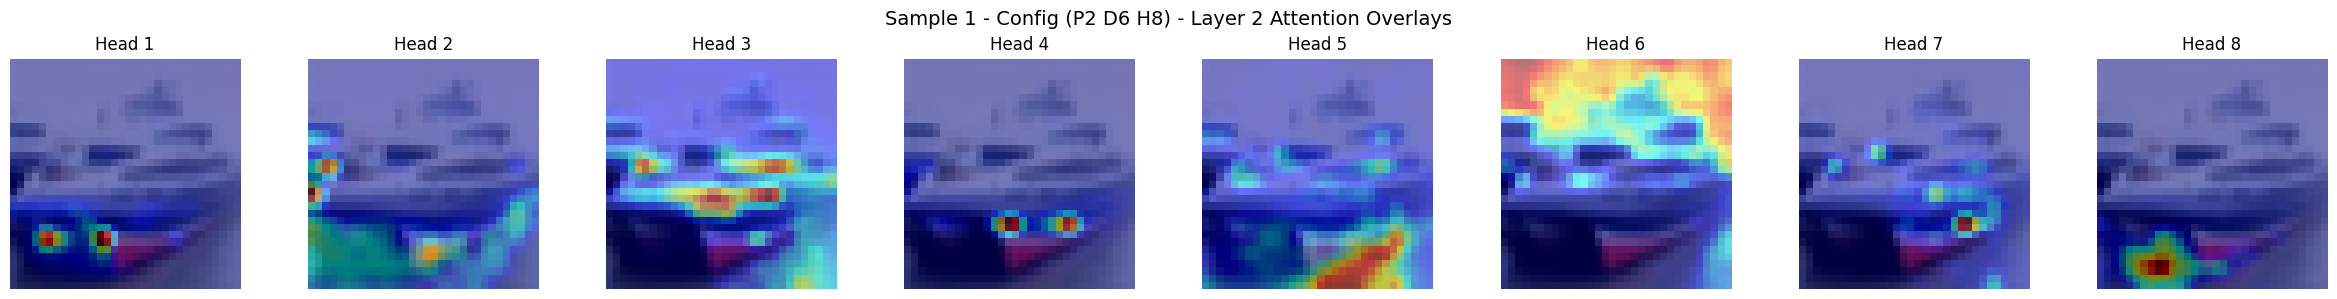

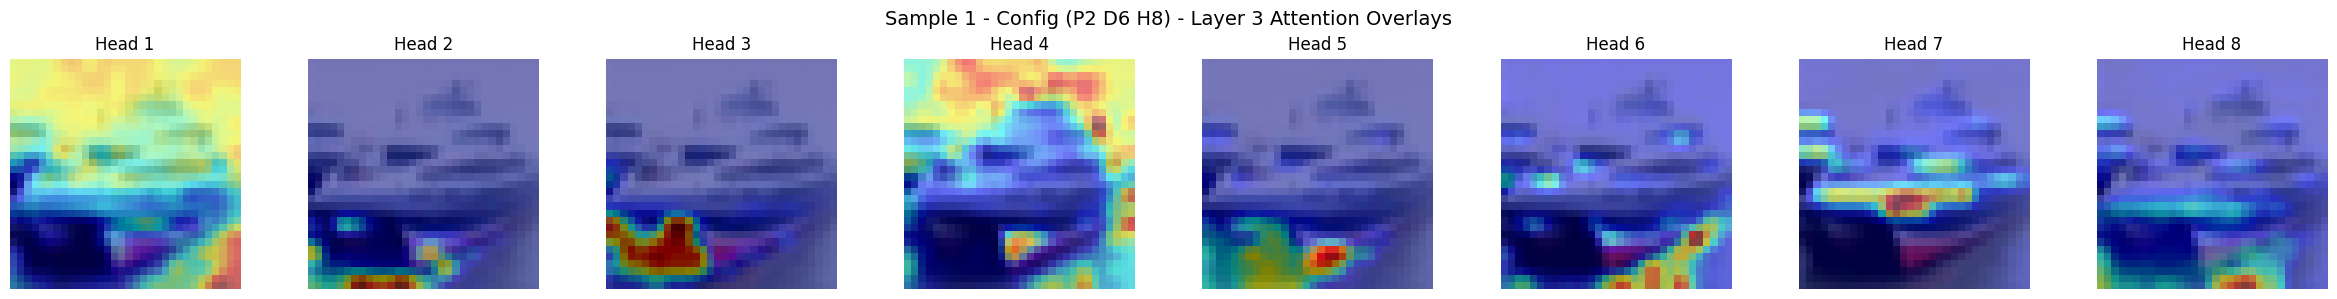

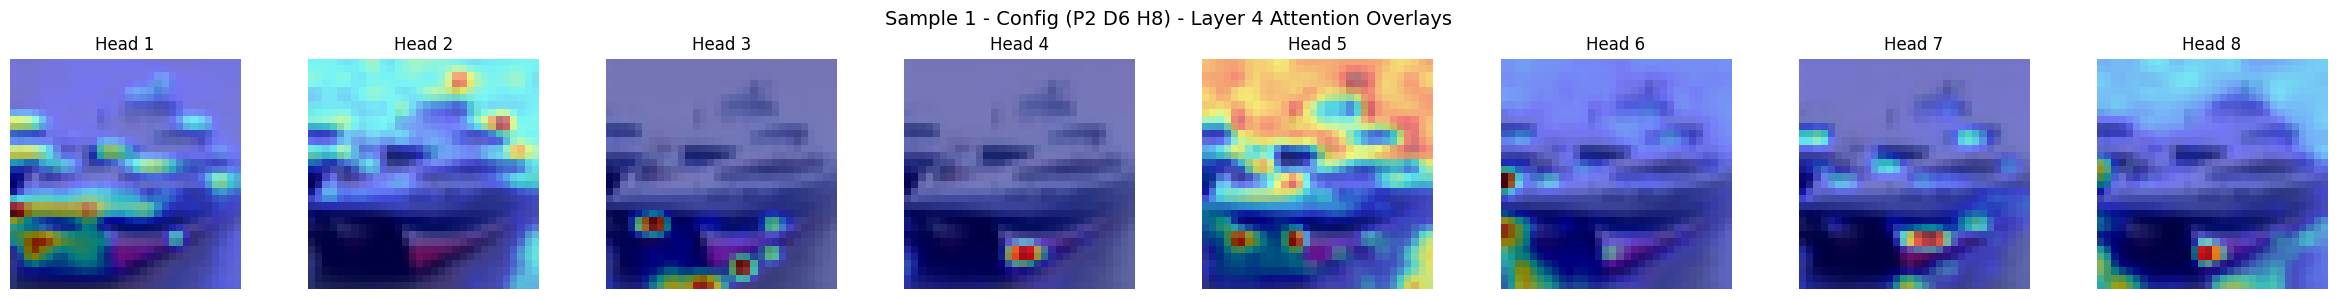

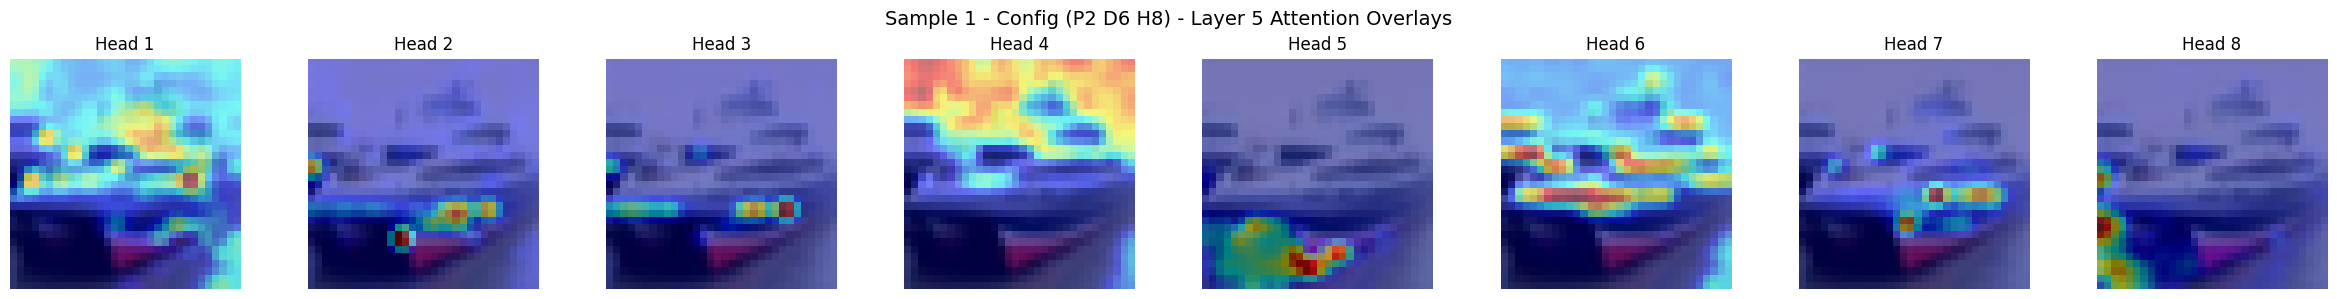

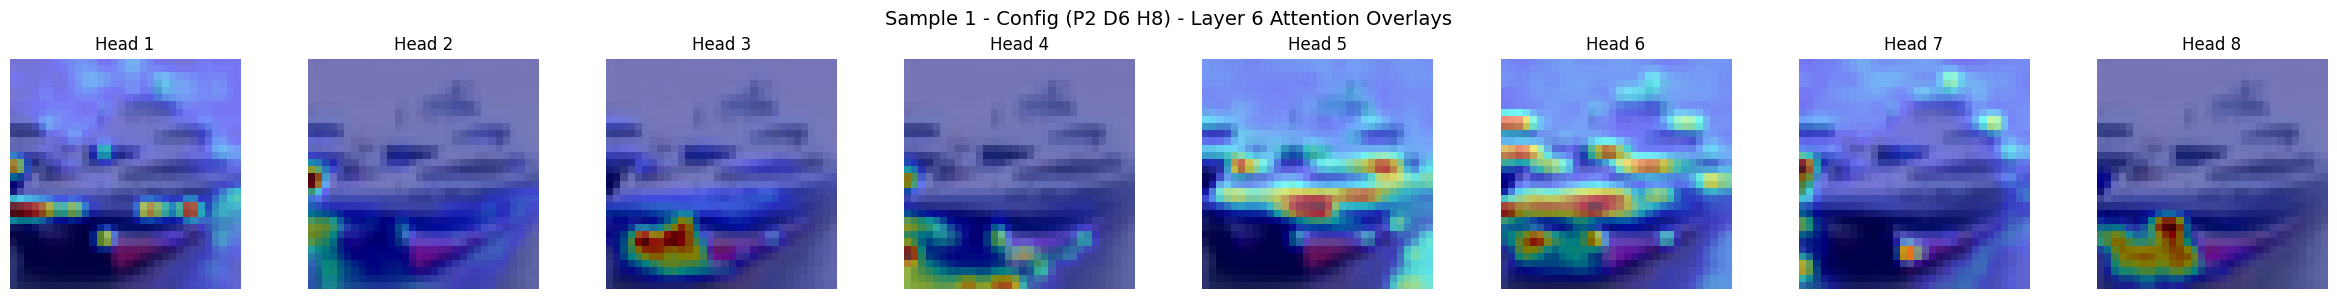

----------------------------------------------------
Config: Patch Size 4, Depth 12, Num Heads 8
Epoch 1: Train Loss 1.7135, Train Acc 0.3658
Epoch 2: Train Loss 1.3575, Train Acc 0.5029
Epoch 3: Train Loss 1.2303, Train Acc 0.5530
Epoch 4: Train Loss 1.1531, Train Acc 0.5840
Epoch 5: Train Loss 1.0976, Train Acc 0.6024
Epoch 6: Train Loss 1.0467, Train Acc 0.6223
Epoch 7: Train Loss 1.0064, Train Acc 0.6364
Epoch 8: Train Loss 0.9630, Train Acc 0.6539
Epoch 9: Train Loss 0.9234, Train Acc 0.6679
Epoch 10: Train Loss 0.8946, Train Acc 0.6767
Config Result -> Test Loss: 1.0483, Test Acc: 0.6263


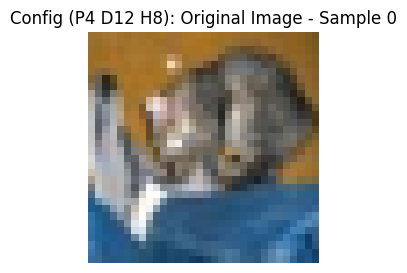

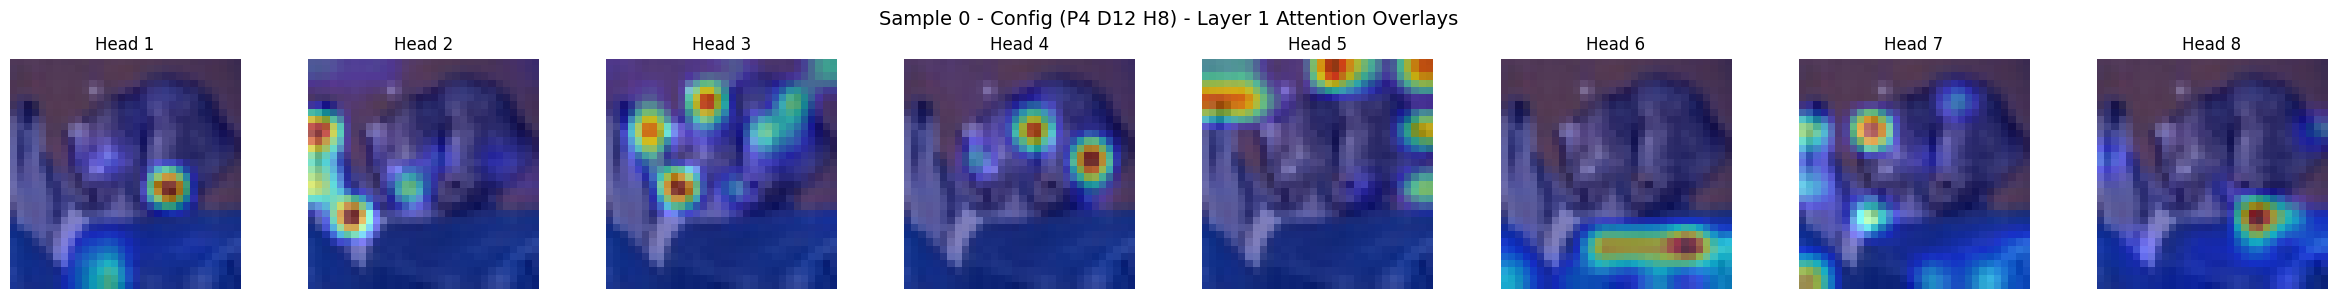

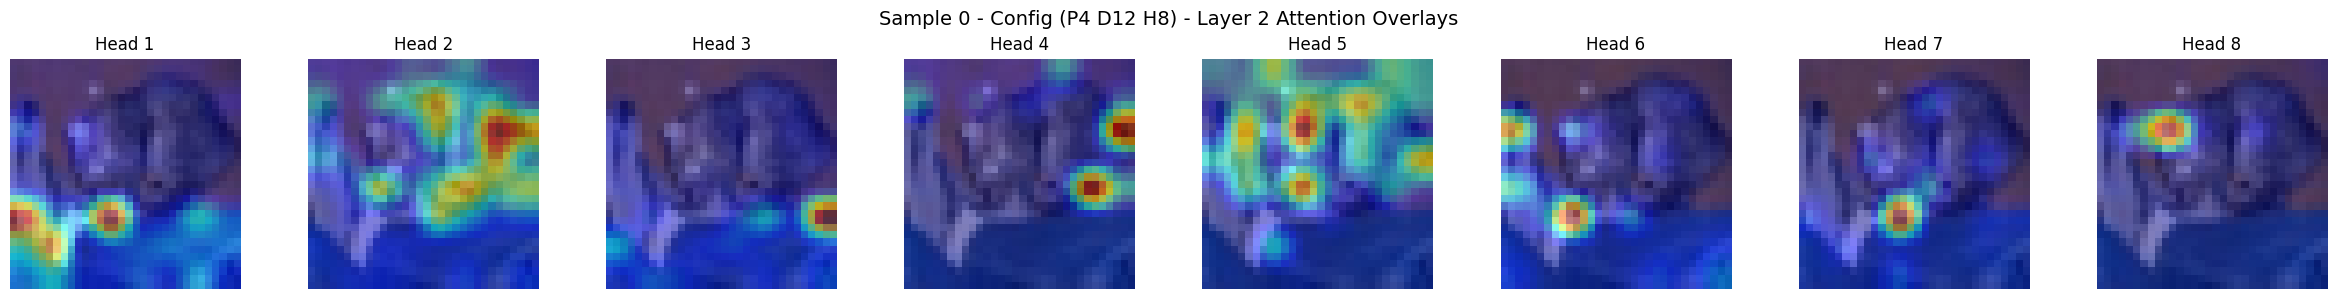

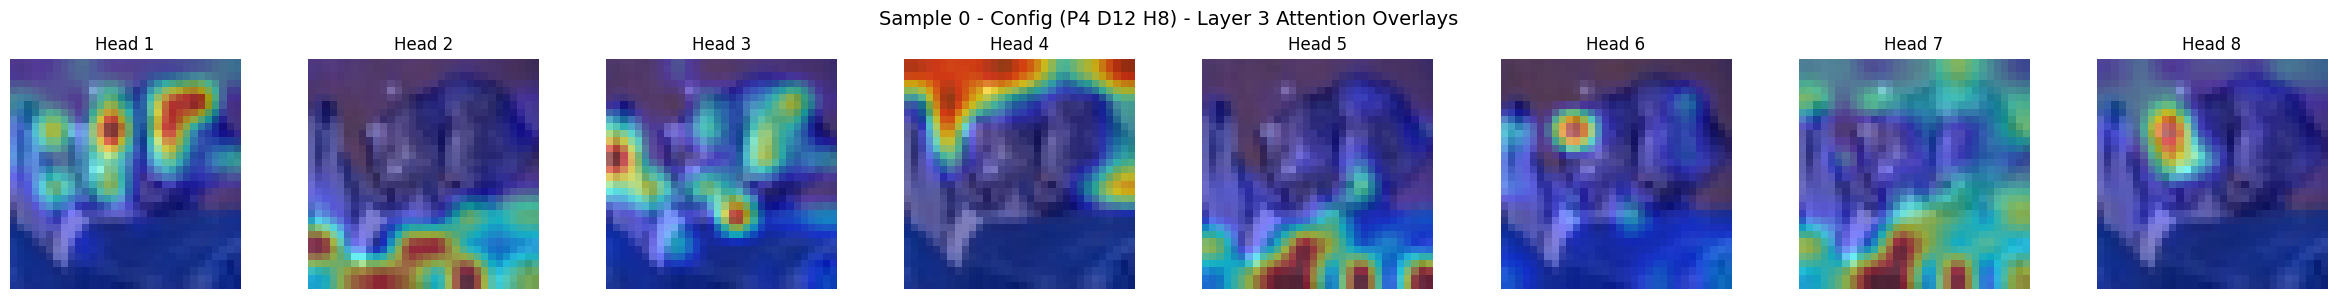

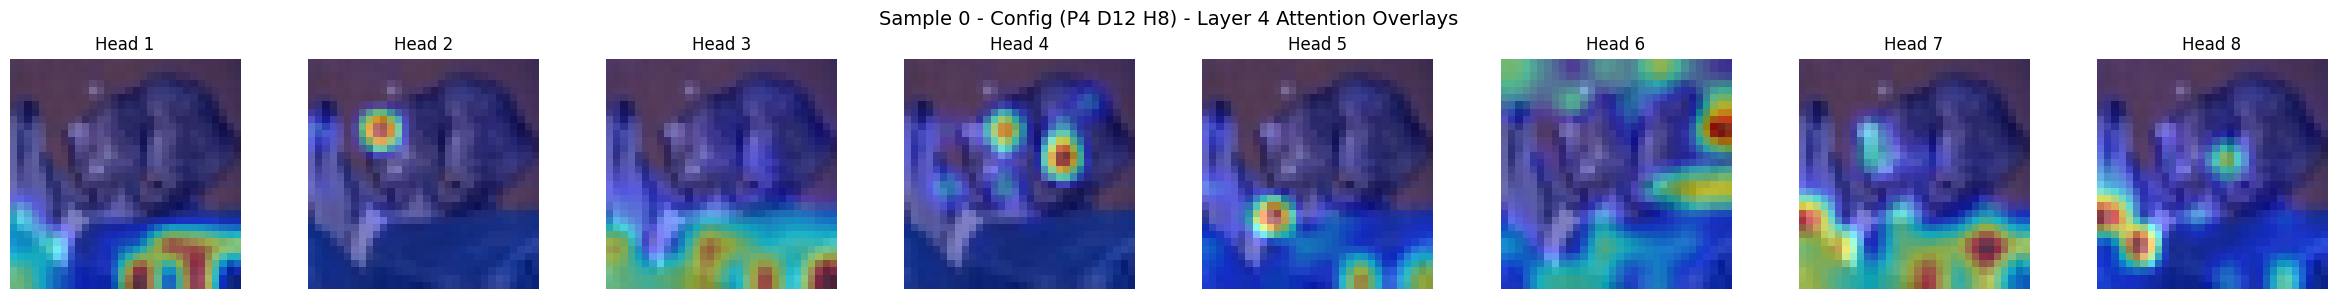

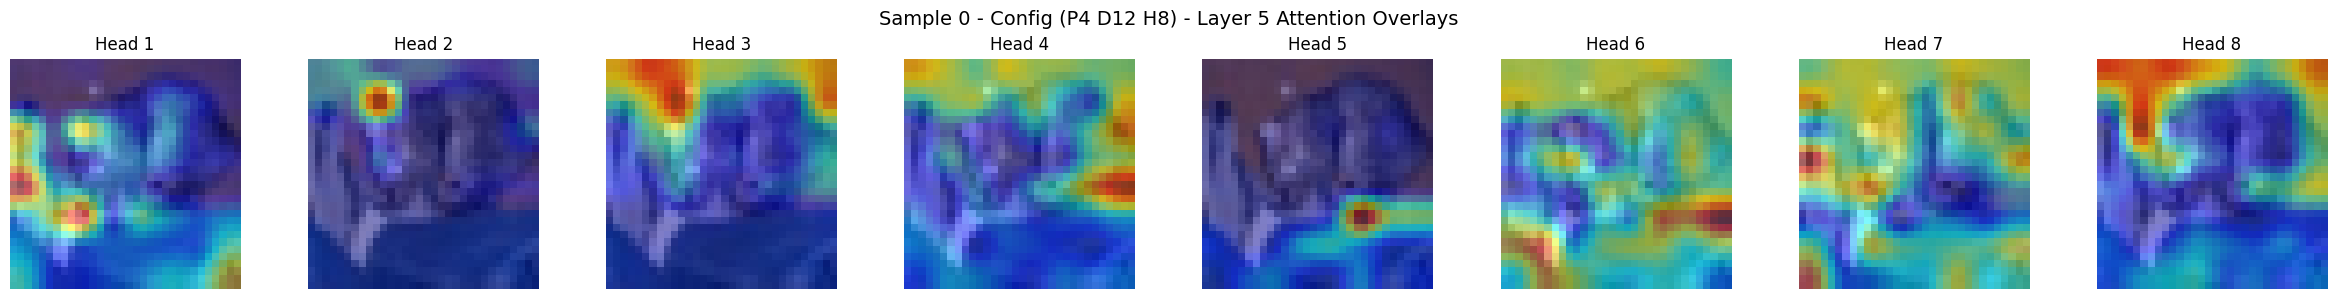

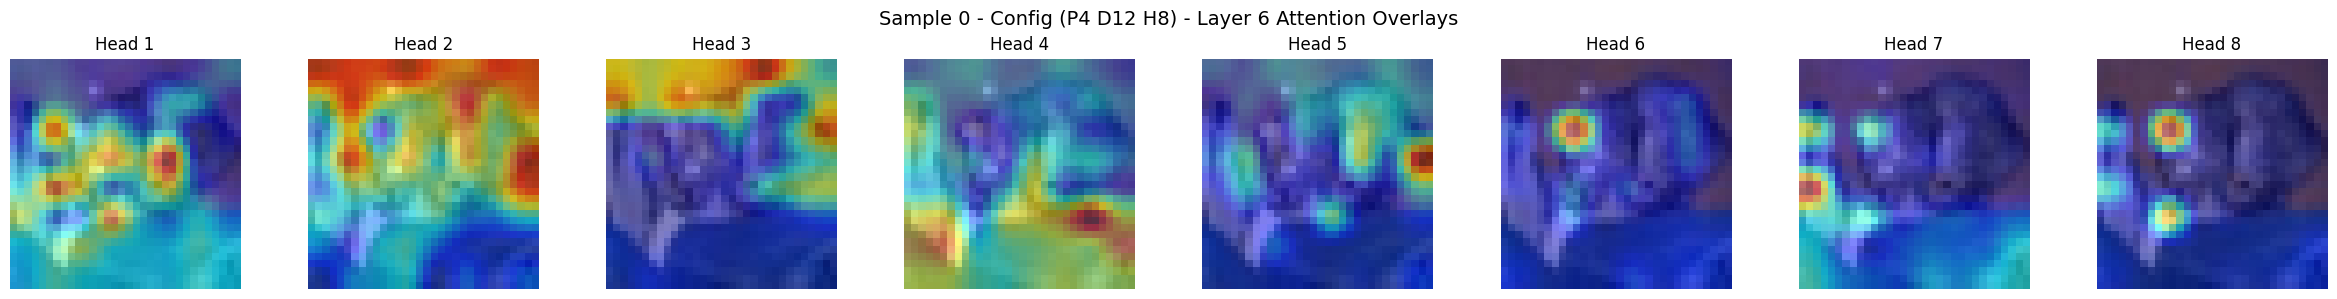

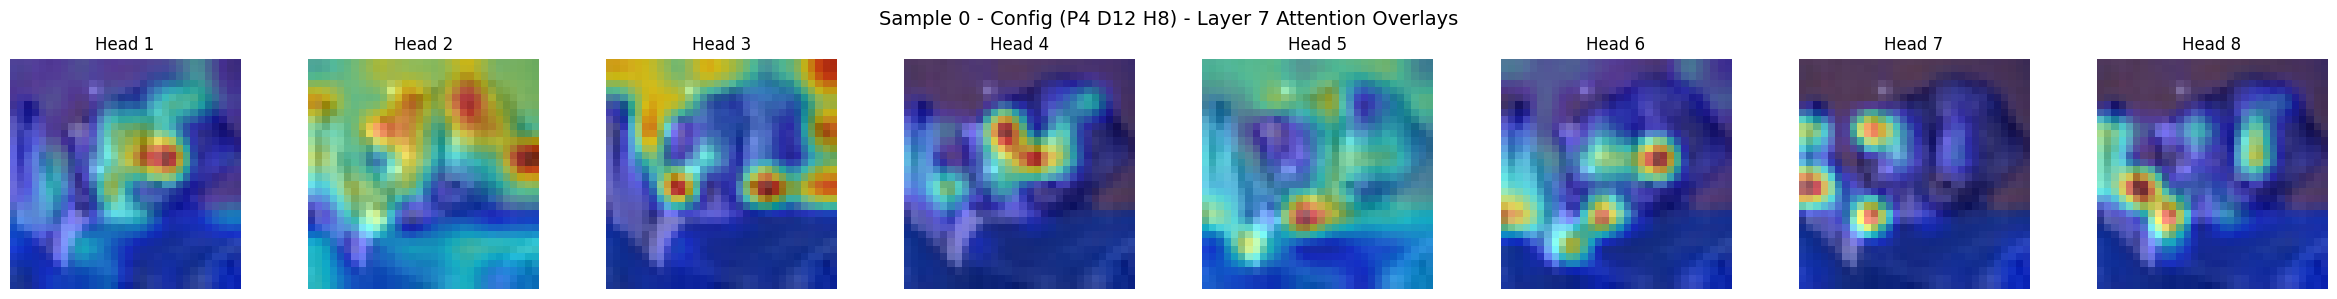

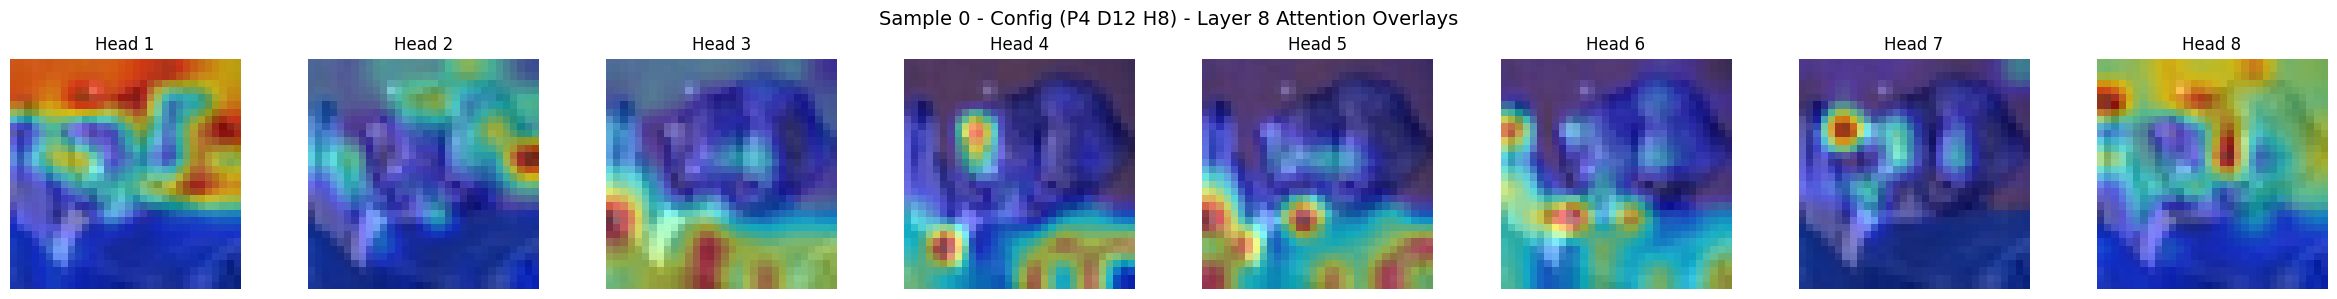

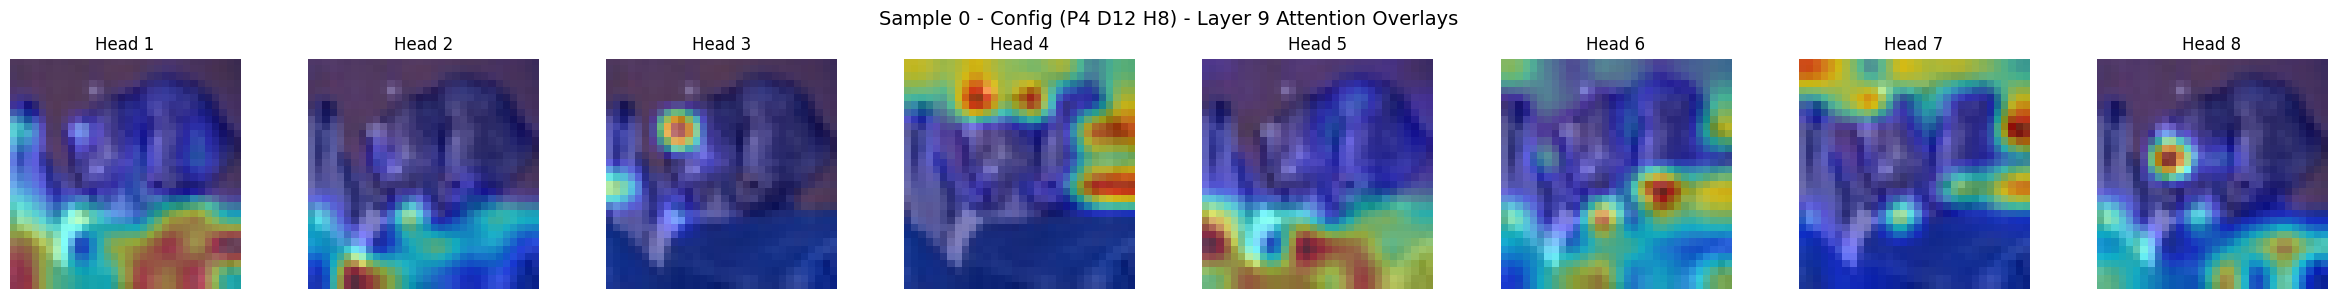

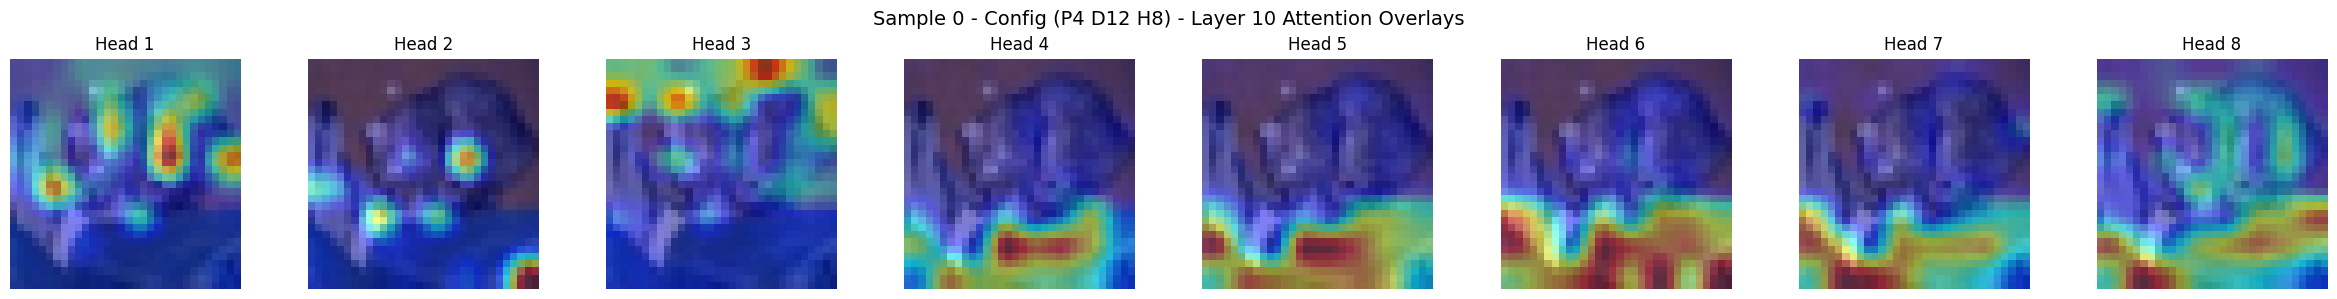

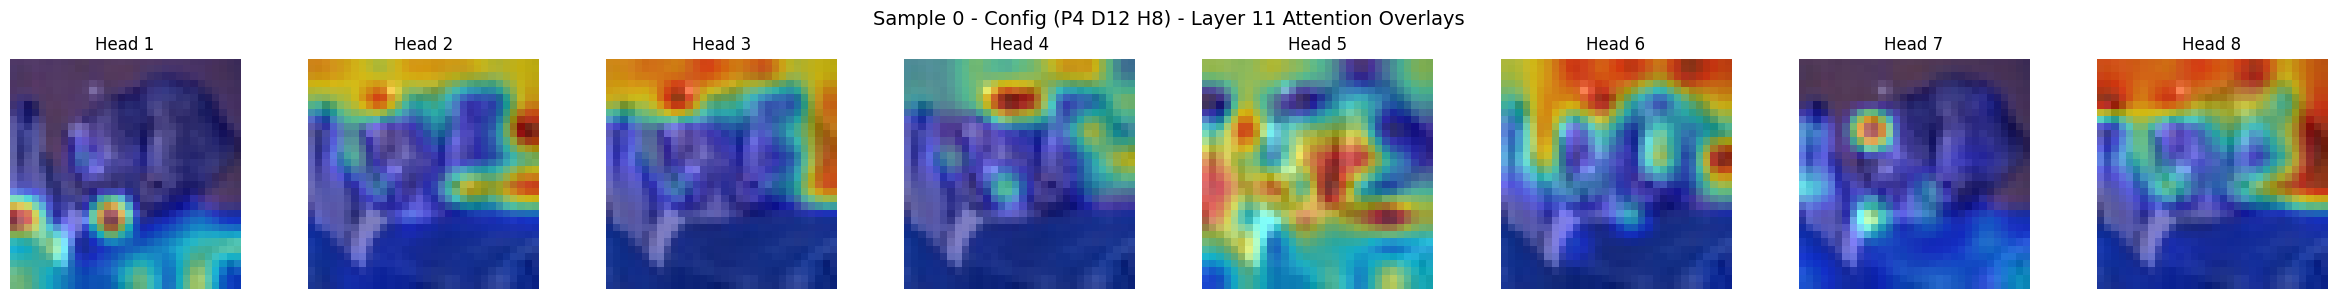

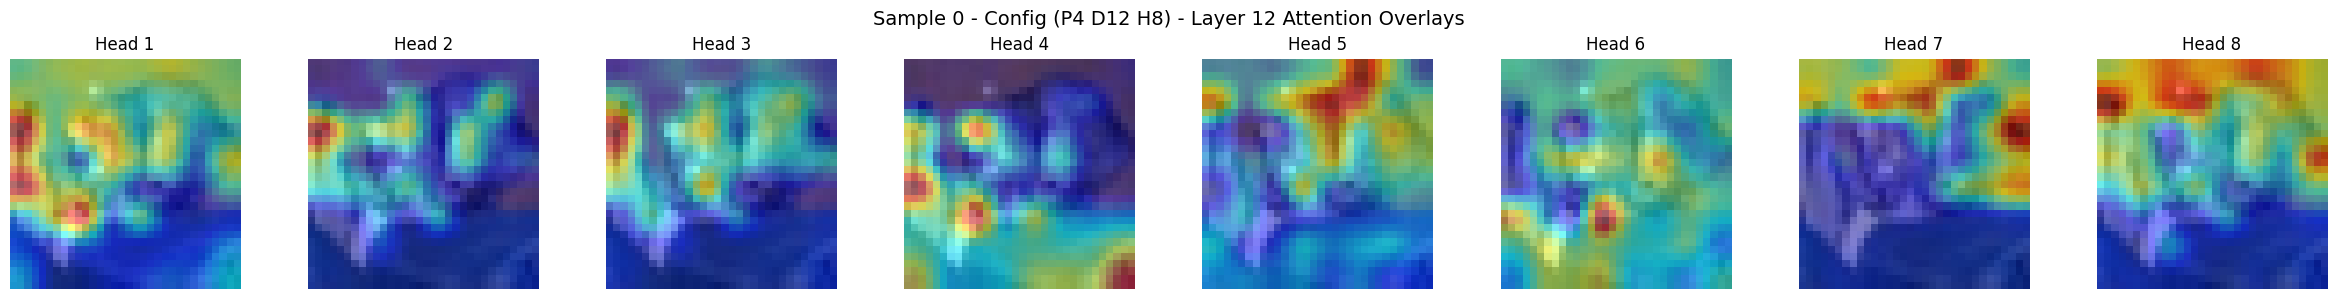

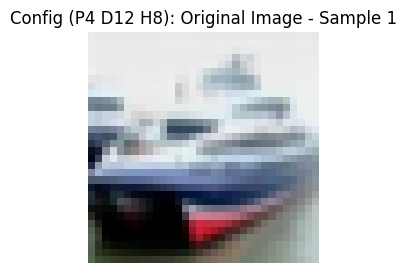

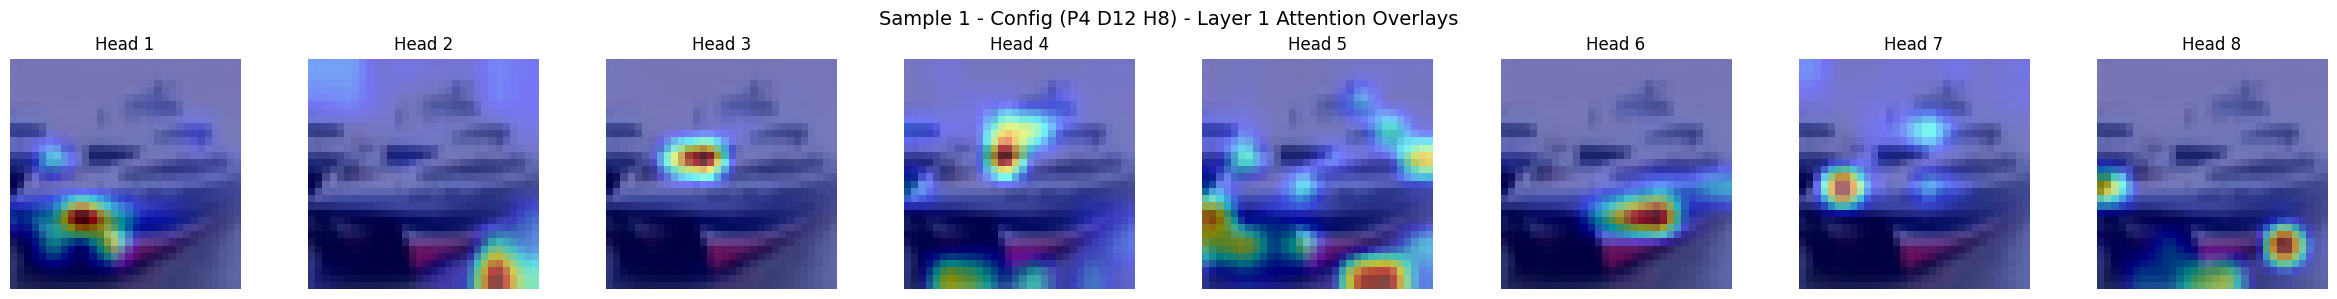

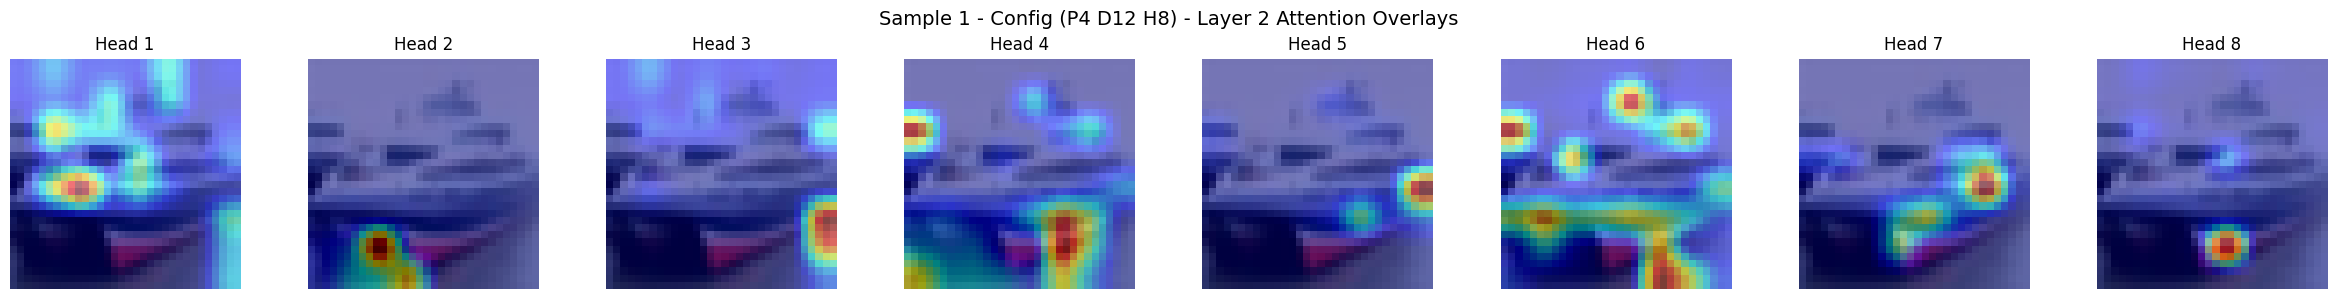

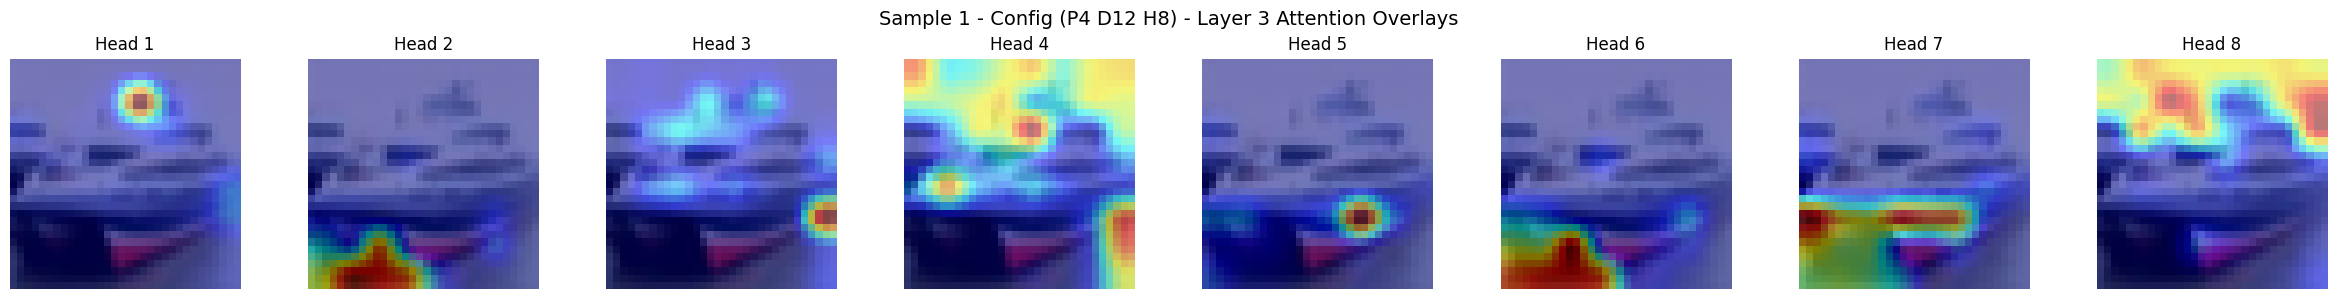

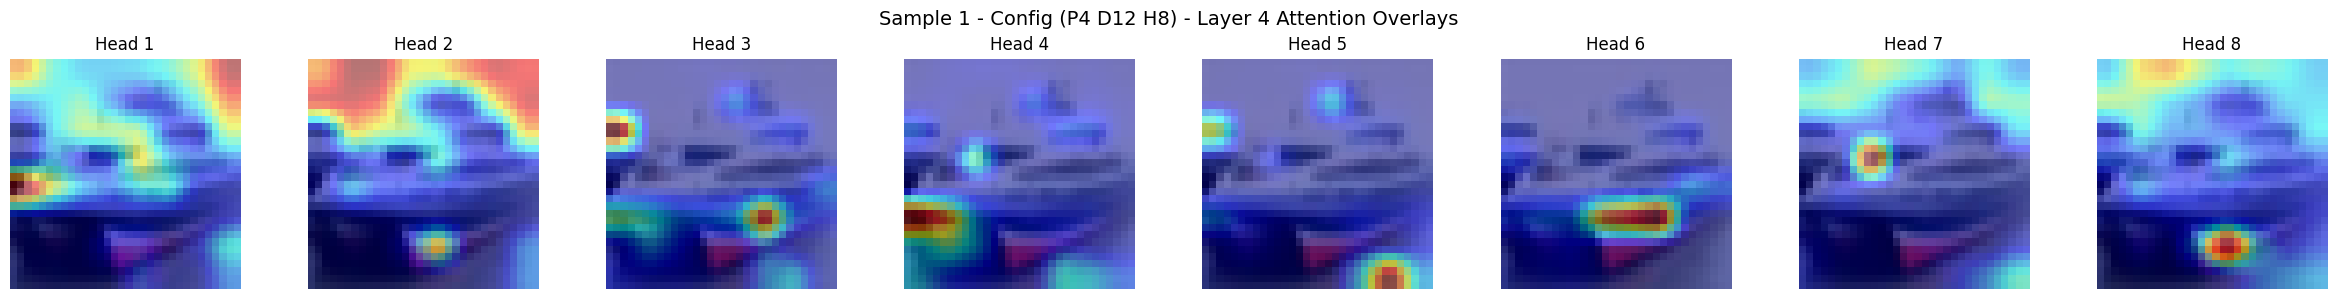

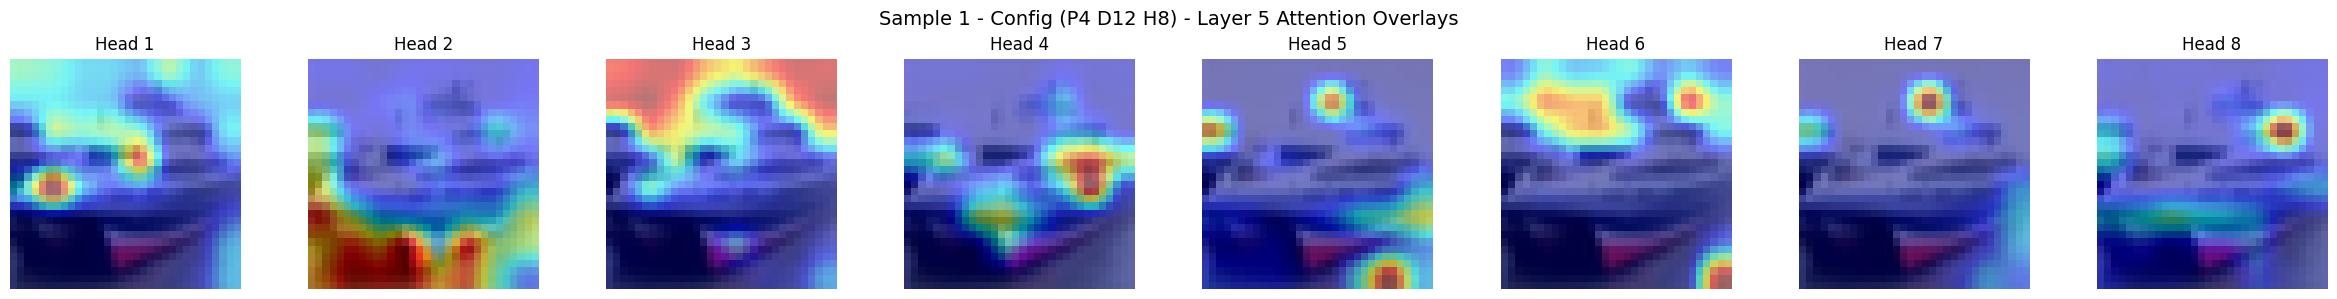

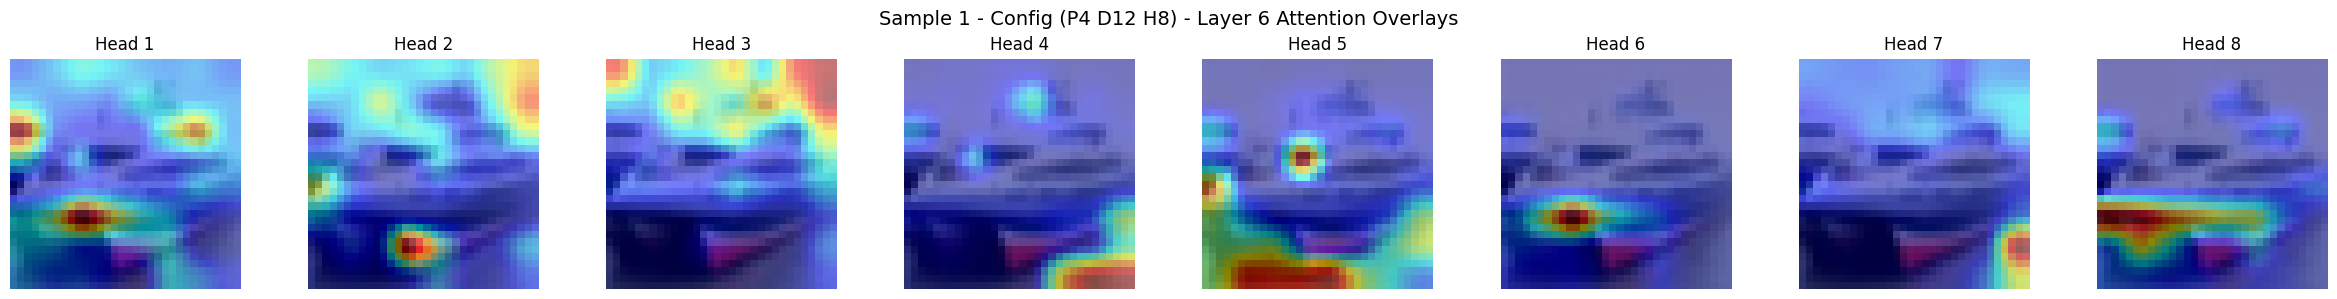

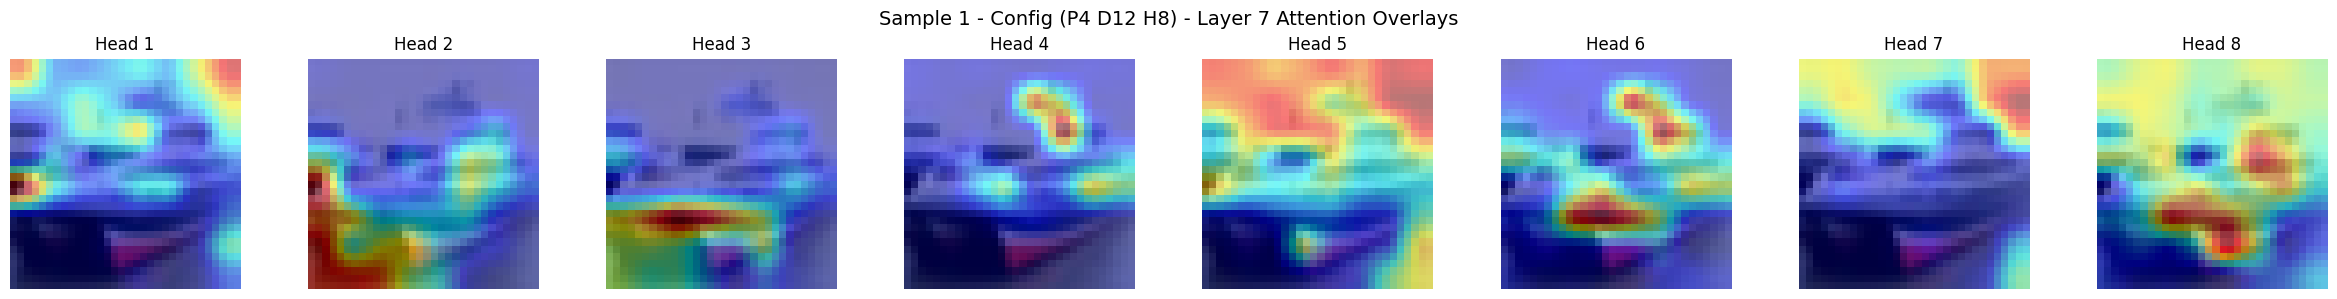

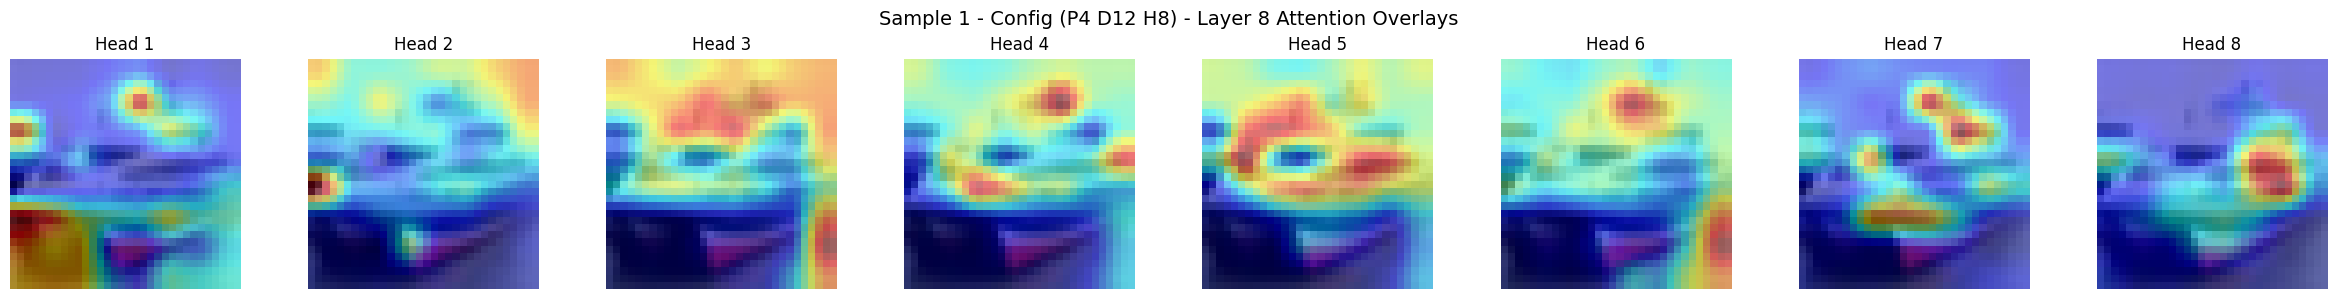

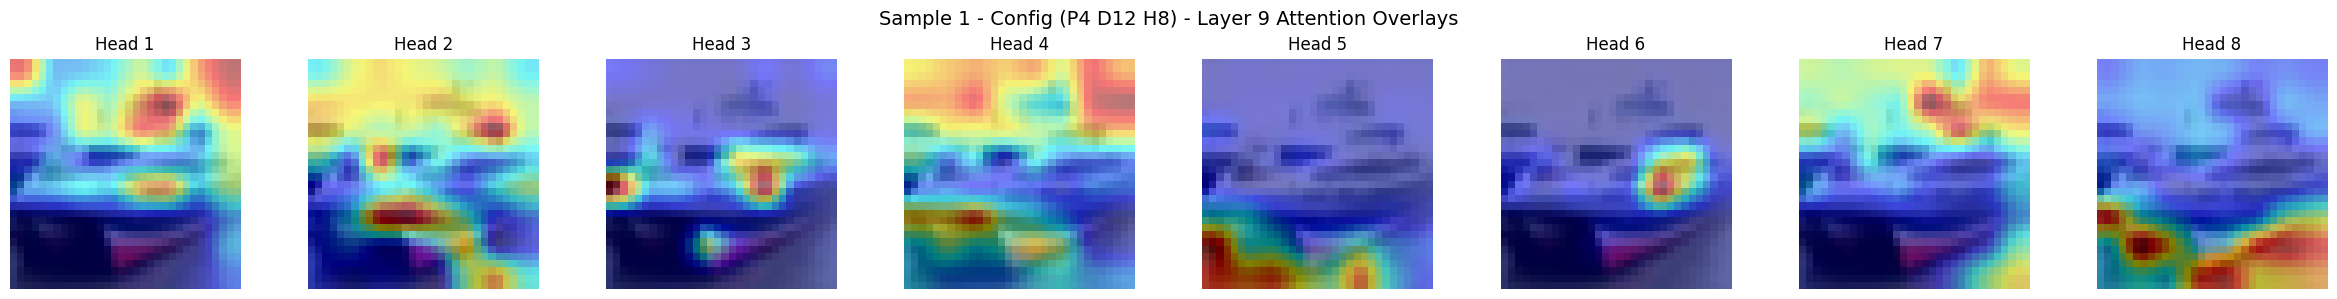

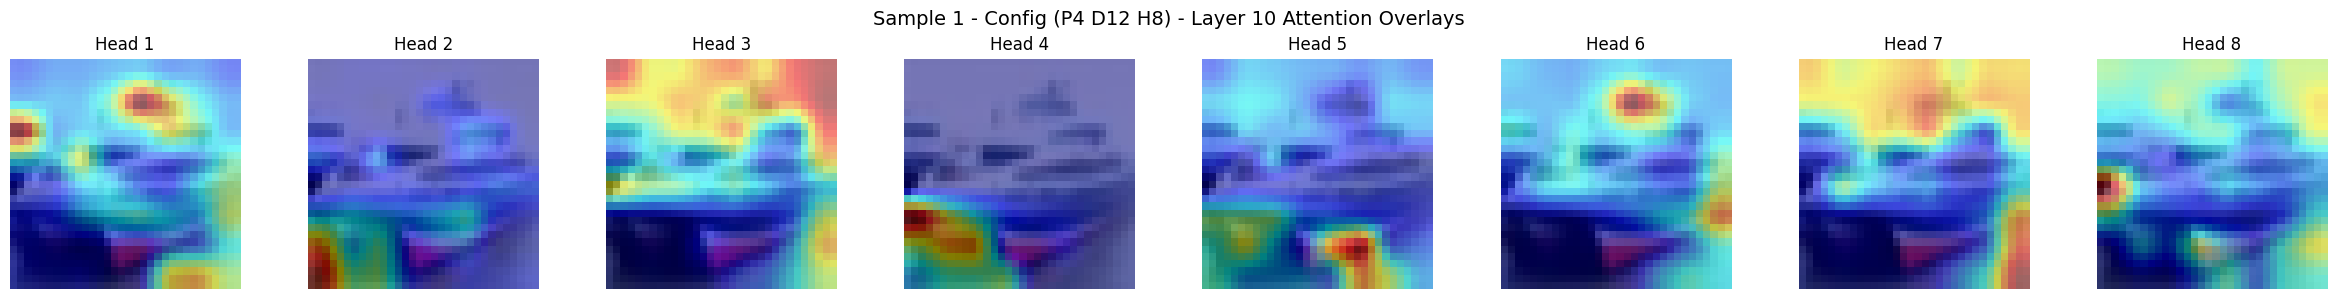

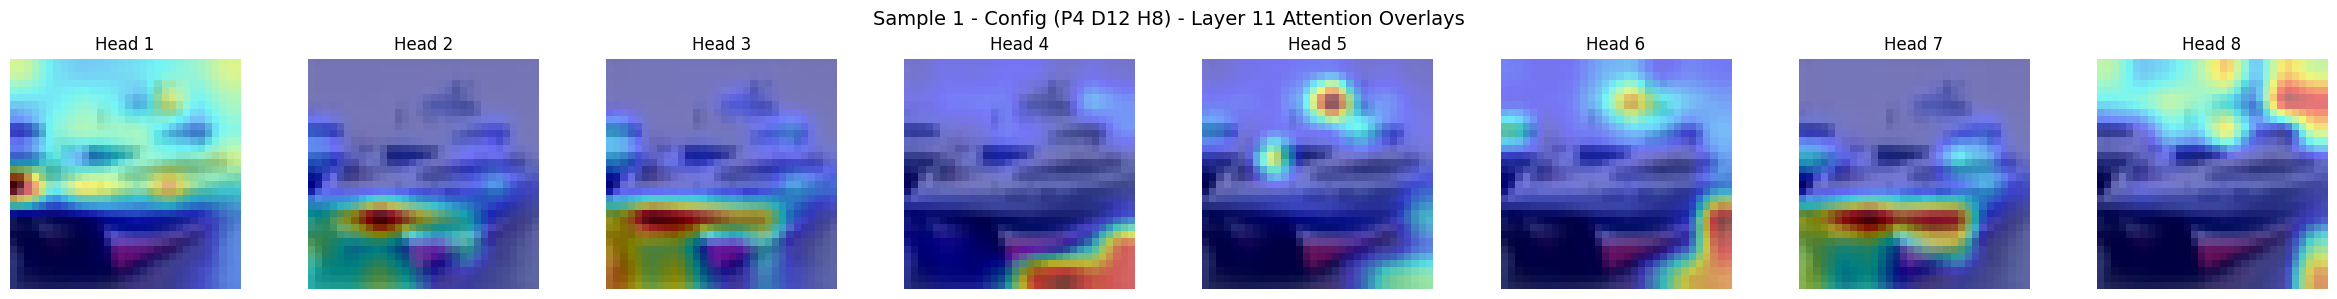

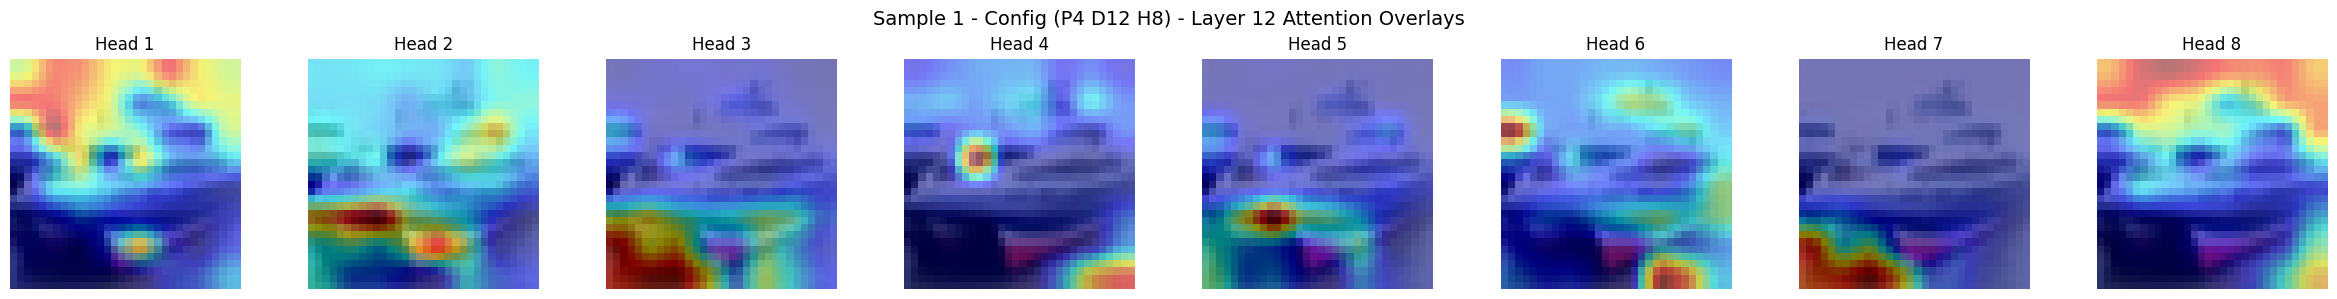

----------------------------------------------------
Config: Patch Size 4, Depth 6, Num Heads 4
Epoch 1: Train Loss 1.6793, Train Acc 0.3765
Epoch 2: Train Loss 1.3702, Train Acc 0.4980
Epoch 3: Train Loss 1.2482, Train Acc 0.5449
Epoch 4: Train Loss 1.1763, Train Acc 0.5752
Epoch 5: Train Loss 1.1232, Train Acc 0.5935
Epoch 6: Train Loss 1.0750, Train Acc 0.6121
Epoch 7: Train Loss 1.0352, Train Acc 0.6285
Epoch 8: Train Loss 0.9926, Train Acc 0.6408
Epoch 9: Train Loss 0.9572, Train Acc 0.6537
Epoch 10: Train Loss 0.9243, Train Acc 0.6682
Config Result -> Test Loss: 1.0336, Test Acc: 0.6254


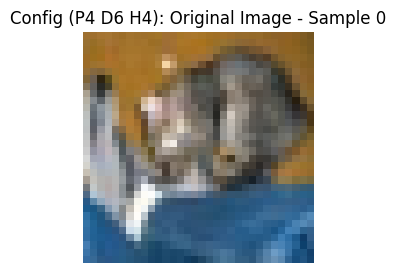

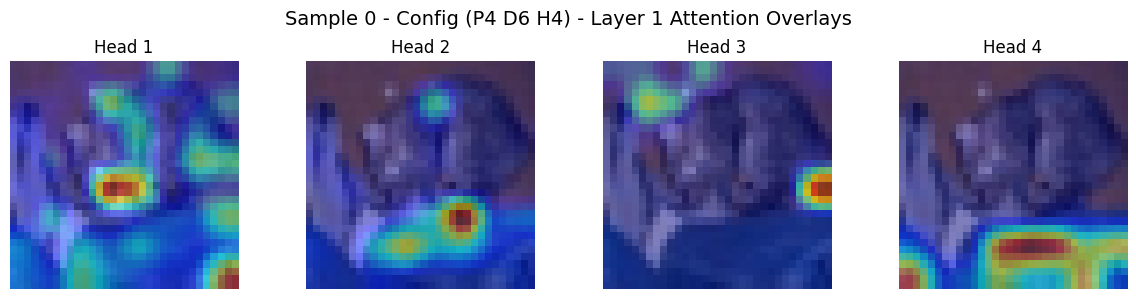

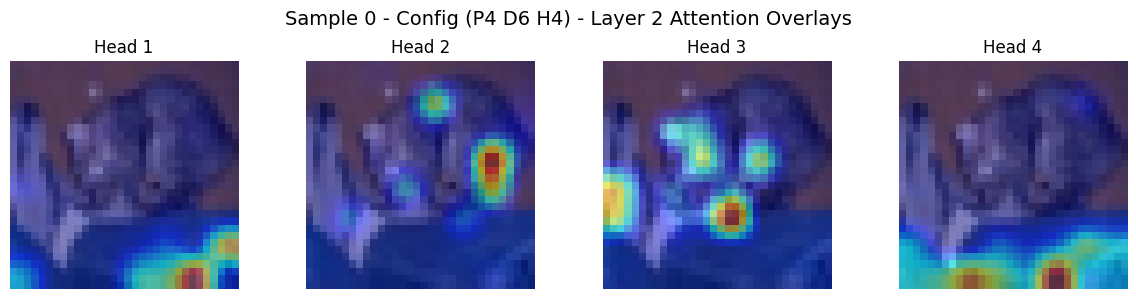

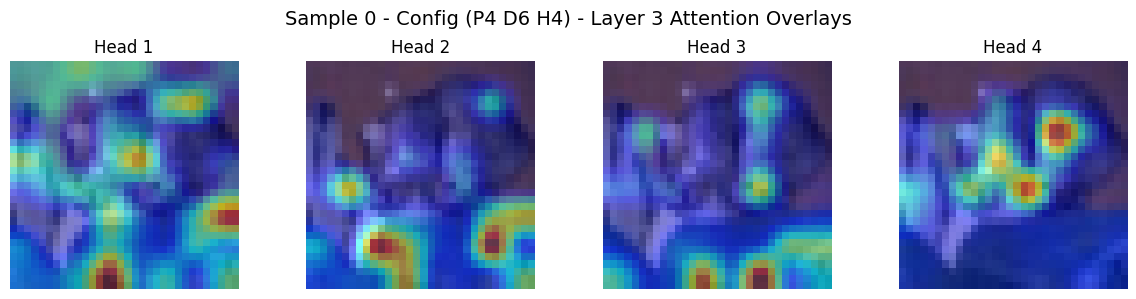

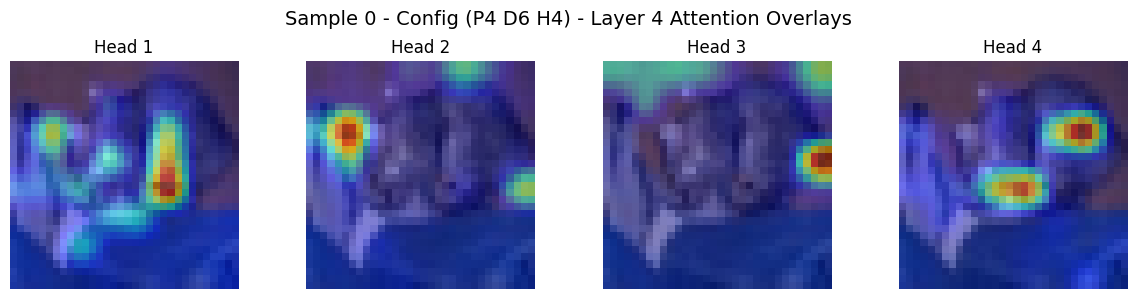

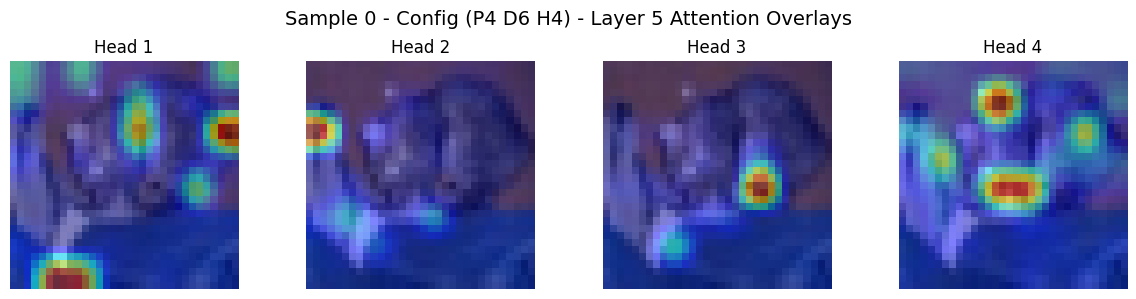

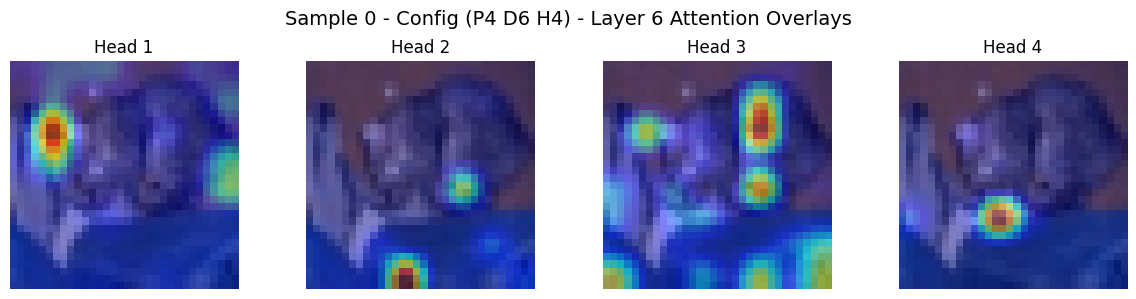

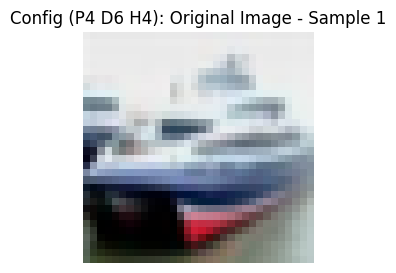

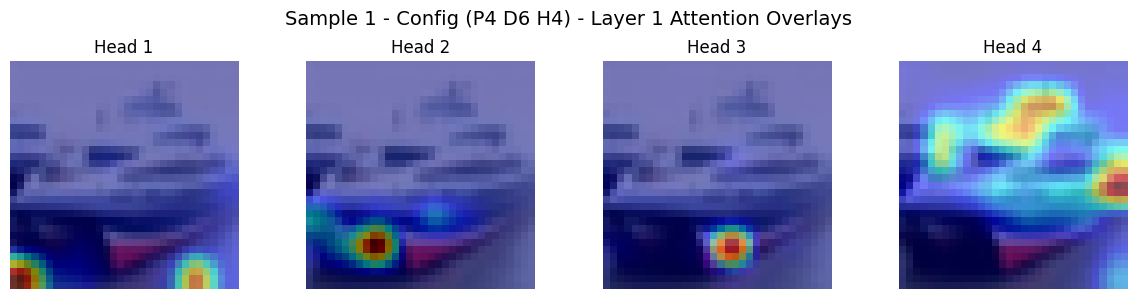

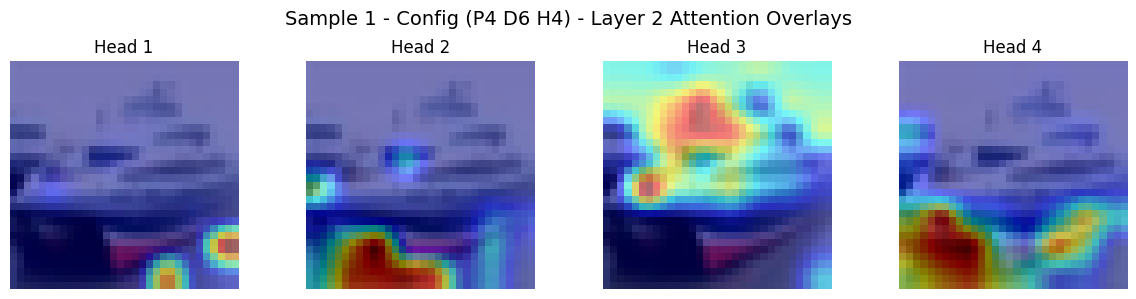

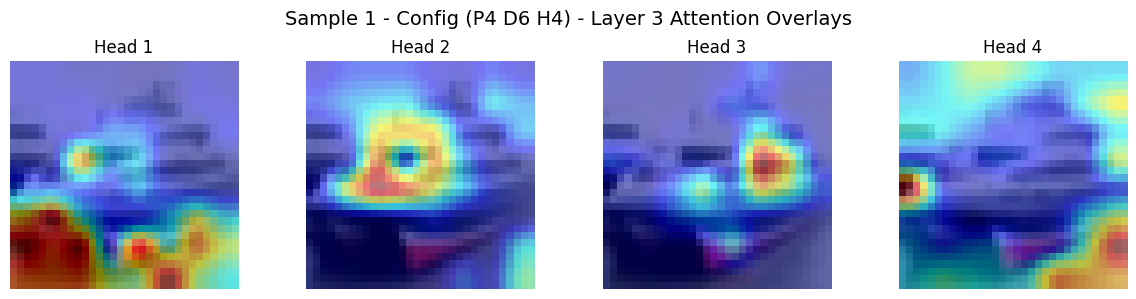

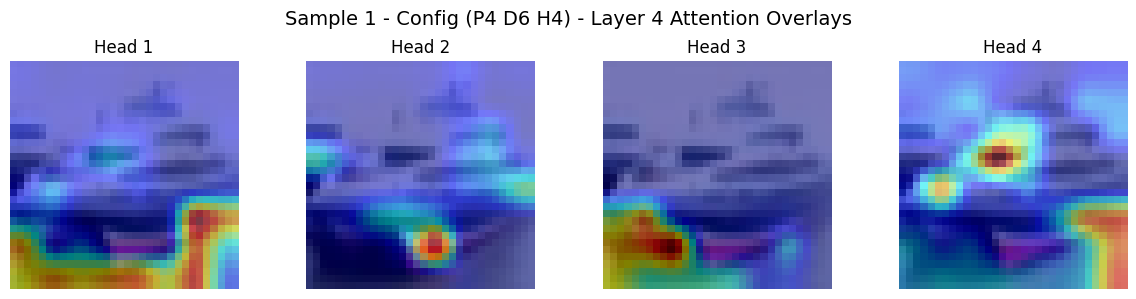

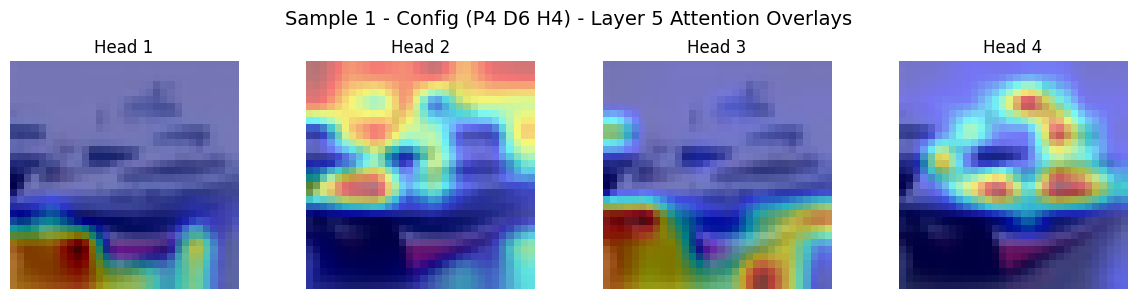

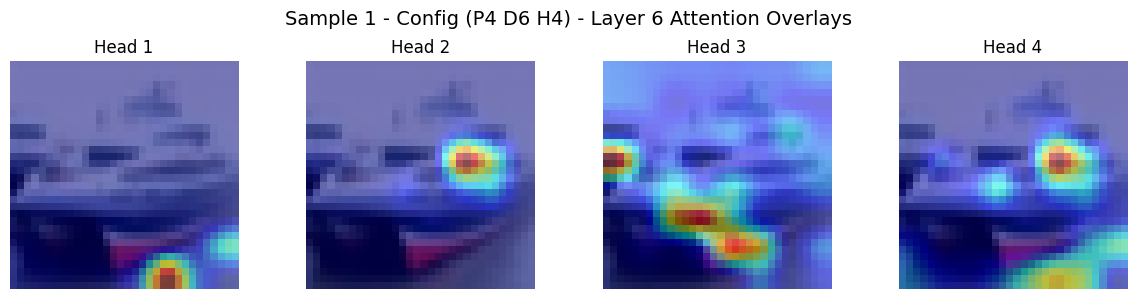

Summary of results:
Patch Size: 4, Depth: 6, Num Heads: 8 -> Test Acc: 0.6403
Patch Size: 2, Depth: 6, Num Heads: 8 -> Test Acc: 0.6710
Patch Size: 4, Depth: 12, Num Heads: 8 -> Test Acc: 0.6263
Patch Size: 4, Depth: 6, Num Heads: 4 -> Test Acc: 0.6254


In [ ]:
for config in configs:
    print("----------------------------------------------------")
    print(f"Config: Patch Size {config['patch_size']}, Depth {config['depth']}, Num Heads {config['num_heads']}")

    model = VisionTransformer(
        img_size=32,
        patch_size=config["patch_size"],
        in_chans=3,
        num_classes=10,
        embed_dim=config["embed_dim"],
        depth=config["depth"],
        num_heads=config["num_heads"],
        mlp_ratio=4.0,
        dropout=0.1
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    criterion = nn.CrossEntropyLoss()

    num_epochs = 10  # Fewer epochs for picking the best config
    for epoch in range(num_epochs):
        train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)
        print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f}")

    test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
    print(f"Config Result -> Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    results.append((config, test_loss, test_acc))
    images, labels = next(iter(test_loader))
    images = images.to(device)

    model.eval()
    with torch.no_grad():
        outputs, attn_weights_all = model(images)

    # Visualization - Display Attention Heatmaps

    # Choose two images from this batch for visualisation
    sample_indices = [0, 1]
    # For each selected sample, displaying the original image and then overlay attention maps from every layer & head.
    for sample_index in sample_indices:
        img_np = denormalize(images[sample_index])
        # Display original image
        plt.figure(figsize=(3,3))
        plt.imshow(img_np, interpolation='nearest', aspect='equal')
        plt.title(f"Config (P{config['patch_size']} D{config['depth']} H{config['num_heads']}): Original Image - Sample {sample_index}")
        plt.axis("off")
        plt.show()

        # Loop over each attention layer weights
        num_layers = len(attn_weights_all)
        for layer_idx, attn_layer in enumerate(attn_weights_all):
            num_heads = attn_layer.shape[1]
            fig, axes = plt.subplots(1, num_heads, figsize=(num_heads * 3, 3))
            fig.suptitle(f"Sample {sample_index} - Config (P{config['patch_size']} D{config['depth']} H{config['num_heads']}) - Layer {layer_idx+1} Attention Overlays", fontsize=14)
            if num_heads == 1:
                axes = [axes]
            for head_idx in range(num_heads):
                attn_map = attn_layer[sample_index, head_idx].detach().cpu().numpy()
                overlay = overlay_attention_on_image(img_np, attn_map, patch_size=config["patch_size"], alpha=0.5)
                axes[head_idx].imshow(overlay)
                axes[head_idx].set_title(f"Head {head_idx+1}")
                axes[head_idx].axis("off")
            plt.tight_layout()
            plt.show()

print("====================================================")
print("Summary of results:")
for config, test_loss, test_acc in results:
    print(f"Patch Size: {config['patch_size']}, Depth: {config['depth']}, Num Heads: {config['num_heads']} -> Test Acc: {test_acc:.4f}")

Running config: {'patch_size': 2, 'depth': 6, 'num_heads': 8, 'embed_dim': 128}
Epoch 1/30: Train Loss 1.7055, Train Acc 0.3671
Epoch 2/30: Train Loss 1.3586, Train Acc 0.5043
Epoch 3/30: Train Loss 1.1945, Train Acc 0.5674
Epoch 4/30: Train Loss 1.0885, Train Acc 0.6077
Epoch 5/30: Train Loss 1.0094, Train Acc 0.6366
Epoch 6/30: Train Loss 0.9463, Train Acc 0.6613
Epoch 7/30: Train Loss 0.8868, Train Acc 0.6797
Epoch 8/30: Train Loss 0.8371, Train Acc 0.6996
Epoch 9/30: Train Loss 0.7842, Train Acc 0.7173
Epoch 10/30: Train Loss 0.7457, Train Acc 0.7338
Epoch 11/30: Train Loss 0.7009, Train Acc 0.7504
Epoch 12/30: Train Loss 0.6597, Train Acc 0.7631
Epoch 13/30: Train Loss 0.6215, Train Acc 0.7776
Epoch 14/30: Train Loss 0.5821, Train Acc 0.7905
Epoch 15/30: Train Loss 0.5396, Train Acc 0.8043
Epoch 16/30: Train Loss 0.5059, Train Acc 0.8169
Epoch 17/30: Train Loss 0.4629, Train Acc 0.8340
Epoch 18/30: Train Loss 0.4304, Train Acc 0.8445
Epoch 19/30: Train Loss 0.3974, Train Acc 0.857

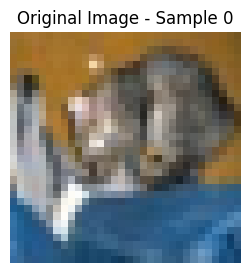

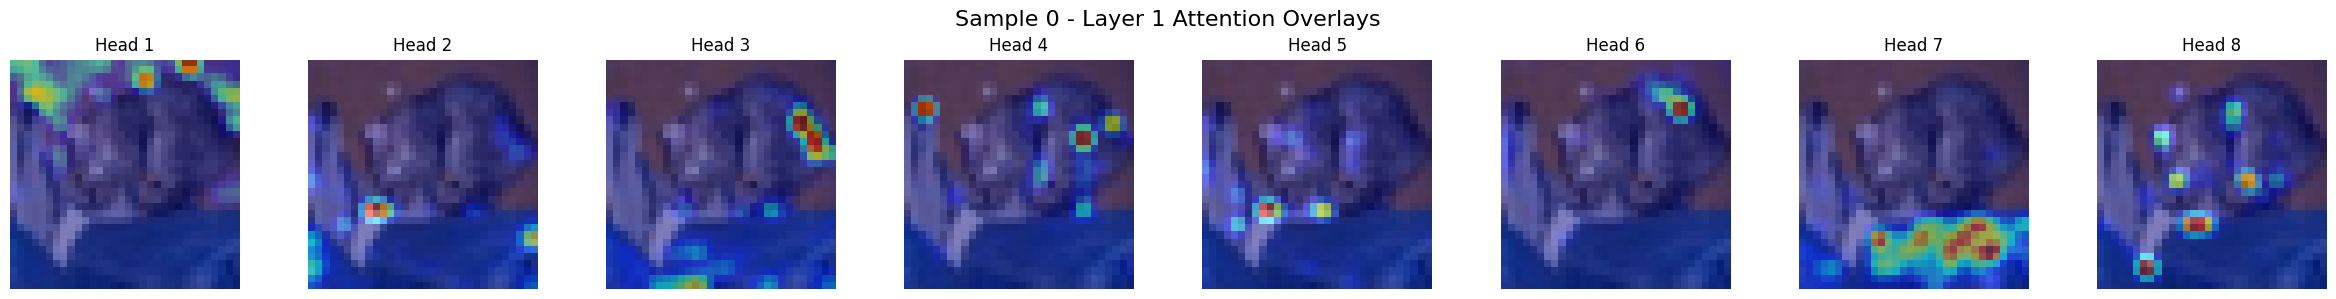

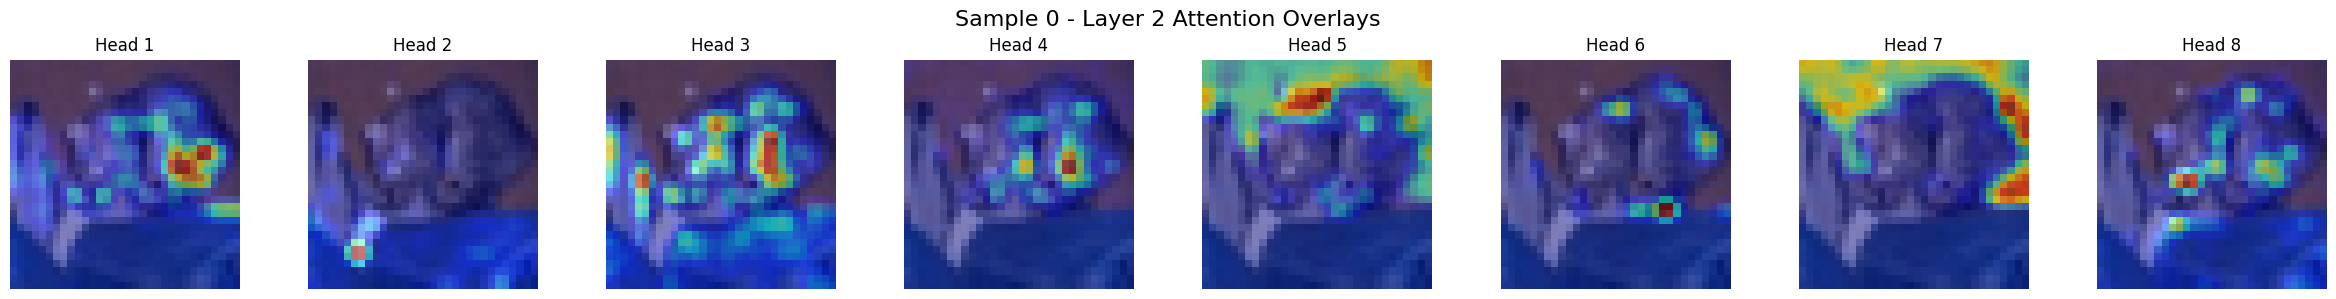

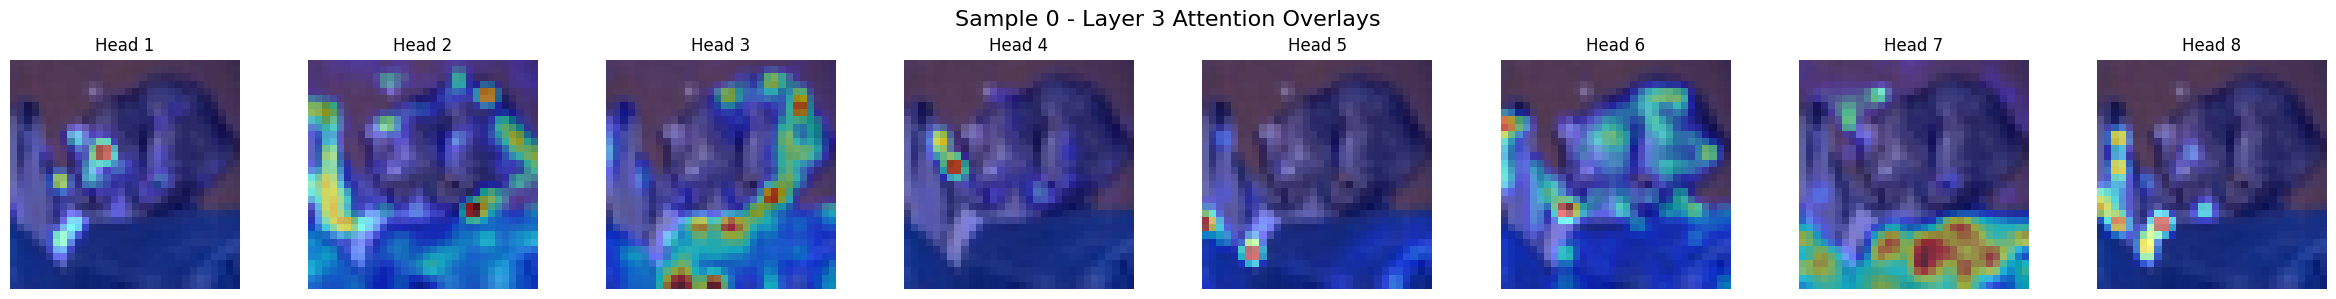

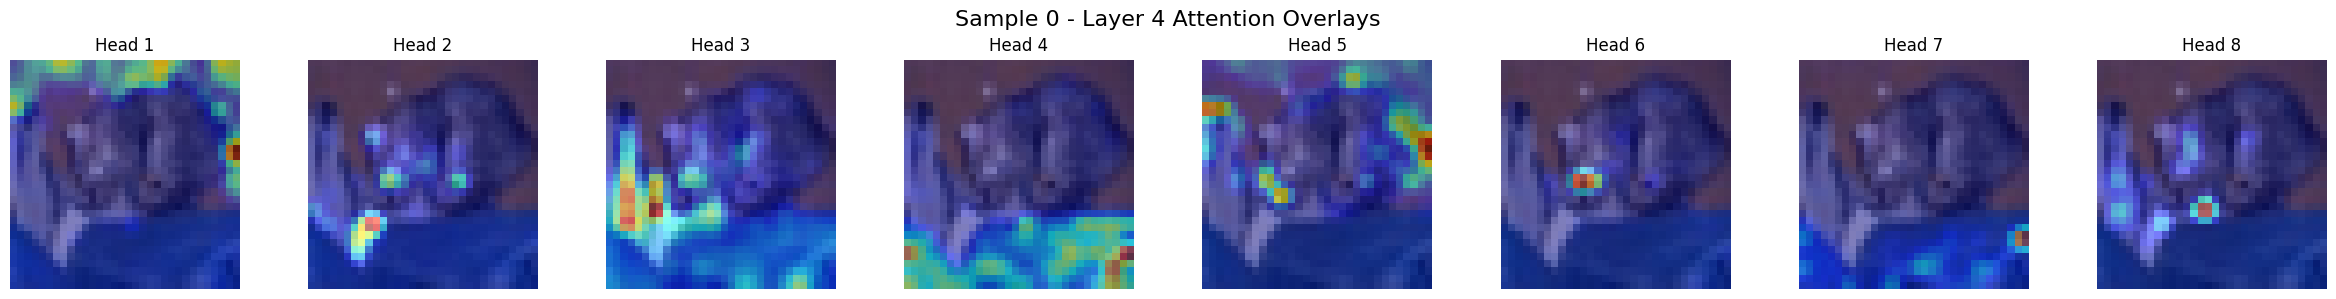

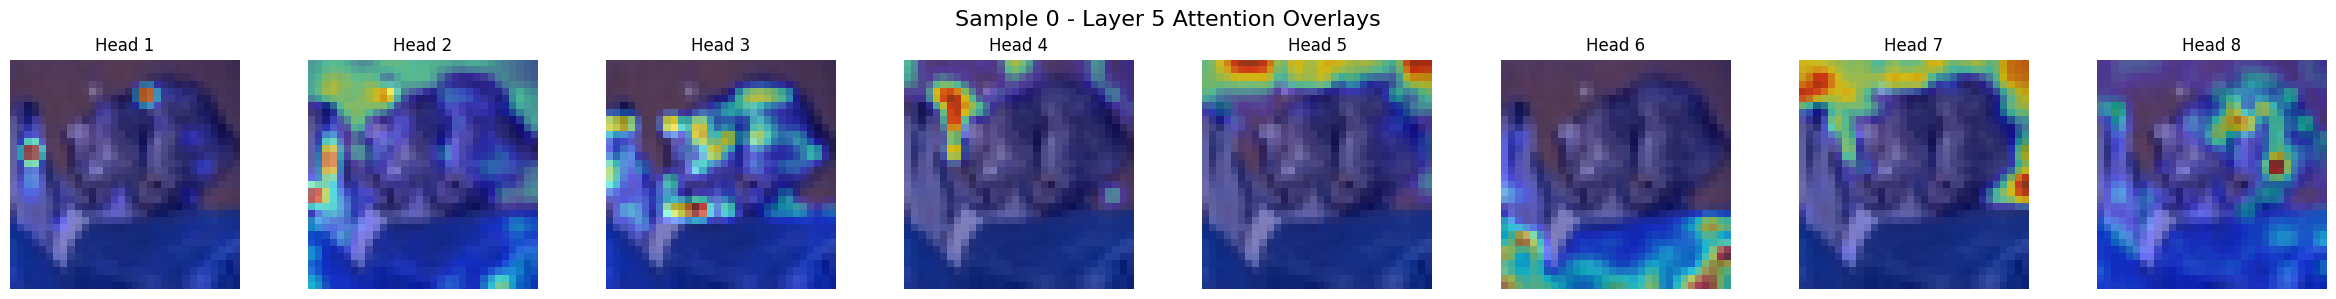

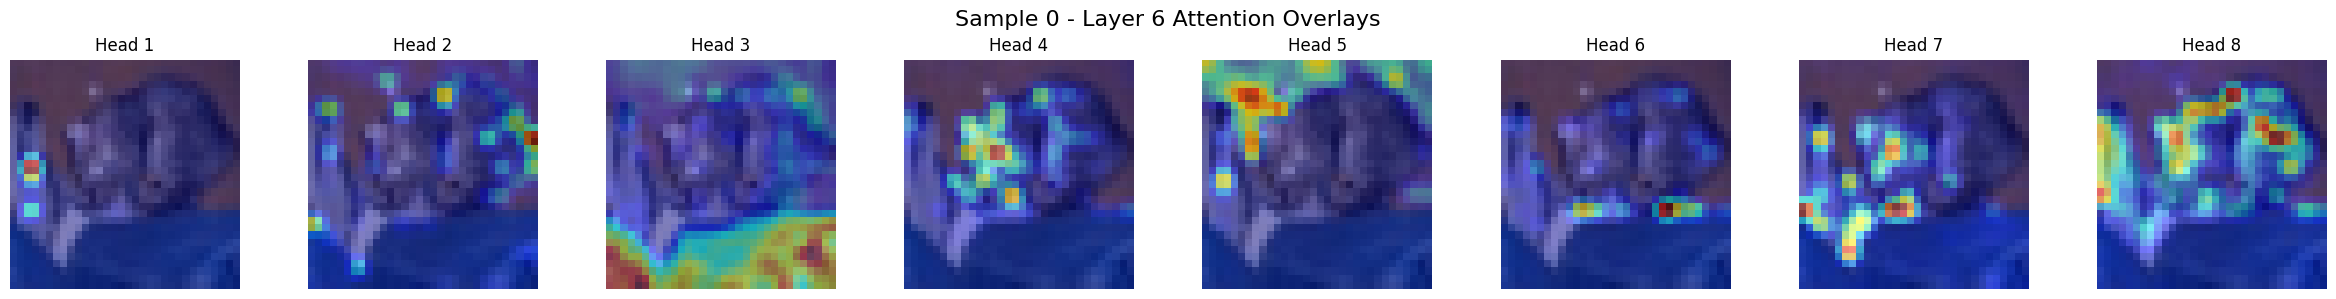

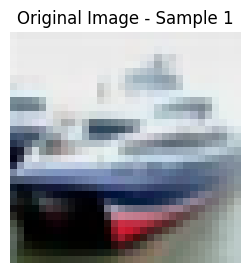

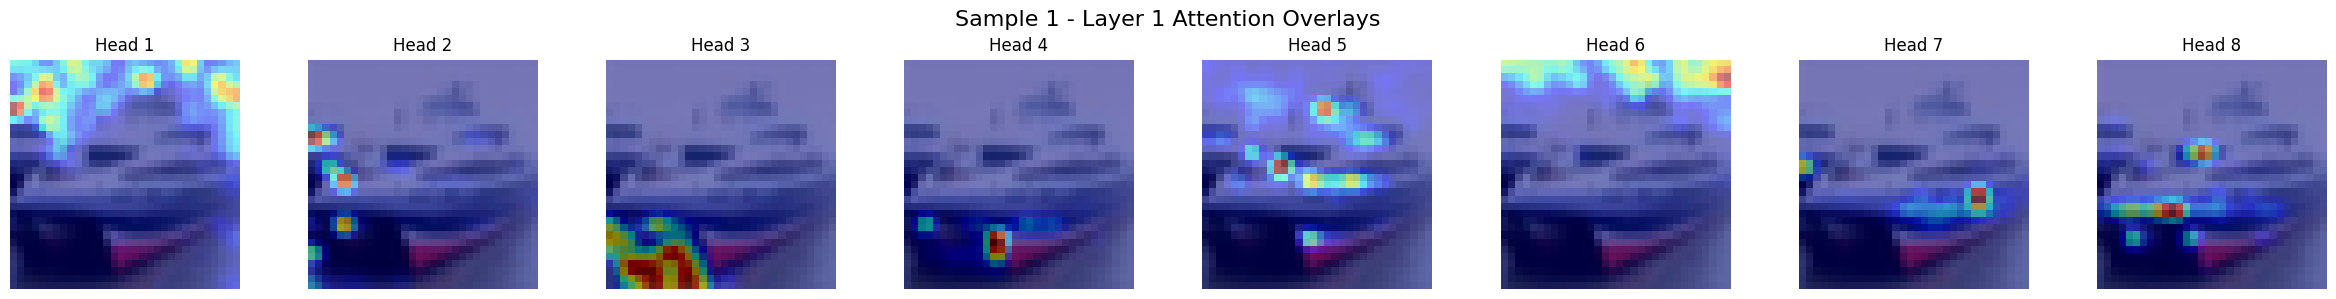

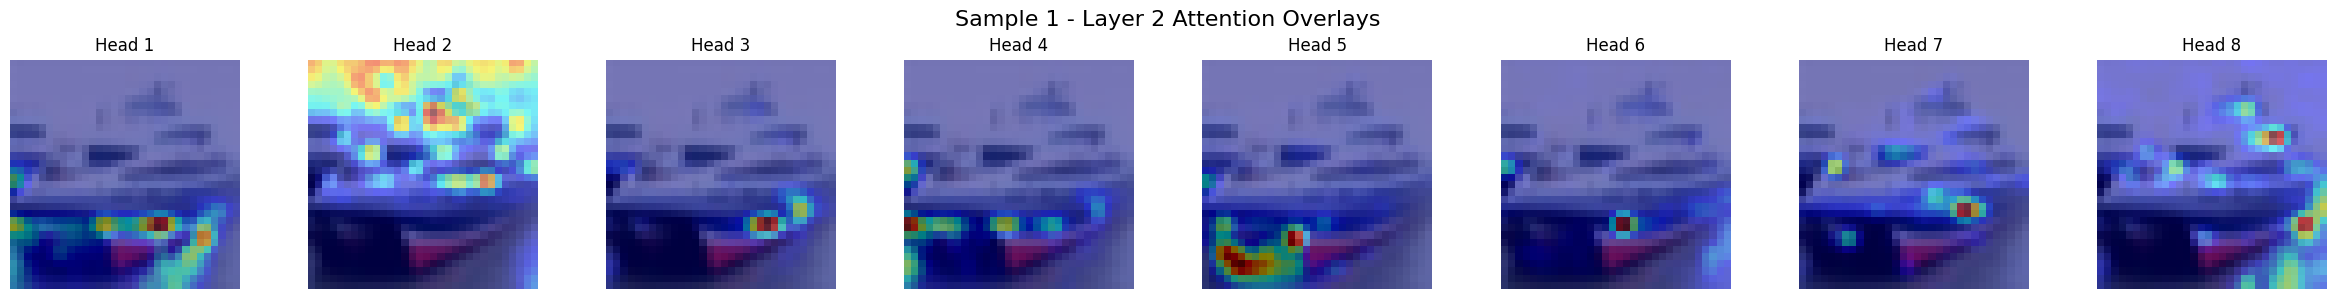

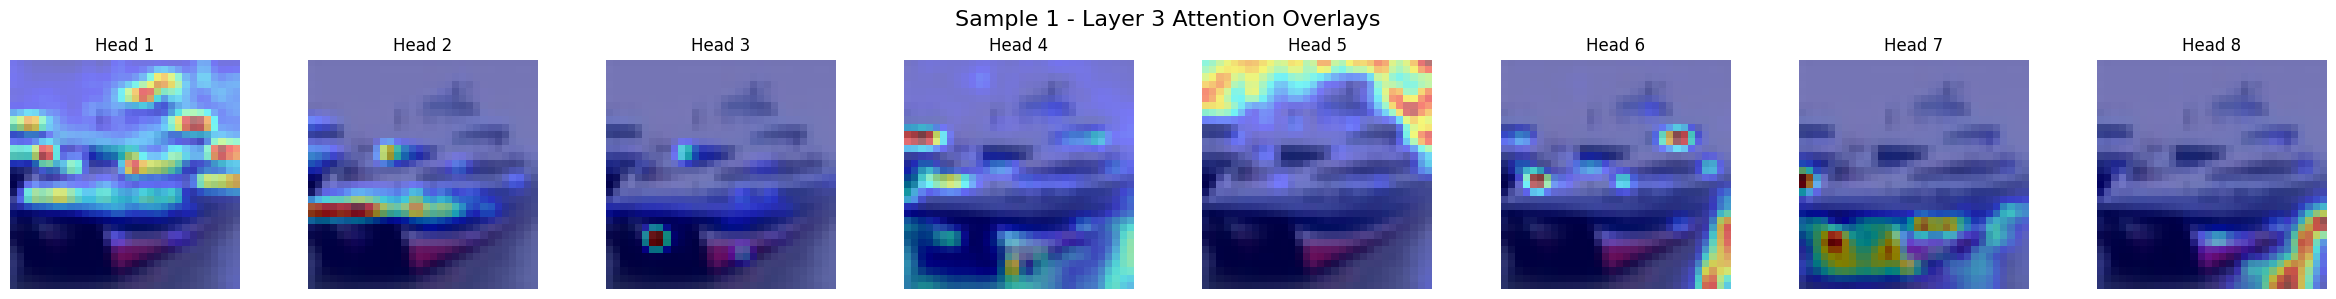

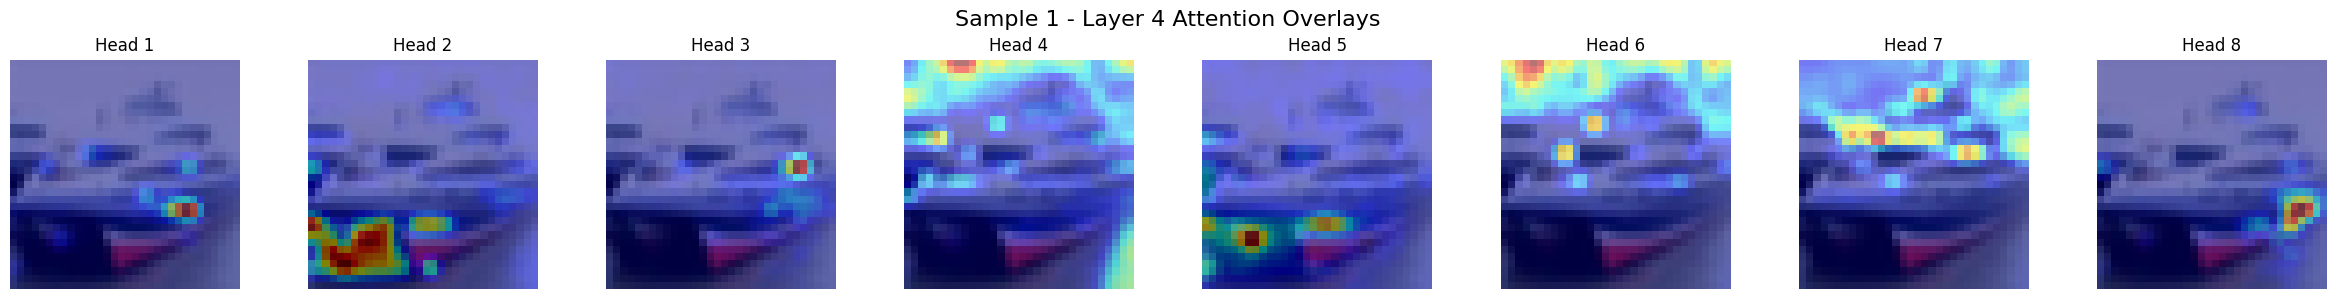

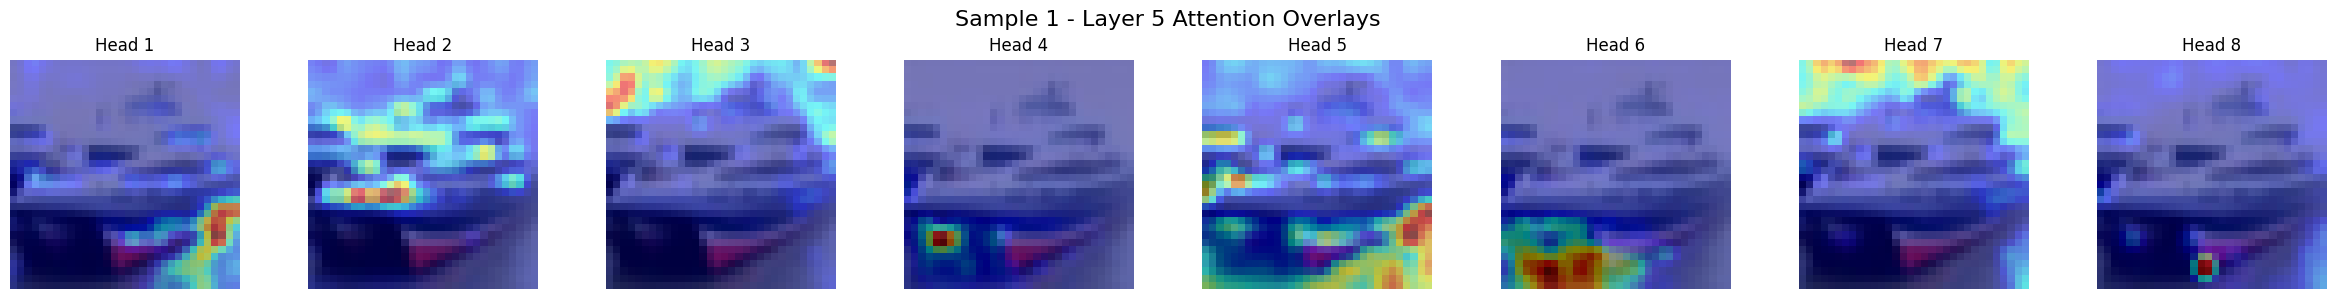

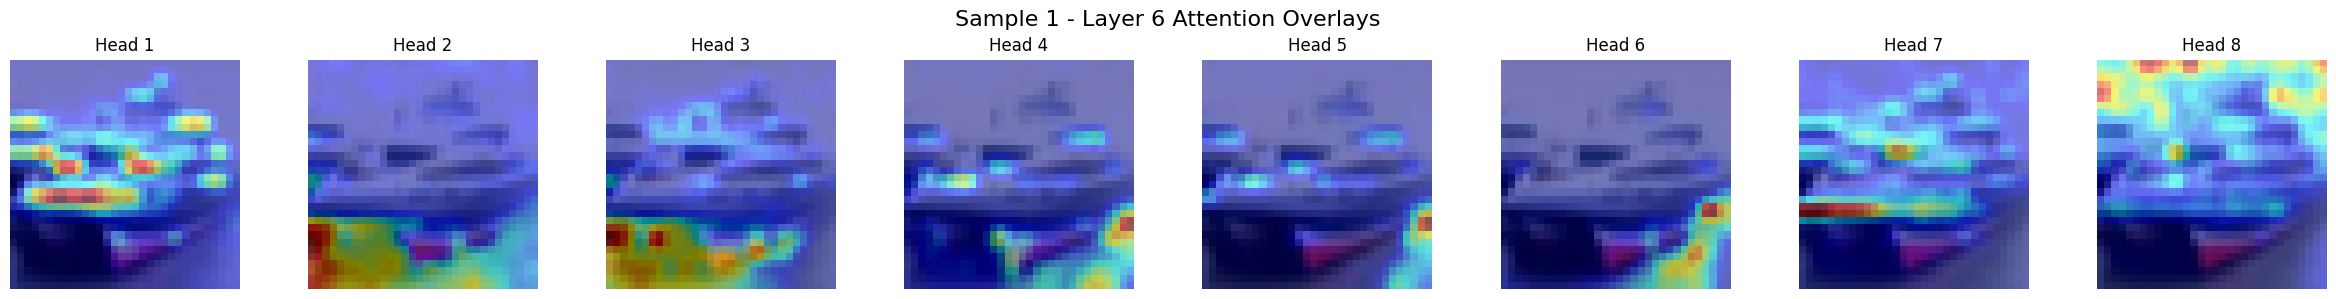

In [ ]:
# the best configuration
config = {"patch_size": 2, "depth": 6, "num_heads": 8, "embed_dim": 128}
print("Running config:", config)

# Vision Transformer Init.
model = VisionTransformer(
    img_size=32,
    patch_size=config["patch_size"],
    in_chans=3,
    num_classes=10,
    embed_dim=config["embed_dim"],
    depth=config["depth"],
    num_heads=config["num_heads"],
    mlp_ratio=4.0,
    dropout=0.1
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

# Training the model for 30 epochs.
num_epochs = 30
for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f}")

# Evaluating the model on the test set.
test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

# Visualization - Display Attention Heatmaps
# Get one batch from the test set.
images, labels = next(iter(test_loader))
images = images.to(device)

model.eval()
with torch.no_grad():
    outputs, attn_weights_all = model(images)

# Pick 2 images for Visualisation.
sample_indices = [0, 1]

# For each selected sample, displaying the original image and then overlay attention maps from every layer & head.
for sample_index in sample_indices:
    img_np = denormalize(images[sample_index])

    # Display the original image.
    plt.figure(figsize=(3,3))
    plt.imshow(img_np, interpolation='nearest', aspect='equal')
    plt.title(f"Original Image - Sample {sample_index}")
    plt.axis("off")
    plt.show()

    # Loop over each layer.
    num_layers = len(attn_weights_all)
    for layer_idx, attn_layer in enumerate(attn_weights_all):
        num_heads = attn_layer.shape[1]
        fig, axes = plt.subplots(1, num_heads, figsize=(num_heads * 3, 3))
        fig.suptitle(f"Sample {sample_index} - Layer {layer_idx+1} Attention Overlays", fontsize=16)

        if num_heads == 1:
            axes = [axes]

        # Loop over each attention head.
        for head_idx in range(num_heads):
            attn_map = attn_layer[sample_index, head_idx].detach().cpu().numpy()
            overlay = overlay_attention_on_image(img_np, attn_map, patch_size=config["patch_size"], alpha=0.5)
            axes[head_idx].imshow(overlay)
            axes[head_idx].set_title(f"Head {head_idx+1}")
            axes[head_idx].axis("off")
        plt.tight_layout()
        plt.show()


### Observations
The vision Transformer was trained for the following parameter settings for 10 epochs
1.  Config 1->  Patch size : 4, Depth : 6, Num heads : 8 -> Test loss : 1.0116, Test accuracy : 0.6403
2. Config 2-> Patch size : 2, Depth : 6, Num heads : 8 -> Test loss : 0.8571, Test accuracy : 0.6710
3. Config 3-> Patch size : 4, Depth : 12, Num heads : 8 -> Test loss : 1.0483, Test accuracy : 0.6263
4. Config 4-> Patch size : 4, Depth : 6, Num heads : 4 -> Test loss : 1.0336, Test accuracy : 0.6254

From this the model was trained for 30 epochs on config 2,
Test loss: 1.2834, test accuracy : 0.6923



### Analysis of attention maps
* In layer 0 different  heads try to capture different regions of image.
* Head 1 captured the edge detailing  of the object under consideration.
* Head 2 focused on certain areas of image in detail. It emphasized localised attention.
* Head 3 focused more on the centre of object. A high focus is given on important areas of object Head 4 focuses on random areas. It indicated that it is  concentrating equally  on object and background details. It learned the finer details such as texture and boundaries.
* Head 5 and head 6 are focusing on specific regions of the object core areas.
* Head 7 focused solely on background.  It showed a concentrated high intensity indicating that the region is well captured. Great attention is given to background detailing. It learned global features of surrounding areas.
* Head 8 also focused more on the fine grained information. It gathers different edges of object and is including spatial information also.

* Each head is analysing different regions of objects and its background.
* In layer 2 the attention focus completely changed.
* Head 1 and head 3 are focusing on object detailing  greatly. It tries to gather even the minute details of the object.
* Head 5 and Head 7 are greatly focussed on the background details. It gathers to consider the back ground details and edges of object as well. These heads focus on the boundaries of image and the background details. Thus they capture spatial relationships.
* In layer 3 the head3 gave a much better view of how the edge details could be gathered. The head focused mainly on  the edges and boundaries of object perfectly.
* Head2 also focused on  the edge detection.
* Head 8 focused on the unexplored edges off object which head 3 failed to capture.
* Head 6 focuses on the image features globally. It doesn't learn from a specific region. Instead it focusses on global context of the image. It covers almost the whole of the image including  centre area.
* In layer 4, head 4  captured the background and image edges of the bottom of the image. The boundaries are  well captured. It captures the spatial information about the relationship between edges and background details. It also focuses on the global context of a huge surrounding area.
* While head 6, 7, 8 are focusing more on the localised areas like edge of the object for example, beak, eye etc in this image.
* On moving to layer 5 the attention increased. The area under focus increased. * More heads started capturing global attention from local to broader receptive fields.
* In earlier layers focus was more on localized areas to capture image specific features more. But towards the later layers the focus shifted more on the relationships like spatial information, how the object and background separates.

* Later layers give more global attention to larger area of image and finds spatial relationship of different parts of image or between image and background details.
* In later layers especially layer 6 the different colour intensities indicates how the attention focus shifted over time.
* More focus is given to a specific region ( red colour) and as well as to the  surrounding regions with lesser intensity. This way it learns a context and identifies the surrounding region with lower intensity.
* The area of focus blends with background and not  everything is not given the same focus.
* This is how the attention maps learn localised features, background details,  the edges.
* Thus they map the object and background details, identifies a region and surrounding region of different intensities and localises the objects from the feature map efficiently.





### Analysis of attention maps across different config
* In config 1 too much focus is on localised attention. Background details or edges are not effectively detected.
* In config 2 global and local features are extracted sufficiently. Edges and boundaries are also detected.
* In config 3 majority of maps are focusing on background details and least focus on object features.
* In config 4 very few heads are present and they focus primarily on localised regions.